## **Pattern Recognition: Pre-Lab 1 - "Voice recognition with Hidden Markov Models and Recurrent Neural Networks"**

---

### **Course Overview**

This project was developed by our team in the **School of Electrical and Computer Engineering (ECE), NTUA (Semester: Autumn 2025-2026).**
- **Course Name:** Pattern Recognition
- **Instructor:** Alexandros Potamianos
- **Submission Deadline:** 29.10.2025

---

### **Team Overview**

Our team consists of the following members:
- **Peppas Michail-Athanasios** | 03121026
- **Augerinos Panagiotis** | 03121023

---

### **Project Scope**

This assignment focuses on building an **automatic speech recognition (ASR) pipeline for isolated spoken digits (0–9)** using both **probabilistic sequence models** and **neural sequence models**. It now includes work up to **Step 14** of the lab.

The main goals are:

* **a. Audio Feature Extraction and Analysis (Steps 1–4)**  
  - Load and inspect raw speech recordings from the Free Spoken Digit Dataset (FSDD) using `librosa`.  
  - Compute frame-level **MFCC features** (and optionally deltas / delta-deltas).  
  - Compare **MFCCs** and **MFSCs** (Mel filterbank energies) and explain what each feature family captures.  
  - Visualize example utterances and relate the features to the acoustic content.

* **b. Feature Visualization and Dimensionality Reduction (Steps 5–8)**  
  - Compute summary statistics per utterance (e.g. mean and standard deviation of each MFCC coefficient) to get fixed-length vectors.  
  - Visualize feature distributions with histograms / scatter plots.  
  - Apply **PCA** to project features into 2D or 3D, interpret class separability, and measure explained variance.  
  - Train and evaluate classic classifiers (Naive Bayes, SVM, k-NN, Decision Tree, etc.) on these fixed-length vectors, after normalization.

* **c. Sequence Modeling Setup (Step 9)**  
  - Load the full dataset and extract MFCC frame sequences for every utterance.  
  - Respect the dataset’s official split:  
    - A fixed **TEST** set (≈300 samples, ~10% of the 3000 recordings) defined by utterance IDs 0–4.  
    - The remaining ≈2700 samples as the initial training pool.  
  - From that training pool, create a **stratified VALIDATION set (20%)** and the final **TRAIN set (80%)**, preserving digit balance.  
    - Final proportions over the entire dataset are ≈72% TRAIN / ≈18% VAL / 10% TEST.  
  - Fit a `StandardScaler` on TRAIN only and apply it to TRAIN / VAL / TEST.  
    - The printed `mean: [...]` and `std: [...]` are the per-MFCC mean and standard deviation estimated from TRAIN.  
    - Every MFCC frame is normalized
      using these TRAIN-only statistics.  
    - This gives features on comparable scale, stabilizes model training, and prevents validation / test leakage.

* **d. GMM-HMM Acoustic Modeling (Steps 10–13)**  
  - Treat each spoken digit as its own **acoustic class** with its own **Hidden Markov Model (HMM)**.  
  - Use **Gaussian Mixture Models (GMMs)** for HMM emission probabilities, so each state models short-term acoustic behavior of the digit.  
  - Train an HMM per digit on the TRAIN split (frame sequences).  
  - Tune HMM hyperparameters (e.g. number of states, number of Gaussians per state) using the VALIDATION split.  
  - Evaluate recognition accuracy on the TEST split by running Viterbi / likelihood scoring and picking the most likely digit.

* **e. Recurrent Neural Network (RNN / LSTM) Modeling (Step 14)**  
  - Build a sequential neural model (e.g. RNN / LSTM / GRU in PyTorch) that takes the MFCC frame sequence of an utterance and predicts its digit label (0–9).  
  - Train the network on TRAIN, monitor performance on VALIDATION for early stopping or hyperparameter tuning (learning rate, hidden size, etc.).  
  - After tuning, report classification accuracy on the held-out TEST split.  
  - Compare behavior of the neural sequence model against the HMM approach.

* **f. Comparative Evaluation and Discussion (Steps 13–14 conclusions)**  
  - Compare **classical frame-based generative models (GMM-HMM)** vs **discriminative neural sequence models (RNN/LSTM)**.  
  - Discuss robustness across speakers, scaling behavior, data efficiency, and where each model succeeds or fails.  
  - Summarize which pipeline choices mattered most:
    - MFCC parametrization  
    - Normalization strategy  
    - Train / Val / Test protocol  
    - Model architecture and hyperparameters

---

### **Mounting Google Drive**

Before any processing can take place, it is necessary to **mount Google Drive** to access the dataset and supporting files.  
This operation links the Google Drive storage to the **Colab environment**, making files accessible under the path `/content/drive/MyDrive/`.

**Purpose:**  
- Allow direct reading of files (e.g., `pr_lab2_data/digits`) stored in Google Drive.  
- Simplify file handling and path definitions for subsequent steps in the notebook.  

After successful authorization, all project data will be available for loading and analysis.


In [1]:
# ==============================================================
# Mount Google Drive
# ==============================================================
# This step connects Google Drive to the Colab environment
# and allows access to datasets stored within it.

from google.colab import drive

# Mount the drive at /content/drive
drive.mount('/content/drive')

# Define the dataset path for easy reuse later
import os

# The path containing the data
drive_base = '/content/drive/MyDrive/'
dataset_path = os.path.join(drive_base, 'NTUA-Pattern_Recognition/Lab1/pr_lab2_data')

print(f"Drive mounted successfully. Dataset located at:\n{dataset_path}")


Mounted at /content/drive
Drive mounted successfully. Dataset located at:
/content/drive/MyDrive/NTUA-Pattern_Recognition/Lab1/pr_lab2_data


## **Preparatory Lab - Steps 1-8**

---

### **Step 1 — Praat Analysis (Manual, Included in Report)**

This step is conducted **outside the Colab notebook**, using the **Praat** software.  
It involves visually inspecting and acoustically analyzing two recordings:

- `onetwothree1.wav` (male speaker)  
- `onetwothree8.wav` (female speaker)

**Tasks performed in Praat:**
- Display and compare waveforms and spectrograms.
- Measure the **average pitch** and **first three formants (F1–F3)** for vowels *a*, *u*, *i*.
- Discuss differences between male and female speakers (pitch range, formant spacing).

These measurements, observations, and screenshots are **included in the written report** (not executed in this notebook) as required by the assignment.


### **Step 2 — Isolated-Digit Loader**

#### **Goal**
Discover and load **isolated English digit** recordings (1–9) from `digits/`, convert audio to **mono 16 kHz**, and return exactly **three lists** for the next steps.

---

#### **Public API (used in the code cell)**
- **`parse_digits_wavs_labels_speakers(dataset_root, subdir="digits", target_sr=16000, recursive=True)`**
  - Recursively finds `.wav` files under `<dataset_root>/<subdir>/` and **keeps only names of the following format**:  
    `"<digitword><speaker>.wav"` (e.g., `eight8.wav`).
  - Maps the word to a numeric label **1–9** and uses the numeric suffix as **speaker ID**.
  - Loads each file with `librosa.load(..., sr=16000, mono=True)` to ensure **uniform sampling**.
  - Processes files in **sorted order** for reproducibility.
  - **Returns (in this order):**  
    1) `wavs`: list of `np.ndarray` waveforms  
    2) `y_num`: list of integer labels (1–9)  
    3) `speakers`: list of speaker IDs (strings)

---

#### **Sanity prints**
- A one-line summary: number of parsed files and the sampling rate (16 kHz).
- Counts of returned lists (they must be equal).
- A few `(label, speaker)` pairs and example waveform lengths (in samples).



In [ ]:
# ==============================================================
# Step 2 — Data Parsing (Loading the Speech Corpus)
# ==============================================================

import os
import re
from glob import glob
from typing import List, Tuple, Dict, Optional

import numpy as np
import librosa

# Map digit words → numeric labels for Scheme A ("eight8.wav", etc.)
_WORD_TO_NUM: Dict[str, int] = {
    "one": 1, "two": 2, "three": 3, "four": 4, "five": 5,
    "six": 6, "seven": 7, "eight": 8, "nine": 9
}

# File name pattern for Scheme A: "<digitword><speaker>.wav"
_SCHEME_A_RE = re.compile(
    r"^(one|two|three|four|five|six|seven|eight|nine)(\d+)\.wav$",
    re.IGNORECASE
)

def parse_digits_wavs_labels_speakers(
    dataset_root: str,
    subdir: str = "digits",
    target_sr: int = 16000,
    recursive: bool = True
) -> Tuple[List[np.ndarray], List[int], List[str]]:
    """
    Load isolated-digit recordings using Scheme A only and return EXACTLY three lists:
      wavs      : List[np.ndarray]  (mono waveforms, resampled to target_sr)
      y_num     : List[int]         (numeric labels 1..9)
      speakers  : List[str]         (speaker IDs as strings)
    """
    search_path = os.path.join(dataset_root, subdir)
    if not os.path.isdir(search_path):
        raise FileNotFoundError(f"Directory not found: {search_path}")

    pattern = "**/*.wav" if recursive else "*.wav"
    files = glob(os.path.join(search_path, pattern), recursive=recursive)
    files.sort()

    wavs: List[np.ndarray] = []
    y_num: List[int] = []
    speakers: List[str] = []

    for f in files:
        fname = os.path.basename(f)
        m: Optional[re.Match] = _SCHEME_A_RE.match(fname)
        if m is None:
            # Ignore anything not matching Scheme A (no Scheme B / no phrase files here)
            continue

        digit_word = m.group(1).lower()
        spk_id     = m.group(2)       # speaker digits after the word
        label      = _WORD_TO_NUM[digit_word]

        # Load mono waveform at the assignment SR (16 kHz)
        wav, _ = librosa.load(f, sr=target_sr, mono=True)
        wavs.append(wav.astype(np.float32))
        y_num.append(int(label))
        speakers.append(str(spk_id))

    print(f"Parsed {len(wavs)} isolated-digit files at {target_sr} Hz "
          f"from: {os.path.join(dataset_root, subdir)}")
    return wavs, y_num, speakers


# --- Example invocation (uses dataset_path defined in the Drive-mount cell) ---
dataset_root = dataset_path
wavs, y_num, speakers = parse_digits_wavs_labels_speakers(dataset_root)
Fs = 16000  # keep SR available for later steps

# Quick sanity printout
print(f"Returned lists: wavs={len(wavs)}, labels={len(y_num)}, speakers={len(speakers)}")
print(f"First 5 (label, speaker): {list(zip(y_num, speakers))[:5]}")
print(f"Example waveform lengths (samples): {[len(w) for w in wavs[:3]]}")



Parsed 133 isolated-digit files at 16000 Hz from: /content/drive/MyDrive/NTUA-Pattern_Recognition/Lab1/pr_lab2_data/digits
Returned lists: wavs=133, labels=133, speakers=133
First 5 (label, speaker): [(8, '1'), (8, '10'), (8, '11'), (8, '12'), (8, '13')]
Example waveform lengths (samples): [11891, 8821, 10485]


### **Step 3 — MFCC, Δ, and ΔΔ Feature Extraction**

#### **Goal**
For each utterance, compute **13 MFCCs** with a **25 ms** analysis window and **10 ms** hop; then compute **Δ** and **ΔΔ** (first and second temporal derivatives). Concatenate per frame to obtain **39-dimensional** features.

---

#### **Functions (What Each Does)**
- **`extract_mfcc_and_deltas(wavs, sr, ...)`**  
  Computes per-frame MFCCs and their temporal derivatives (Δ, ΔΔ), then stacks them to form a 39-D feature sequence per utterance. Returns four aligned lists:
  - `mfcc_seqs` — MFCCs `(T, 13)`  
  - `delta_seqs` — Δ features `(T, 13)`  
  - `delta2_seqs` — ΔΔ features `(T, 13)`  
  - `feats39_seqs` — stacked features `(T, 39)`

- **Example invocation block**  
  Calls the function using the parsed waveforms `wavs` and sampling rate `Fs` (from Step 2), then prints a short summary (number of utterances and example shapes) to verify dimensions.

---

#### **Key Parameters (Summary)**
| **Parameter** | **Type / Default** | **Role** | **Practical Impact** |
|---|---|---|---|
| `wavs` | `List[np.ndarray]` | Waveforms to process. | One feature sequence per utterance. |
| `sr` | `int` (expected **16000**) | Sampling rate (Hz). | Drives ms→samples conversion and time/freq scales. |
| `n_mfcc` | `int = 13` | Number of MFCCs. | Standard for speech; aligns with lab spec. |
| `win_ms` | `int = 25` | Window length (ms). | We **fix the actual analysis window** to 25 ms via `win_length`. |
| `hop_ms` | `int = 10` | Frame step (ms). | Temporal stride; controls number of frames (**T**). |
| `n_mels` | `int = 26` | Mel filterbank channels. | Common baseline front-end for ASR. |
| `center` | `bool = True` | Center frames (with padding). | Matches common librosa defaults. |
| `n_fft` *(derived)* | next power of two ≥ `win_ms·sr/1000` | FFT size. | Speeds STFT while keeping `win_length=25 ms`. |
| `win_length` *(derived)* | `round(win_ms·sr/1000)` | **Actual window size** used by STFT. | Ensures the window is **exactly 25 ms** (lab requirement). |
| `hop_length` *(derived)* | `round(hop_ms·sr/1000)` | Step in samples. | Implements the **10 ms** hop exactly. |

*Defaults (`n_mfcc=13`, `win_ms=25`, `hop_ms=10`, `n_mels=26`) follow the assignment.  
**Important:** We explicitly set `win_length = 25 ms` so the analysis window remains 25 ms even if `n_fft` is a larger power of two.*

---

#### **Output Interpretation**

- `MFCCs/deltas extracted: n_mfcc=13, window=25 ms, hop=10 ms, n_mels=26, n_fft=512, win_length=400.`  
  Confirms lab spec: **13 MFCCs**; **25 ms** window (`win_length=400 @ 16 kHz`); **10 ms** hop (`hop_length=160`); **26** mel filters; FFT uses a power-of-two (e.g., 512) for speed.

- `Utterances processed: 133`  
  All recordings were processed (e.g., **133** total).

- `Example shapes (first utterance): {'mfcc': (T, 13), 'delta': (T, 13), 'delta2': (T, 13), 'stacked_39': (T, 39)}`  
  Per frame we have **13 MFCCs + 13 Δ + 13 ΔΔ = 39** features; time dimension is **T**.

- **Why 39 features?**  
  13 static MFCCs (spectral envelope) + 13 Δ (velocity) + 13 ΔΔ (acceleration) capture spectral shape and short-term dynamics — the standard ASR baseline.



In [ ]:
# ==============================================================
# Step 3 — MFCC, Δ, and ΔΔ Feature Extraction
# --------------------------------------------------------------
# Extracts per-frame speech features:
#   • 13 MFCCs (librosa includes C0 by default)
#   • Δ (first temporal derivatives) and ΔΔ (second temporal derivatives)
# Uses EXACTLY: 25 ms analysis window and 10 ms hop at 16 kHz.
# Concatenates [MFCC | Δ | ΔΔ] → 39-dim features per frame.
# Returns aligned lists of MFCC, Δ, ΔΔ, and stacked (39-D) feature sequences.
# ==============================================================

from typing import List, Tuple
import numpy as np
import librosa

def extract_mfcc_and_deltas(
    wavs: List[np.ndarray],
    sr: int,
    n_mfcc: int = 13,
    win_ms: int = 25,
    hop_ms: int = 10,
    n_mels: int = 26,
    center: bool = True
) -> Tuple[List[np.ndarray], List[np.ndarray], List[np.ndarray], List[np.ndarray]]:
    """
    Compute MFCCs, Δ (deltas), and ΔΔ (delta-deltas) per utterance and stack them to 39-dim.
    Returns four aligned lists: mfcc, delta, delta2, stacked (T, 3*n_mfcc).

    Implementation notes:
      • We set 'win_length' explicitly to match EXACT 25 ms windows at the given 'sr'.
      • We keep 'n_fft' as a power of two for FFT efficiency, but DO NOT let it change the window duration.
      • librosa.feature.delta expects shape (features, frames), hence the transpose before/after.
    """
    # ---- Frame configuration (in samples) ----
    win_length = int(round((win_ms / 1000.0) * sr))   # 25 ms → 400 at 16 kHz
    hop_length = int(round((hop_ms / 1000.0) * sr))   # 10 ms → 160 at 16 kHz

    # Use a power-of-two FFT size for speed, but preserve exact window duration via 'win_length'.
    n_fft = 1 << (win_length - 1).bit_length()        # e.g., next pow2 ≥ 400 → 512

    mfcc_seqs: List[np.ndarray] = []
    delta_seqs: List[np.ndarray] = []
    delta2_seqs: List[np.ndarray] = []
    feats39_seqs: List[np.ndarray] = []

    for wav in wavs:
        # ---- MFCCs ----
        # librosa returns (n_mfcc, T); we transpose to (T, n_mfcc) so time is the first axis.
        mfcc = librosa.feature.mfcc(
            y=wav,
            sr=sr,
            n_mfcc=n_mfcc,
            n_mels=n_mels,
            n_fft=n_fft,
            win_length=win_length,   # keep the analysis window EXACTLY 25 ms
            hop_length=hop_length,   # keep hop EXACTLY 10 ms
            center=center
        ).T  # (T, n_mfcc)

        # ---- Δ and ΔΔ along time ----
        # librosa.feature.delta expects (features, frames), so transpose to (n_mfcc, T), then back.
        d1 = librosa.feature.delta(mfcc.T, order=1).T   # (T, n_mfcc)
        d2 = librosa.feature.delta(mfcc.T, order=2).T   # (T, n_mfcc)

        # ---- Stack per frame: (T, 13) | (T, 13) | (T, 13) → (T, 39) ----
        f39 = np.hstack([mfcc, d1, d2]).astype(np.float32)

        # Cast to float32 for compactness & consistency
        mfcc_seqs.append(mfcc.astype(np.float32))
        delta_seqs.append(d1.astype(np.float32))
        delta2_seqs.append(d2.astype(np.float32))
        feats39_seqs.append(f39)

    # ---- Log configuration and a simple consistency check ----
    print(
        f"MFCCs/deltas extracted: n_mfcc={n_mfcc}, window={win_ms} ms, hop={hop_ms} ms, "
        f"n_mels={n_mels}, n_fft={n_fft}, win_length={win_length}."
    )
    # Sanity assertion on the first utterance shape
    if feats39_seqs:
        assert feats39_seqs[0].shape[1] == 3 * n_mfcc, "Stacked feature dimension must be 3*n_mfcc."

    return mfcc_seqs, delta_seqs, delta2_seqs, feats39_seqs


# ---- Example invocation using parsed waveforms and sampling rate from Step 2 ----
mfcc_seqs, delta_seqs, delta2_seqs, feats39_seqs = extract_mfcc_and_deltas(wavs, Fs)

# ---- Sanity output ----
num_utts = len(mfcc_seqs)
first_shapes = {
    "mfcc": None if num_utts == 0 else mfcc_seqs[0].shape,
    "delta": None if num_utts == 0 else delta_seqs[0].shape,
    "delta2": None if num_utts == 0 else delta2_seqs[0].shape,
    "stacked_39": None if num_utts == 0 else feats39_seqs[0].shape,
}
print(f"Utterances processed: {num_utts}")
print(f"Example shapes (first utterance): {first_shapes}")


MFCCs/deltas extracted: n_mfcc=13, window=25 ms, hop=10 ms, n_mels=26, n_fft=512, win_length=400.
Utterances processed: 133
Example shapes (first utterance): {'mfcc': (75, 13), 'delta': (75, 13), 'delta2': (75, 13), 'stacked_39': (75, 39)}


### **Step 4 — MFCC Histograms and MFSC vs MFCC Correlation Analysis**

####**Goal**  
(A) Test how well low-order MFCCs separate digits **n1=6** and **n2=3** using **MFCC₁** and **MFCC₂** histograms.  
(B) Compare feature correlation **before** DCT (MFSC = log-mel energies) and **after** DCT (MFCC) using **two utterances per digit from different speakers**. All features use **25 ms** window and **10 ms** hop at **16 kHz** (exact `win_length`/`hop_length`), with `n_fft` set to the next power-of-two for FFT efficiency.

---

#### **What each function does**

- **`collect_mfcc_coeffs_for_digit(mfcc_seqs, y_num, target_digit, coeff_idx)`**  
  Concatenates a **single MFCC coefficient** (e.g., index 0 → MFCC₁, index 1 → MFCC₂) **across all frames and utterances** of `target_digit`.  
  Output: `np.ndarray` of shape `(total_frames_for_digit,)` used to plot per-digit histograms.

- **`choose_k_per_digit(y_num, speakers, digit, k=2)`**  
  Selects up to **k utterance indices** for a given `digit` ensuring **distinct speakers** (greedy; falls back if not enough speakers).  
  Output: list of indices used in the correlation analysis.

- **`compute_mfsc_sequence(wav, sr, n_mels=13, win_ms=25, hop_ms=10, center=True)`**  
  Computes **MFSCs** = **log-mel energies** (pre-DCT) with **exact window/hop**; returns a matrix **(T, 13)** where `T` is the number of frames.

- **`corr_matrix(features_TxD)`**  
  Returns the **D×D Pearson correlation matrix** across feature dimensions for an input matrix **(T, D)**. If `T < 2`, returns `NaN`s.

- **`plot_corr_grid(indices, title_prefix, compute_feats_fn)`**  
  For each utterance index in `indices`, computes features via `compute_feats_fn(idx)`, builds a **correlation matrix**, and plots them in a single row with a **shared colorbar**.

> **Inputs required from previous steps:**  
> `wavs` (audio), `Fs=16000`, `mfcc_seqs` (from Step 3), and the metadata lists `y_num`, `speakers`.

---

#### **A. MFCC₁ and MFCC₂ Histograms (all frames, digits 6 vs 3)**

| **Statistic** | **digit 6** | **digit 3** | **Interpretation** |
|---|---:|---:|---|
| **MFCC₁** (C0/energy-tilt) | mean = **−252.82**, std = **63.04** | mean = **−255.22**, std = **60.99** | Very close → weak separability. |
| **MFCC₂** | mean = **42.21**, std = **23.06** | mean = **59.14**, std = **19.61** | Clear mean shift → better separation. |
| **Frame count** | **1167** | **1149** | Comparable sizes; balanced evidence. |

**Observations.**  
MFCC₁ overlaps heavily (mostly energy/tilt); MFCC₂ is shifted upward for digit 3, offering **useful discriminability**.

---

#### **B. MFSC vs MFCC Correlation (two utterances per digit, different speakers)**

- **MFSC (13-D log-mel energies):** strong **off-diagonal** correlations (adjacent mel bands co-vary) → **redundant** spectral representation.  
- **MFCC (13-D, post-DCT):** correlation matrices are **near-diagonal** with reduced off-diagonal mass → **decorrelated** features.

**Takeaway.**  
The DCT in MFCCs **reduces inter-feature correlation** relative to MFSCs. This favors models that assume independent (or simply-correlated) features (e.g., Gaussian/Naive Bayes) and generally yields a more compact, informative representation.

---

#### **Summary**

- **MFCC₂** adds clear class information for **6 vs 3**; **MFCC₁** alone is weak.
- **MFSCs** exhibit strong internal correlation; **MFCCs** are more decorrelated thanks to the DCT.


Histogram summary (mean, std, count):
digit 6 — MFCC1      | mean=-252.8179 std=63.0411 count=1167
digit 6 — MFCC2      | mean=42.2128 std=23.0640 count=1167
digit 3 — MFCC1      | mean=-255.2218 std=60.9909 count=1149
digit 3 — MFCC2      | mean=59.1361 std=19.6144 count=1149


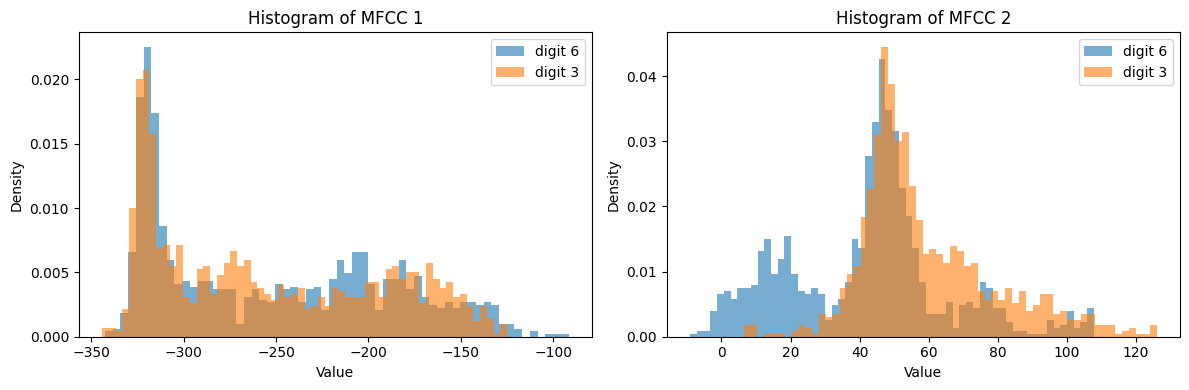


Correlation analysis indices for n1=6: [89, 90] (speakers: ['1', '10'])
Correlation analysis indices for n2=3: [103, 104] (speakers: ['1', '10'])


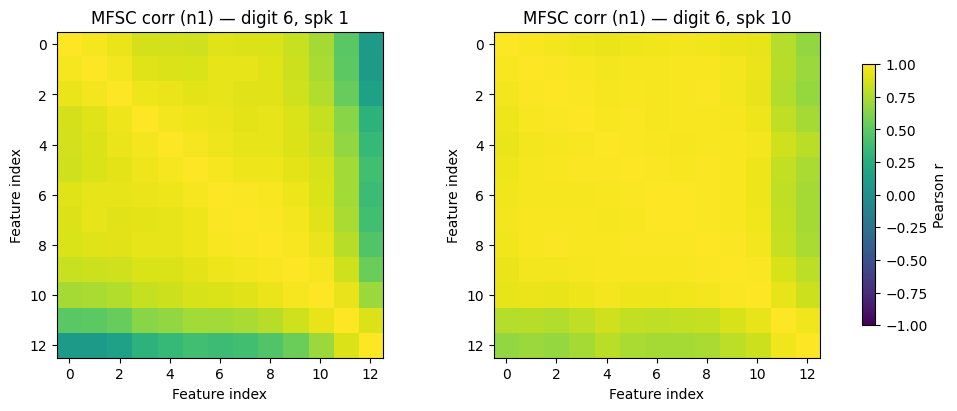

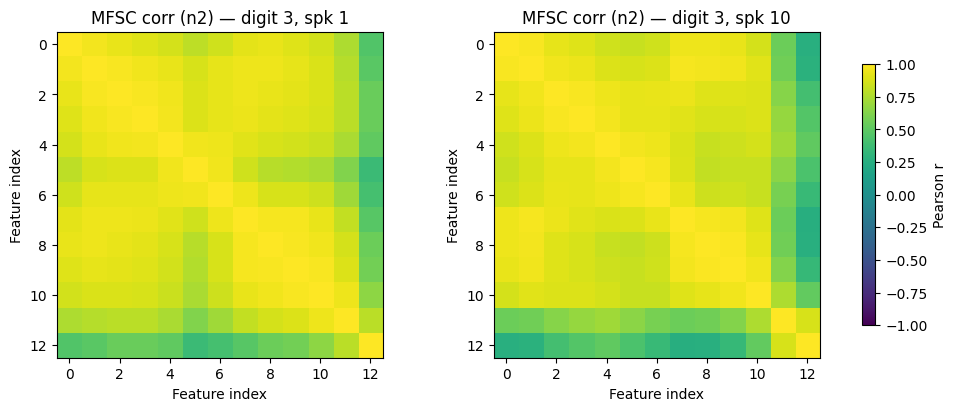

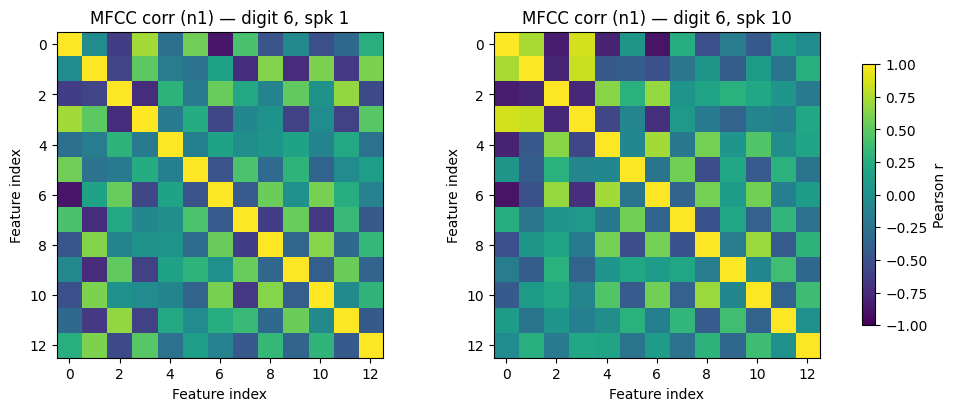

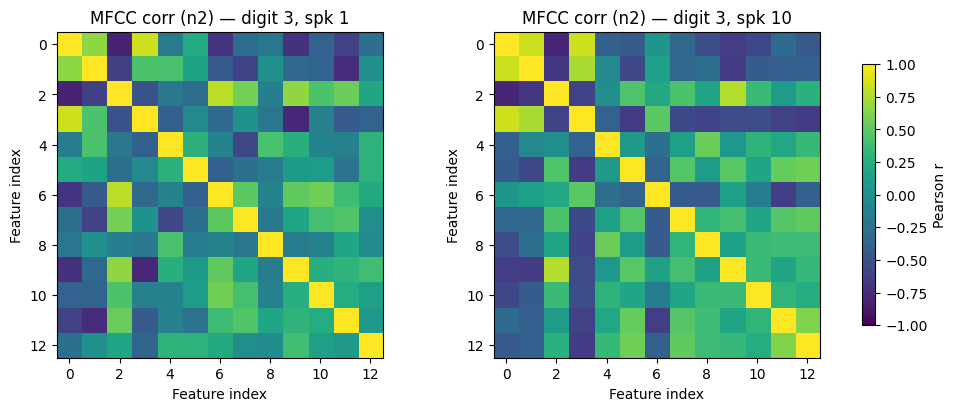

In [ ]:
# ==============================================================
# Step 4 — MFCC histograms (n1=6, n2=3) and MFSC vs MFCC correlation
#            using TWO utterances per digit from DIFFERENT speakers
# ==============================================================

import numpy as np
import matplotlib.pyplot as plt
import librosa
from typing import List, Tuple

# ---------------- Configuration (from student IDs) ----------------
n1, n2 = 6, 3  # digits chosen from the two student IDs (03121026, 03121023)

# ---------------- Utilities ----------------

def collect_mfcc_coeffs_for_digit(mfcc_seqs: List[np.ndarray],
                                  y_num: List[int],
                                  target_digit: int,
                                  coeff_idx: int) -> np.ndarray:
    """
    Gather one MFCC coefficient across all frames from all utterances of a target digit.
    Returns a 1-D array of values (concatenation across utterances and frames).
    """
    vals = [seq[:, coeff_idx] for seq, y in zip(mfcc_seqs, y_num) if int(y) == int(target_digit)]
    return np.concatenate(vals, axis=0) if vals else np.array([])

def choose_k_per_digit(y_num: List[int], speakers: List[str], digit: int, k: int = 2) -> List[int]:
    """
    Choose up to k utterance indices for the given digit from DISTINCT speakers.
    Falls back gracefully if less diversity is available.
    """
    seen = set()
    idxs = []
    for i, y in enumerate(y_num):
        if int(y) == int(digit):
            spk = speakers[i]
            if spk not in seen:
                idxs.append(i)
                seen.add(spk)
            if len(idxs) == k:
                break
    return idxs

def compute_mfsc_sequence(wav: np.ndarray,
                          sr: int,
                          n_mels: int = 13,
                          win_ms: int = 25,
                          hop_ms: int = 10,
                          center: bool = True) -> np.ndarray:
    """
    Compute MFSCs (Mel Filterbank Spectral Coefficients = log-mel energies, pre-DCT)
    with EXACT 25 ms window and 10 ms hop. Returns (T, n_mels).
    """
    win_length = int(round((win_ms / 1000.0) * sr))    # 25 ms → 400 @ 16 kHz
    hop_length = int(round((hop_ms / 1000.0) * sr))    # 10 ms → 160 @ 16 kHz
    n_fft = 1 << (win_length - 1).bit_length()         # pow2 ≥ 400 → 512

    S = librosa.feature.melspectrogram(
        y=wav, sr=sr,
        n_mels=n_mels,
        n_fft=n_fft, win_length=win_length, hop_length=hop_length,
        center=center, power=2.0
    )  # (n_mels, T)
    logS = np.log(S + 1e-10)
    return logS.T  # (T, n_mels)

def corr_matrix(features_TxD: np.ndarray) -> np.ndarray:
    """
    Compute D×D Pearson correlation across feature dims for a (T, D) matrix.
    If T < 2, returns NaNs.
    """
    if features_TxD.ndim != 2 or features_TxD.shape[0] < 2:
        D = features_TxD.shape[1] if features_TxD.ndim == 2 else 0
        return np.full((D, D), np.nan, dtype=float)
    return np.corrcoef(features_TxD, rowvar=False)

# ---------------- 4A. Histograms for MFCC1 and MFCC2 (n1 vs n2 over ALL utterances) ----------------

# Ensure MFCCs exist (from Step 3). If not, compute minimal MFCCs directly and
# keep EXACT 25/10 ms windowing to match the lab spec.
if 'mfcc_seqs' not in globals():
    win_length = int(round(0.025 * Fs))
    hop_length = int(round(0.010 * Fs))
    n_fft = 1 << (win_length - 1).bit_length()
    mfcc_seqs = [
        librosa.feature.mfcc(
            y=w, sr=Fs, n_mfcc=13,
            n_fft=n_fft, win_length=win_length, hop_length=hop_length
        ).T
        for w in wavs
    ]

mfcc1_n1 = collect_mfcc_coeffs_for_digit(mfcc_seqs, y_num, n1, coeff_idx=0)  # MFCC_1
mfcc2_n1 = collect_mfcc_coeffs_for_digit(mfcc_seqs, y_num, n1, coeff_idx=1)  # MFCC_2
mfcc1_n2 = collect_mfcc_coeffs_for_digit(mfcc_seqs, y_num, n2, coeff_idx=0)
mfcc2_n2 = collect_mfcc_coeffs_for_digit(mfcc_seqs, y_num, n2, coeff_idx=1)

# Print quick numeric summaries (helps the discussion in the markdown)
def summarize(name: str, arr: np.ndarray):
    return (name, float(np.mean(arr)), float(np.std(arr)), int(arr.size)) if arr.size else (name, np.nan, np.nan, 0)

summary_stats = [
    summarize(f"digit {n1} — MFCC1", mfcc1_n1),
    summarize(f"digit {n1} — MFCC2", mfcc2_n1),
    summarize(f"digit {n2} — MFCC1", mfcc1_n2),
    summarize(f"digit {n2} — MFCC2", mfcc2_n2),
]
print("Histogram summary (mean, std, count):")
for name, m, s, c in summary_stats:
    print(f"{name:20s} | mean={m:.4f} std={s:.4f} count={c}")

# Plot histograms (overlaid, per coefficient)
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].hist(mfcc1_n1, bins=60, density=True, alpha=0.6, label=f"digit {n1}")
axs[0].hist(mfcc1_n2, bins=60, density=True, alpha=0.6, label=f"digit {n2}")
axs[0].set_title("Histogram of MFCC 1")
axs[0].set_xlabel("Value")
axs[0].set_ylabel("Density")
axs[0].legend()

axs[1].hist(mfcc2_n1, bins=60, density=True, alpha=0.6, label=f"digit {n1}")
axs[1].hist(mfcc2_n2, bins=60, density=True, alpha=0.6, label=f"digit {n2}")
axs[1].set_title("Histogram of MFCC 2")
axs[1].set_xlabel("Value")
axs[1].set_ylabel("Density")
axs[1].legend()
plt.tight_layout()
plt.show()

# ---------------- 4B. MFSC vs MFCC correlation (TWO utterances per digit) ----------------

# Pick two utterances per digit with DISTINCT speakers (fallback as needed)
idxs_n1 = choose_k_per_digit(y_num, speakers, digit=n1, k=2)
idxs_n2 = choose_k_per_digit(y_num, speakers, digit=n2, k=2)

print() # empty line
print(f"Correlation analysis indices for n1={n1}: {idxs_n1} (speakers: {[speakers[i] for i in idxs_n1]})")
print(f"Correlation analysis indices for n2={n2}: {idxs_n2} (speakers: {[speakers[i] for i in idxs_n2]})")

# Compute correlation matrices for MFSC and MFCC for each selected utterance
def plot_corr_grid(indices: List[int], title_prefix: str, compute_feats_fn):
    """
    Plot a horizontal grid of correlation matrices (one per utterance index).
    """
    if not indices:
        print(f"Warning: no indices for {title_prefix}.")
        return
    cols = len(indices)
    fig, axs = plt.subplots(1, cols, figsize=(5 * cols, 4), constrained_layout=True)
    if cols == 1:
        axs = [axs]
    last_im = None
    for j, idx in enumerate(indices):
        feats_TxD = compute_feats_fn(idx)   # (T, D)
        C = corr_matrix(feats_TxD)
        last_im = axs[j].imshow(C, vmin=-1, vmax=1, aspect='equal')
        axs[j].set_title(f"{title_prefix} — digit {y_num[idx]}, spk {speakers[idx]}")
        axs[j].set_xlabel("Feature index")
        axs[j].set_ylabel("Feature index")
    fig.colorbar(last_im, ax=axs, shrink=0.8, label="Pearson r")
    plt.show()

# MFSC correlation (13-D, exact 25/10 ms)
plot_corr_grid(
    idxs_n1, "MFSC corr (n1)", lambda idx: compute_mfsc_sequence(wavs[idx], Fs, n_mels=13, win_ms=25, hop_ms=10)
)
plot_corr_grid(
    idxs_n2, "MFSC corr (n2)", lambda idx: compute_mfsc_sequence(wavs[idx], Fs, n_mels=13, win_ms=25, hop_ms=10)
)

# MFCC correlation (13-D) for the SAME utterances (to visualize DCT decorrelation)
plot_corr_grid(
    idxs_n1, "MFCC corr (n1)", lambda idx: mfcc_seqs[idx]
)
plot_corr_grid(
    idxs_n2, "MFCC corr (n2)", lambda idx: mfcc_seqs[idx]
)


### **Step 5 — Utterance-Level Aggregation and 2D Scatter**

#### **Goal**
Convert each utterance’s frame-level features into a **fixed-length vector** and visualize low-dimensional separability.  
For every utterance, we take the 39-D sequence from Step 3 (**13 MFCC + 13 Δ + 13 ΔΔ**) and compute **mean** and **standard deviation** over time → a **78-D** vector `[μ(39) | σ(39)]`.

---

#### **What the code does**
- Builds `X_stats ∈ ℝ^{N×78}` with labels `y ∈ {1,…,9}` by concatenating per-feature **means** and **stds** across frames.  
- Plots **dimension 0** vs **dimension 1**, i.e., **μ(MFCC₁)** vs **μ(MFCC₂)** (time means of the first two cepstral coefficients).  
  - Recall: MFCC₁ (C0) is largely energy/tilt-related; MFCC₂ reflects coarse spectral slope / formant spacing.

---

#### **How to read the figure**
- **X-axis:** μ(MFCC₁). This tends to vary with global energy/tilt → **weak class separation**.  
- **Y-axis:** μ(MFCC₂). Captures broad spectral shape → typically **more discriminative** than MFCC₁.  
- **Markers/legend:** Each digit (1–9) uses a distinct marker; cluster positions show where that digit’s utterances tend to lie.

---

#### **Observed results (from our plot)**
- **Overall overlap** is substantial using only μ(MFCC₁) and μ(MFCC₂) — expected for such a compact summary.  
- **μ(MFCC₂) separates better**: higher values are frequent for digits like **1** and **7**, whereas **6** often occupies lower μ(MFCC₂).  
- **Speaker/utterance variability** produces visible intra-class spread (both axes), consistent with multi-speaker data.  
- Net: this 2D view provides some intuition (especially from μ(MFCC₂)) but is **not linearly separable** across all digits.

---

#### **Answering the assignment’s intent**
- We produced the required **utterance-level vectors** (mean+std over the 39-D frames → 78-D) and visualized the **first two dimensions** (μ(MFCC₁), μ(MFCC₂)).  
- The figure demonstrates that **MFCC₂** carries **more discriminative information** than **MFCC₁**, while **two statistics alone are insufficient** for clean class separation.  
- This motivates the next steps (PCA to 2D/3D and downstream classifiers) to capture **richer structure** than what the two means alone can provide.


Utterances: 133, Feature dimension: 78 (expected 78)


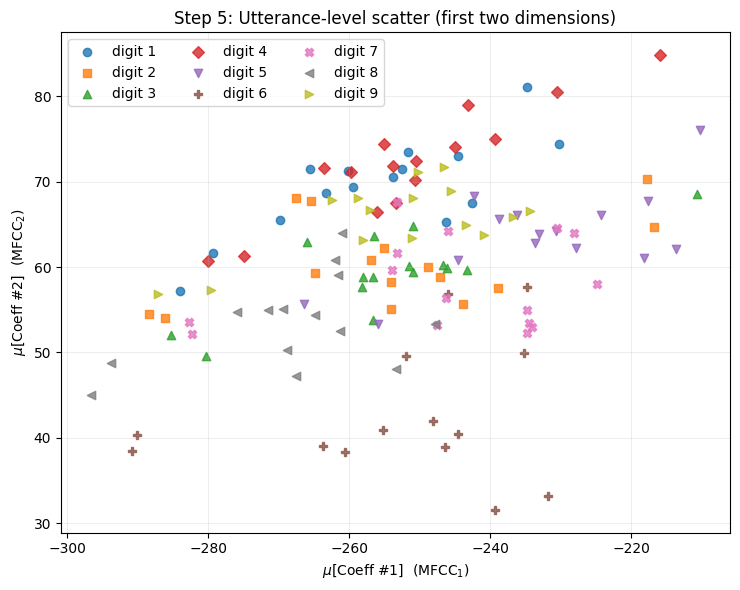

In [ ]:
# ==============================================================
# Step 5 — Utterance-level feature vectors (mean & std) and 2D scatter
# ==============================================================

import numpy as np
import matplotlib.pyplot as plt

# Ensure frame-level 39-D features exist (from Step 3); otherwise compute them.
if 'feats39_seqs' not in globals():
    mfcc_seqs, delta_seqs, delta2_seqs, feats39_seqs = extract_mfcc_and_deltas(wavs, Fs)

def aggregate_mean_std(seqs: List[np.ndarray]) -> np.ndarray:
    """
    Convert a list of frame sequences (T_i x D) to utterance-level vectors.
    For each utterance, compute mean and std over time for each of the D features,
    then concatenate [mean(0..D-1), std(0..D-1)] → (2D,).
    """
    X = []
    for F in seqs:                       # F: (T, D)
        mu = F.mean(axis=0)              # (D,)
        sd = F.std(axis=0, ddof=0)       # (D,)
        X.append(np.hstack([mu, sd]))    # (2D,)
    return np.asarray(X)                  # (N, 2D)

# Build utterance-level dataset: X has 78 dims when D=39
X_stats = aggregate_mean_std(feats39_seqs)   # shape: (N, 78)
y_labels = np.asarray(y_num)                 # integer digit labels 1..9
speakers_arr = np.asarray(speakers)

assert X_stats.shape[0] == y_labels.shape[0], "Mismatch: features and labels must have same N."
print(f"Utterances: {X_stats.shape[0]}, Feature dimension: {X_stats.shape[1]} (expected 78)")

# Scatter of the first two dimensions:
# With stacking order [MFCC(13) | Δ(13) | ΔΔ(13)], dims 0 and 1 correspond to MFCC1_mean and MFCC2_mean.
dims = (0, 1)

digits_unique = sorted(np.unique(y_labels).astype(int))
markers = ['o', 's', '^', 'D', 'v', 'P', 'X', '<', '>']  # 9 distinct markers for digits 1..9
plt.figure(figsize=(7.5, 6))
for i, d in enumerate(digits_unique):
    sel = (y_labels == d)
    plt.scatter(
        X_stats[sel, dims[0]],
        X_stats[sel, dims[1]],
        label=f"digit {d}",
        alpha=0.8,
        marker=markers[i % len(markers)],
        s=36
    )

plt.xlabel(r"$\mu$[Coeff #1]  (MFCC$_1$)")
plt.ylabel(r"$\mu$[Coeff #2]  (MFCC$_2$)")
plt.title("Step 5: Utterance-level scatter (first two dimensions)")
plt.legend(ncol=3, frameon=True)
plt.grid(True, linewidth=0.4, alpha=0.4)
plt.tight_layout()
plt.show()


### **Step 6 — PCA Dimensionality Reduction (2D & 3D)**

#### **Goal**
Apply **PCA** to the utterance-level features to obtain **2D** and **3D** visualizations and report the **explained variance** captured by the principal components, as requested in the PDF.

---

#### **Pipeline (what this cell does)**
- **Input:** `X_stats ∈ ℝ^{N×78}` (per-utterance `[μ(39) | σ(39)]` from Step 5) with digit labels `y`.
- **Standardize:** `StandardScaler` (zero mean, unit variance per feature).
- **PCA:** Fit `PCA(n_components=3)` on standardized data → project to **(PC1, PC2)** and **(PC1, PC2, PC3)**.
- **Plots:** 2D and 3D scatters colored/labeled by digit.
- **Report:** Print the **explained variance ratio (EVR)** per component and the **cumulative** EVR for 2D and 3D.

---

#### **What is EVR (Explained Variance Ratio)?**  
For PCA eigenvalues $\{\lambda_k\}$ of the (standardized) data covariance, the EVR of component $k$ is
$
\mathrm{EVR}_k \;=\; \frac{\lambda_k}{\sum_j \lambda_j}.
$
It is the **fraction of total variance** captured by principal component $k$. Across **all** components, EVRs sum to 1 (100%).

---

#### **What is cumulative EVR?**  
For the first $m$ components,
$
\mathrm{CumulativeEVR}(m) \;=\; \sum_{k=1}^{m} \mathrm{EVR}_k,
$
i.e., the **total fraction of variance preserved** by keeping the top $m$ PCs. It’s used to judge how many PCs are needed to retain a desired amount of information.

---

#### **Our run — explained variance**
- EVR per component: **PC1 = 12.54%**, **PC2 = 7.51%**, **PC3 = 6.33%**  
- **Cumulative (2D): 20.06%** | **Cumulative (3D): 26.39%**

#### **How to read the figures.**
- PCA axes are **unsupervised** directions of **maximal variance** in the standardized 78-D space.  
- Clear, tight clusters → stronger class structure; heavy overlap → limited separability by a linear unsupervised projection.

---

#### **Observations (from our plots)**
- **2D (PC1–PC2):** modest grouping tendencies but **substantial overlap** among digits.  
- **3D (PC1–PC3):** small improvement, yet **classes still overlap** notably.  
- Interpretation: **variance is spread across many dimensions**; the top 2–3 PCs capture only ~20–26% and do **not** align perfectly with digit boundaries (expected for unsupervised PCA).

#### **Notes for the report**
- We applied PCA to **2D and 3D**, reported **EVR** and **cumulative EVR**, and discussed that low-dimensional PCA views provide **limited separability**.  
- For **classification** (Step 7), we will use the **full 78-D features** (with train-only scaling), or consider **supervised** projections (e.g., LDA) if dimensionality reduction is desired.


Explained variance ratio per component (PC1..PC3): [0.12543578 0.07514068 0.06332982]
Cumulative (2D): 0.2006
Cumulative (3D): 0.2639


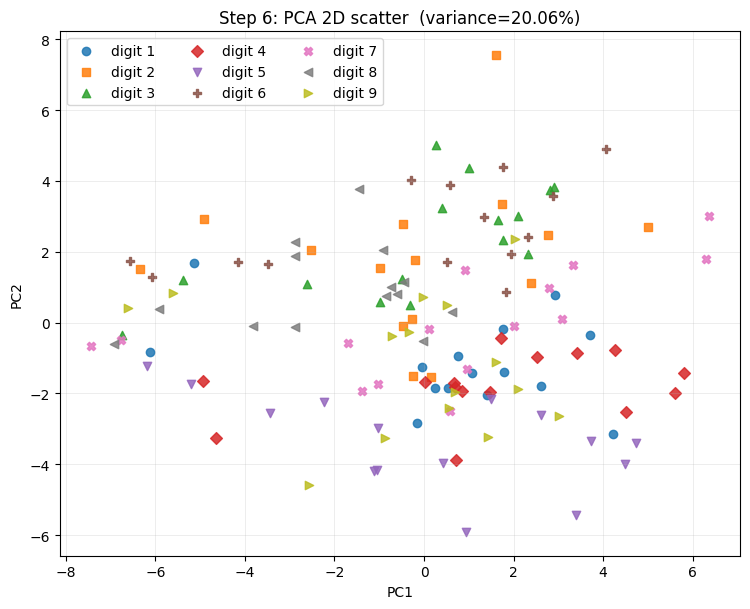

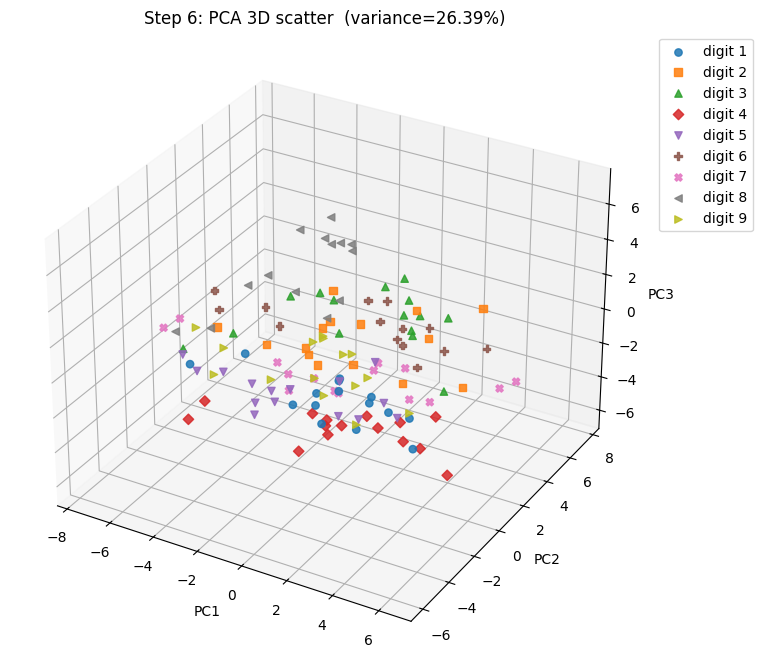

In [ ]:
# ==============================================================
# Step 6 — PCA dimensionality reduction (2D & 3D) and scatter plots
# (polished: deterministic PCA solver, extra safety checks)
# ==============================================================

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# ---- Ensure utterance-level 78-D vectors exist (from Step 5); otherwise build them. ----
if 'X_stats' not in globals():
    if 'feats39_seqs' not in globals():
        # Build 39-D frame features if missing (uses Step-3 function)
        mfcc_seqs, delta_seqs, delta2_seqs, feats39_seqs = extract_mfcc_and_deltas(wavs, Fs)

    def aggregate_mean_std(seqs):
        """Aggregate each (T, 39) sequence to a (78,) vector = [means(39) | stds(39)]."""
        X = []
        for F in seqs:                   # F: (T, 39)
            mu = F.mean(axis=0)          # (39,)
            sd = F.std(axis=0, ddof=0)   # (39,)
            X.append(np.hstack([mu, sd]))# (78,)
        return np.asarray(X)             # (N, 78)

    X_stats = aggregate_mean_std(feats39_seqs)   # (N, 78)
    y_labels = np.asarray(y_num)                 # (N,)
    speakers_arr = np.asarray(speakers)

# Basic safety: shape should be (N, 78).
assert X_stats.ndim == 2 and X_stats.shape[1] == 78, "Expected (N, 78) utterance-level features."

# ------------------------------------------------------------------
# Standardize features before PCA (zero mean / unit variance per dim)
# NOTE: For visualization/exploration Step 6, fitting on ALL data is fine.
#       If PCA becomes part of a classification pipeline, fit on TRAIN only.
# ------------------------------------------------------------------
scaler = StandardScaler()
X_std = scaler.fit_transform(X_stats)

# ------------------------------------------------------------------
# PCA fit (3 comps). Use a deterministic solver; 'full' is exact SVD.
# ------------------------------------------------------------------
pca = PCA(n_components=3, svd_solver="full")  # random_state not used by 'full'
X_pca_3d = pca.fit_transform(X_std)           # (N, 3)
X_pca_2d = X_pca_3d[:, :2]                    # (N, 2)

# Report explained variance
evr = pca.explained_variance_ratio_           # (3,)
print("Explained variance ratio per component (PC1..PC3):", evr)
print(f"Cumulative (2D): {evr[:2].sum():.4f}")
print(f"Cumulative (3D): {evr[:3].sum():.4f}")

# ------------------------------------------------------------------
# 2D scatter (PC1 vs PC2)
# ------------------------------------------------------------------
digits_unique = sorted(np.unique(y_labels).astype(int))
markers = ['o', 's', '^', 'D', 'v', 'P', 'X', '<', '>']  # 9 markers
plt.figure(figsize=(7.6, 6.2))
for i, d in enumerate(digits_unique):
    sel = (y_labels == d)
    plt.scatter(
        X_pca_2d[sel, 0], X_pca_2d[sel, 1],
        marker=markers[i % len(markers)],
        s=36, alpha=0.85, label=f"digit {d}"
    )
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"Step 6: PCA 2D scatter  (variance={evr[:2].sum():.2%})")
plt.legend(ncol=3, frameon=True)
plt.grid(True, linewidth=0.4, alpha=0.4)
plt.tight_layout()
plt.show()

print()  # empty line

# ------------------------------------------------------------------
# 3D scatter (PC1, PC2, PC3)
# ------------------------------------------------------------------
fig = plt.figure(figsize=(8.2, 6.6), constrained_layout=True)
ax = fig.add_subplot(111, projection='3d')
for i, d in enumerate(digits_unique):
    sel = (y_labels == d)
    ax.scatter(
        X_pca_3d[sel, 0], X_pca_3d[sel, 1], X_pca_3d[sel, 2],
        marker=markers[i % len(markers)], s=28, alpha=0.85, label=f"digit {d}"
    )
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title(f"Step 6: PCA 3D scatter  (variance={evr[:3].sum():.2%})")
ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1.0))
plt.show()


### **Step 7 (main) — Baseline classifiers, metrics, and error analysis**

**What this cell does**
- **Split & normalize:** Stratified **70/30** train/test split; **StandardScaler** fitted on **train** only and applied to **test**.
- **Train six baselines:**  
  1) **Bayesian (full-cov)** with ridge-regularized class covariances  
  2) **Gaussian Naive Bayes** (diagonal Σ)  
  3) **SVM (RBF)**  
  4) **k-NN (k=5)**  
  5) **Logistic Regression** (multinomial)  
  6) **Decision Tree** (uses raw features; trees don’t need scaling)
- **Report:** Accuracy table + bar chart.
- **Error analysis:** **Confusion matrix + classification report** for the **best** and **worst** models.

---

#### **Metric definitions**
Let TP, FP, FN be per-class counts; “support” is the number of **true** test samples of that class.

- **Accuracy:** $\frac{\text{# correct predictions}}{\text{# all samples}}$.
- **Precision (per class):** $\frac{\mathrm{TP}}{\mathrm{TP}+\mathrm{FP}}$ — when the model predicts this class, how often it is correct.
- **Recall (per class):** $\frac{\mathrm{TP}}{\mathrm{TP}+\mathrm{FN}}$ — of the true items of this class, how many the model found.
- **F1 (per class):** harmonic mean of precision and recall, $\frac{2PR}{P+R}$.
- **Support:** number of test instances for that class.
- **Macro avg:** unweighted mean over classes.
- **Weighted avg:** mean over classes **weighted by support**.

---

#### **Test accuracies (78-D utterance features)**
- **Bayesian (full-cov): 0.825**  ← best  
- **SVM (RBF): 0.800**  
- **Logistic Regression: 0.750**  
- **GaussianNB: 0.575**  
- **k-NN (k=5): 0.525**  
- **Decision Tree: 0.275**  ← worst

**Interpretation (why this ordering makes sense):**
- Full-cov Bayes benefits from modeling **feature correlations** (our 78-D vectors are correlated), with ridge regularization stabilizing Σ estimates.  
- SVM and Logistic are strong linear/nonlinear baselines after scaling.  
- GaussianNB assumes independence → lower accuracy here.  
- k-NN is sensitive to scale and local density in small-N regimes.  
- The un-tuned Decision Tree **overfits** and generalizes poorly on this small dataset.

---

#### **Best model — Bayesian (full-cov) @ 0.825**
Key per-class results (precision / recall from the report):
- Perfect classes: **4, 6, 8** (precision=recall=1.00); note the **small supports** (4–5 each).
- **Digit 1:** precision **1.00**, recall **0.40** → very **conservative** predictions for “1”: few false positives, **many misses** (true 1’s labeled as other digits).
- **Digit 7:** precision **0.625**, recall **1.00** → finds all 7’s but **over-predicts** 7 (false positives).
- Others (2, 3, 5, 9): decent F1 (0.67–1.00) with small supports.

**Confusion matrix (visual read):** mostly diagonal; errors concentrate in **digit 1** (missed) and **digit 7** (extra hits). This matches the precision/recall trade-offs above.

---

#### **Worst model — Decision Tree @ 0.275**
- Many classes show **near-zero** precision/recall (e.g., 1, 2, 5, 9).  
- Slightly better on **4** and **6** (F1 ≈ 0.67), but overall **heavy off-diagonal** mass in the confusion matrix.
- Likely causes: **high variance** with limited training data per class, lack of pruning/tuning, and no shared structure learning across classes.



Step 7 — Test accuracies (baseline 78-D features):
Model                      Accuracy
------------------------  ---------
Bayesian (full-cov)          0.8250
SVM (RBF)                    0.8000
Logistic Regression          0.7500
Naive Bayes (GaussianNB)     0.5750
k-NN (k=5)                   0.5250
Decision Tree                0.2750



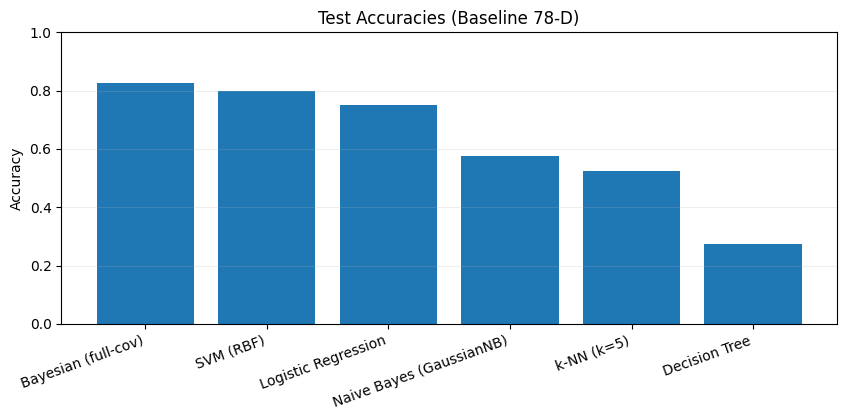

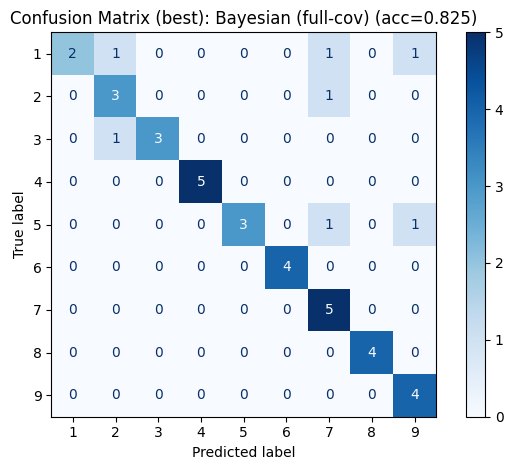


Classification report for best model: Bayesian (full-cov)

              precision    recall  f1-score   support

           1      1.000     0.400     0.571         5
           2      0.600     0.750     0.667         4
           3      1.000     0.750     0.857         4
           4      1.000     1.000     1.000         5
           5      1.000     0.600     0.750         5
           6      1.000     1.000     1.000         4
           7      0.625     1.000     0.769         5
           8      1.000     1.000     1.000         4
           9      0.667     1.000     0.800         4

    accuracy                          0.825        40
   macro avg      0.877     0.833     0.824        40
weighted avg      0.880     0.825     0.819        40



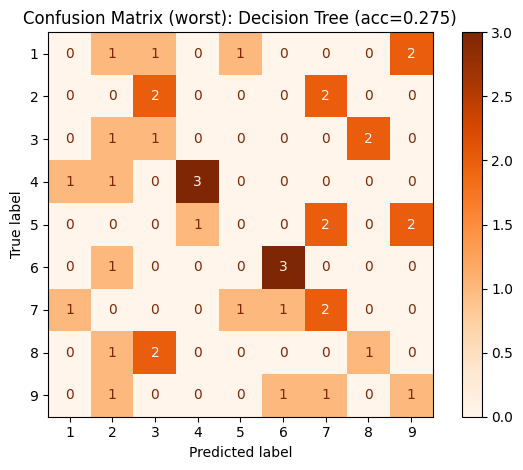



Classification report for worst model: Decision Tree

              precision    recall  f1-score   support

           1      0.000     0.000     0.000         5
           2      0.000     0.000     0.000         4
           3      0.167     0.250     0.200         4
           4      0.750     0.600     0.667         5
           5      0.000     0.000     0.000         5
           6      0.600     0.750     0.667         4
           7      0.286     0.400     0.333         5
           8      0.333     0.250     0.286         4
           9      0.200     0.250     0.222         4

    accuracy                          0.275        40
   macro avg      0.260     0.278     0.264        40
weighted avg      0.259     0.275     0.262        40



In [ ]:
# ==============================================================
# Step 7 (main) — Train/Test split, normalization, and classifiers
#   - Custom Gaussian Bayes (full covariance; regularized)
#   - Gaussian Naive Bayes
#   - SVM (RBF)
#   - k-NN
#   - Logistic Regression
#   - Decision Tree
#   + Summary table, accuracy bar chart
#   + Confusion matrices and classification reports for BEST and WORST models
# ==============================================================

import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# ---------------------------------------------------------
# Ensure utterance-level features exist (N x 78) and labels (N,)
# If needed, derive them from Step 3 outputs (feats39_seqs)
# ---------------------------------------------------------
if 'X_stats' not in globals():
    if 'feats39_seqs' not in globals():
        # Build 39-D frame features if missing (uses Step-3 function and exact 25/10 ms)
        mfcc_seqs, delta_seqs, delta2_seqs, feats39_seqs = extract_mfcc_and_deltas(wavs, Fs)

    def aggregate_mean_std(seqs):
        """
        Aggregate each frame sequence (T, 39) to a (78,) vector:
          [ means(39) | stds(39) ] across time.
        """
        X = []
        for F in seqs:                     # F: (T, 39)
            mu = F.mean(axis=0)            # (39,)
            sd = F.std(axis=0, ddof=0)     # (39,)
            X.append(np.hstack([mu, sd]))  # (78,)
        return np.asarray(X)               # (N, 78)

    X_stats = aggregate_mean_std(feats39_seqs)  # (N, 78)
    y_labels = np.asarray(y_num)                # (N,)
    speakers_arr = np.asarray(speakers)

# ---------------------------------------------------------
# Custom Gaussian Bayes (full class covariance; ridge-regularized)
# ---------------------------------------------------------
@dataclass
class FullCovGaussianBayes:
    reg: float = 1e-3  # ridge regularization for covariance matrices

    def fit(self, X: np.ndarray, y: np.ndarray):
        """
        Fit a class-conditional Gaussian model with a full covariance per class.
        A small 'reg' * I is added to each covariance for numerical stability.
        """
        self.classes_ = np.unique(y)
        D = X.shape[1]
        self.priors_: Dict[int, float] = {}
        self.means_: Dict[int, np.ndarray] = {}
        self.cov_inv_: Dict[int, np.ndarray] = {}
        self.logdet_: Dict[int, float] = {}

        for c in self.classes_:
            Xc = X[y == c]
            self.priors_[int(c)] = Xc.shape[0] / X.shape[0]
            mu = Xc.mean(axis=0)
            # Full covariance with ridge (ensures positive-definiteness)
            Sigma = np.cov(Xc, rowvar=False) + self.reg * np.eye(D)
            self.means_[int(c)] = mu

            # Robust inverse + log-determinant handling
            sign, logdet = np.linalg.slogdet(Sigma)
            if sign <= 0:
                # Fallback to pseudo-inverse and eigenvalue-based logdet if needed
                Sigma_inv = np.linalg.pinv(Sigma)
                logdet = np.log(np.clip(np.linalg.eigvalsh(Sigma), 1e-12, None)).sum()
            else:
                Sigma_inv = np.linalg.inv(Sigma)

            self.cov_inv_[int(c)] = Sigma_inv
            self.logdet_[int(c)] = float(logdet)

        self._const_ = -0.5 * D * np.log(2.0 * np.pi)
        return self

    def _logpdf(self, x: np.ndarray, c: int) -> float:
        """
        Log-pdf of a Gaussian N(mu_c, Sigma_c) up to an additive constant;
        uses precomputed inverse and log-determinant.
        """
        mu = self.means_[c]
        Si = self.cov_inv_[c]
        diff = x - mu
        quad = diff @ Si @ diff  # quadratic form
        return self._const_ - 0.5 * (self.logdet_[c] + quad)

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predict the class with maximum posterior (log prior + log-likelihood).
        """
        preds = []
        for x in X:
            scores = [np.log(self.priors_[int(c)]) + self._logpdf(x, int(c)) for c in self.classes_]
            preds.append(self.classes_[int(np.argmax(scores))])
        return np.asarray(preds)

# ---------------------------------------------------------
# Split (70/30 stratified), scale (fit on train, apply to both)
# ---------------------------------------------------------
X = X_stats
y = y_labels

indices = np.arange(len(y))
idx_train, idx_test = train_test_split(
    indices, test_size=0.30, stratify=y, random_state=0  # reproducible, stratified
)

X_train, X_test = X[idx_train], X[idx_test]
y_train, y_test = y[idx_train], y[idx_test]

# Keep raw copies for models that don't need scaling (e.g., Decision Tree)
X_train_raw, X_test_raw = X_train.copy(), X_test.copy()

# Standardize for models that benefit from scaling
scaler_main = StandardScaler()
X_train_std = scaler_main.fit_transform(X_train)
X_test_std  = scaler_main.transform(X_test)

# ---------------------------------------------------------
# Train/evaluate models
# ---------------------------------------------------------
results_main: Dict[str, float] = {}
models_fitted: Dict[str, object] = {}

# 1) Bayesian classifier (full-cov Gaussian)
bayes = FullCovGaussianBayes(reg=1e-2).fit(X_train_std, y_train)
acc = accuracy_score(y_test, bayes.predict(X_test_std))
results_main["Bayesian (full-cov)"] = acc
models_fitted["Bayesian (full-cov)"] = bayes

# 2) Naive Bayes (diagonal covariance assumption)
gnb = GaussianNB().fit(X_train_std, y_train)
acc = accuracy_score(y_test, gnb.predict(X_test_std))
results_main["Naive Bayes (GaussianNB)"] = acc
models_fitted["Naive Bayes (GaussianNB)"] = gnb

# 3) SVM with RBF kernel
svm = SVC(kernel='rbf', C=10.0, gamma='scale', random_state=0).fit(X_train_std, y_train)
acc = accuracy_score(y_test, svm.predict(X_test_std))
results_main["SVM (RBF)"] = acc
models_fitted["SVM (RBF)"] = svm

# 4) k-NN
knn = KNeighborsClassifier(n_neighbors=5).fit(X_train_std, y_train)
acc = accuracy_score(y_test, knn.predict(X_test_std))
results_main["k-NN (k=5)"] = acc
models_fitted["k-NN (k=5)"] = knn

# 5) Logistic Regression (multinomial by default)
lr = LogisticRegression(max_iter=2000, random_state=0).fit(X_train_std, y_train)
acc = accuracy_score(y_test, lr.predict(X_test_std))
results_main["Logistic Regression"] = acc
models_fitted["Logistic Regression"] = lr

# 6) Decision Tree (uses raw features; scaling not needed)
dt = DecisionTreeClassifier(random_state=0)
dt.fit(X_train_raw, y_train)
acc = accuracy_score(y_test, dt.predict(X_test_raw))
results_main["Decision Tree"] = acc
models_fitted["Decision Tree"] = dt

# ---------------------------------------------------------
# Formatted summary table (aligned) + accuracy bar chart
# ---------------------------------------------------------
print("Step 7 — Test accuracies (baseline 78-D features):")
rows = sorted(results_main.items(), key=lambda kv: -kv[1])  # sort by accuracy desc
name_w = max(len(name) for name, _ in rows)
print(f"{'Model':<{name_w}}  {'Accuracy':>9}")
print(f"{'-'*name_w}  {'-'*9}")
for name, acc in rows:
    print(f"{name:<{name_w}}  {acc:>9.4f}")

print() # Blank line

plt.figure(figsize=(8.6, 4.3))
model_names = [n for n, _ in rows]
accs = [a for _, a in rows]
plt.bar(range(len(model_names)), accs)
plt.xticks(range(len(model_names)), model_names, rotation=20, ha='right')
plt.ylabel("Accuracy")
plt.title("Test Accuracies (Baseline 78-D)")
plt.ylim(0, 1.0)
plt.grid(axis='y', alpha=0.3, linewidth=0.5)
plt.tight_layout()
plt.show()

print() # Blank line between plots

# ---------------------------------------------------------
# Confusion matrix + classification report for the BEST model
# ---------------------------------------------------------
best_name, best_acc = rows[0]                 # top accuracy
best_model = models_fitted[best_name]
# Use standardized features for all except Decision Tree
Xbest_test = X_test_std if best_name != "Decision Tree" else X_test_raw

y_pred_best = best_model.predict(Xbest_test)

labels_sorted = sorted(np.unique(y_test))
cm_best = confusion_matrix(y_test, y_pred_best, labels=labels_sorted)
disp_best = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=labels_sorted)
disp_best.plot(cmap="Blues", values_format="d")
plt.title(f"Confusion Matrix (best): {best_name} (acc={best_acc:.3f})")
plt.tight_layout()
plt.show()

# Classification report (BEST)
print(f"\nClassification report for best model: {best_name}\n")
print(classification_report(y_test, y_pred_best, digits=3))

# ---------------------------------------------------------
# Confusion matrix + classification report for the WORST model
# ---------------------------------------------------------
worst_name, worst_acc = rows[-1]              # lowest accuracy
worst_model = models_fitted[worst_name]
# Use standardized features for all except Decision Tree
Xworst_test = X_test_std if worst_name != "Decision Tree" else X_test_raw

y_pred_worst = worst_model.predict(Xworst_test)

cm_worst = confusion_matrix(y_test, y_pred_worst, labels=labels_sorted)
disp_worst = ConfusionMatrixDisplay(confusion_matrix=cm_worst, display_labels=labels_sorted)
disp_worst.plot(cmap="Oranges", values_format="d")
plt.title(f"Confusion Matrix (worst): {worst_name} (acc={worst_acc:.3f})")
plt.tight_layout()
plt.show()

print() # Blank line between plots

# Classification report (WORST)
print(f"\nClassification report for worst model: {worst_name}\n")
print(classification_report(y_test, y_pred_worst, digits=3))

# ---------------------------------------------------------
# Expose artifacts for potential reuse in the bonus step
# ---------------------------------------------------------
step7_results_main = results_main
step7_idx_train = idx_train
step7_idx_test = idx_test
step7_random_state = 0


### **Step 7 (Bonus) — Augmenting with Extra Acoustic Descriptors (90-D) and Comparison**

**What the code adds.**  
For each waveform we compute frame-level **extra descriptors**, then aggregate **mean** and **std** per utterance and concatenate with the 78-D baseline → **90-D** vectors:
- **Zero-Crossing Rate (ZCR):** sign-change rate (voicing/noisiness cue).  
- **Spectral Centroid:** spectrum “center of mass” (brightness).  
- **Spectral Bandwidth:** spread around the centroid (dispersion).  
- **Spectral Rolloff (0.85):** freq. below which 85% of energy lies.  
- **RMS Energy:** short-term amplitude/energy.  
- **Spectral Flatness:** tonality vs noise-likeness (flat ≈ noise-like).

**Framing/parameters.** `win_ms=25`, `hop_ms=10` (aligned with MFCCs); `n_fft` = next power-of-two ≥ frame length (FFT efficiency); `roll_percent=0.85`.  
**Protocol.** We **reuse the exact same train/test split** as Step 7 (main). Features are **standardized on train only** (Decision Tree uses raw features). We retrain the same models and compare **baseline (78-D)** vs **augmented (90-D)**.

---

#### **Your results (test accuracy)**
| Model | Baseline | Augmented | Δ (Aug−Base) |
|---|---:|---:|---:|
| Bayesian (full-cov) | 0.8250 | **0.8500** | **+0.0250** |
| SVM (RBF) | 0.8000 | **0.8500** | **+0.0500** |
| Logistic Regression | 0.7500 | **0.8250** | **+0.0750** |
| Naive Bayes (GaussianNB) | 0.5750 | **0.6250** | **+0.0500** |
| k-NN (k=5) | 0.5250 | **0.5500** | **+0.0250** |
| Decision Tree | 0.2750 | **0.4000** | **+0.1250** |

- **Best overall (augmented):** **SVM (RBF)** and **Bayesian (full-cov)** tie at **0.8500**.  
- **Largest absolute gain:** **Decision Tree** (+0.1250), consistent with trees benefiting from additional informative dimensions.  
- **Average gain across models:** ≈ **+0.058** (≈ +5.8 percentage points).

---

#### **Why these gains make sense**
- The six descriptors add **complementary spectral/energy cues** not fully captured by cepstra and their deltas.  
- **Linear/nonlinear discriminative models** (LogReg, SVM) leverage the richer standardized space → consistent improvements.  
- **GaussianNB** still assumes diagonal covariance; it improves a bit, but less than full-cov Bayes which can model the **new inter-feature correlations**.  
- **k-NN** improves modestly (distance-based method in higher-D, small-N).  
- **Decision Tree** gains most but remains the weakest overall—variance is still high without tuning/pruning.

---

#### **Notes for the report**
- The comparison is **apples-to-apples** (same split, same scaling protocol).  
- Improvements are meaningful but the test set is small (≈4–5 samples per class); report results cautiously or average over multiple splits for robustness.  
- Takeaway: **Energy and spectral-shape descriptors** materially enhance discriminability for isolated-digit recognition in this dataset; the **best augmented models** reach **≈85%** accuracy without hyperparameter tuning.



Step 7 — Test accuracies: baseline 78-D vs augmented 90-D
Model                        Base      Aug        Δ
------------------------  -------  -------  -------
Bayesian (full-cov)        0.8250   0.8500  +0.0250
SVM (RBF)                  0.8000   0.8500  +0.0500
Logistic Regression        0.7500   0.8250  +0.0750
Naive Bayes (GaussianNB)   0.5750   0.6250  +0.0500
k-NN (k=5)                 0.5250   0.5500  +0.0250
Decision Tree              0.2750   0.4000  +0.1250



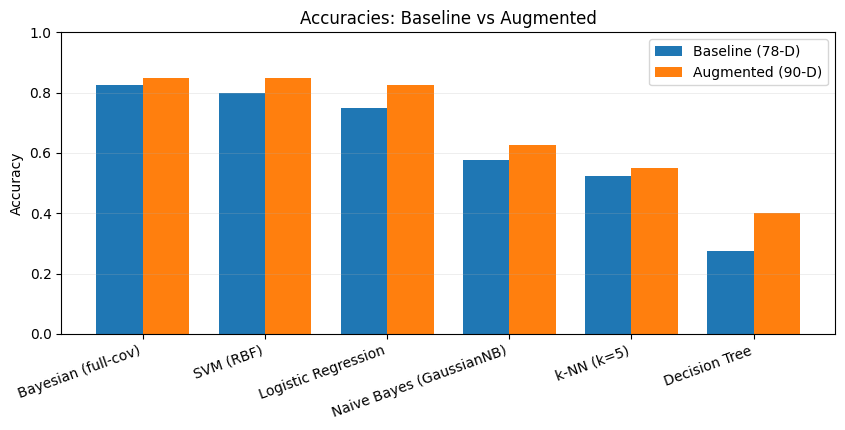

In [ ]:
# ==============================================================
# Step 7 (bonus) — Extra features per utterance + comparison
#   Extra frame descriptors (per utterance: mean & std):
#     - ZCR, Spectral Centroid, Bandwidth, Rolloff(0.85),
#       RMS Energy, Spectral Flatness
#   Total extra dims = 6 × 2 = 12 → augmented X ∈ ℝ^{N×90}
#   + Summary table and comparison diagram (baseline vs augmented)
# ==============================================================

import numpy as np
import matplotlib.pyplot as plt
import librosa

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

def aggregate_extra_features(wavs, sr, win_ms=25, hop_ms=10):
    """
    Compute extra frame-level descriptors with 25 ms / 10 ms analysis
    and aggregate (mean, std) per utterance → (N, 12).
    """
    hop_length = int(round((hop_ms / 1000.0) * sr))     # 10 ms @ 16 kHz → 160
    win_length = int(round((win_ms / 1000.0) * sr))     # 25 ms @ 16 kHz → 400
    n_fft = 1 << (win_length - 1).bit_length()          # power-of-two ≥ win_length → 512

    extra_vecs = []
    for w in wavs:
        # Each returns shape (~1, T). Squeeze to (T,) for aggregation.
        zcr      = librosa.feature.zero_crossing_rate(w, frame_length=win_length, hop_length=hop_length).squeeze()
        centroid = librosa.feature.spectral_centroid(y=w, sr=sr, n_fft=n_fft, hop_length=hop_length).squeeze()
        bandwidth= librosa.feature.spectral_bandwidth(y=w, sr=sr, n_fft=n_fft, hop_length=hop_length).squeeze()
        rolloff  = librosa.feature.spectral_rolloff(y=w, sr=sr, roll_percent=0.85, n_fft=n_fft, hop_length=hop_length).squeeze()
        rms      = librosa.feature.rms(y=w, frame_length=win_length, hop_length=hop_length).squeeze()
        flat     = librosa.feature.spectral_flatness(y=w, n_fft=n_fft, hop_length=hop_length).squeeze()

        feats = []
        for arr in (zcr, centroid, bandwidth, rolloff, rms, flat):
            a = np.asarray(arr, dtype=np.float64)
            feats.extend([a.mean(), a.std(ddof=0)])     # (mean, std) per descriptor
        extra_vecs.append(np.asarray(feats, dtype=np.float32))  # length 12
    return np.vstack(extra_vecs)  # (N, 12)

# ------------------ Build augmented representation (N x 90) ------------------
X_extra = aggregate_extra_features(wavs, Fs)
X_aug = np.hstack([X_stats, X_extra])

# Reuse the exact same split as the main cell (indices captured there)
idx_train = step7_idx_train
idx_test  = step7_idx_test

X_train_aug, X_test_aug = X_aug[idx_train], X_aug[idx_test]
y_train, y_test = y_labels[idx_train], y_labels[idx_test]

# Standardize augmented features for models that benefit from scaling
scaler_aug = StandardScaler()
X_train_aug_std = scaler_aug.fit_transform(X_train_aug)
X_test_aug_std  = scaler_aug.transform(X_test_aug)

# ------------------ Train the same suite of models on augmented features ------------------
results_bonus: Dict[str, float] = {}

# Full-cov Bayesian (uses standardized features)
bayes_aug = FullCovGaussianBayes(reg=1e-2).fit(X_train_aug_std, y_train)
results_bonus["Bayesian (full-cov)"] = accuracy_score(y_test, bayes_aug.predict(X_test_aug_std))

# GaussianNB (standardized)
gnb_aug = GaussianNB().fit(X_train_aug_std, y_train)
results_bonus["Naive Bayes (GaussianNB)"] = accuracy_score(y_test, gnb_aug.predict(X_test_aug_std))

# SVM RBF (standardized)
svm_aug = SVC(kernel='rbf', C=10.0, gamma='scale', random_state=step7_random_state).fit(X_train_aug_std, y_train)
results_bonus["SVM (RBF)"] = accuracy_score(y_test, svm_aug.predict(X_test_aug_std))

# k-NN (standardized)
knn_aug = KNeighborsClassifier(n_neighbors=5).fit(X_train_aug_std, y_train)
results_bonus["k-NN (k=5)"] = accuracy_score(y_test, knn_aug.predict(X_test_aug_std))

# Logistic Regression (standardized)
lr_aug = LogisticRegression(max_iter=2000, random_state=step7_random_state).fit(X_train_aug_std, y_train)
results_bonus["Logistic Regression"] = accuracy_score(y_test, lr_aug.predict(X_test_aug_std))

# (ADDED) Decision Tree — like the main step, use RAW features (no scaling)
dt_aug = DecisionTreeClassifier(random_state=step7_random_state).fit(X_train_aug, y_train)
results_bonus["Decision Tree"] = accuracy_score(y_test, dt_aug.predict(X_test_aug))

# ------------------ Aligned comparison table: baseline vs augmented (+Δ) ------------------
print("\nStep 7 — Test accuracies: baseline 78-D vs augmented 90-D")
rows_keys = sorted(step7_results_main.keys(), key=lambda k: -step7_results_main[k])
name_w = max(len(k) for k in rows_keys)
print(f"{'Model':<{name_w}}  {'Base':>7}  {'Aug':>7}  {'Δ':>7}")
print(f"{'-'*name_w}  {'-'*7}  {'-'*7}  {'-'*7}")

for name in rows_keys:
    acc_base = step7_results_main[name]
    acc_aug  = results_bonus.get(name, np.nan)
    delta    = acc_aug - acc_base if np.isfinite(acc_aug) else np.nan
    print(f"{name:<{name_w}}  {acc_base:>7.4f}  {acc_aug:>7.4f}  {delta:>+7.4f}")

print() # blank line

# ------------------ Diagram: paired bar chart (baseline vs augmented) ------------------
plt.figure(figsize=(8.6, 4.4))
x = np.arange(len(rows_keys))
base_vals = [step7_results_main[k] for k in rows_keys]
# (ROBUST) use .get with np.nan to avoid KeyError if a model is missing from results_bonus
aug_vals  = [results_bonus.get(k, np.nan) for k in rows_keys]
w = 0.38
plt.bar(x - w/2, base_vals, width=w, label="Baseline (78-D)")
plt.bar(x + w/2, aug_vals,  width=w, label="Augmented (90-D)")
plt.xticks(x, rows_keys, rotation=20, ha='right')
plt.ylabel("Accuracy")
plt.title("Accuracies: Baseline vs Augmented")
plt.ylim(0, 1.0)
plt.legend()
plt.grid(axis='y', alpha=0.3, linewidth=0.5)
plt.tight_layout()
plt.show()


### **Step 8 — RNN/GRU/LSTM on sin→cos: dataset, models, training, and results**

**What we implement (per PDF).**  
We generate short, uniformly sampled sequences from a sine wave and learn to predict the corresponding cosine at the **same timestamps**. We train **three recurrent models**—vanilla **RNN(tanh)**, **GRU**, and **LSTM**—and compare them using **MSE** on validation/test sets and qualitative plots.

---

#### **Dataset and design choices**

- **Signal model.**

  For each sequence $n$ with random start phase $\phi_n \sim \mathcal{U}[0,2\pi)$:

  $
  x_{n,k}=\sin\!\big(\phi_n+\omega k\Delta t\big), \qquad
  y_{n,k}=\cos\!\big(\phi_n+\omega k\Delta t\big),
  $

  where
  
  $\omega=2\pi f$, $f=40\text{ Hz}$, length $L=10$, and **fixed** $\Delta t=1\,\text{ms}$, $1\text{ kHz}$ sampling.
- **Why these numbers.**

  $\mathbf{f=40\text{ Hz}\Rightarrow T=25\,\text{ms}}$. Our 10-point window spans $10\,\text{ms}\approx0.4T$: short but sufficient to infer phase. Sampling is far above Nyquist (80 Hz), so no aliasing.

---

* **Split.** $N=4096$ total sequences $\rightarrow$ **64% train / 16% val / 20% test** (deterministic slicing).
* **Why a recurrent model?** Since $\cos(\theta)=\sin(\theta+\pi/2)$ and $\Delta t\neq T/4=6.25\,\text{ms}$, this is **not** a trivial time shift across indices. The model must use the **temporal context** in $x_{n,0:L}$ to infer the phase and produce the correct $y_{n,0:L}$.

---

#### **Model architecture (identical head for all three)**

- **Backbone:** one recurrent block with `batch_first=True` and hidden size **32**:
  - **RNN(tanh)** (no gates), **GRU**, **LSTM** (with gates).
- **Head:** a **linear layer per time step** mapping hidden state to $y\in\mathbb{R}^{L\times1}$.
- **Rationale:** \(H=32\) is ample for a 1D smooth mapping on length-10 sequences while limiting overfitting; one layer is sufficient.

---

#### **Training & evaluation protocol**

- **Loss / optimizer.** Mean Squared Error (**MSE**) with **Adam**, learning rate $10^{-2}$.
  $
  \mathrm{MSE}=\frac{1}{N L}\sum_{n,k}\big(\hat{y}_{n,k}-y_{n,k}\big)^2 .
  $
- **Early stopping.** Track **validation MSE** each epoch; keep the **best** weights; **patience = 20**.
- **Mini-batching.** Batch size **128** via PyTorch `DataLoader`.
- **Fair comparison.** We reset the **random seed** before training each model so initialization and shuffling are aligned.
- **Diagnostics.** We plot **training/validation curves**, a **test-MSE bar chart**, and **overlays** of prediction vs target for the **first 3 test sequences**. Inference uses `model.eval()` and `no_grad()`.

---

#### **Results (your run)**

- **Validation/Test MSE (lower is better):**
  - **GRU:** val **0.04863**, test **0.04923**
  - **LSTM:** val **0.04858**, test **0.04924**
  - **RNN:** val **0.04874**, test **0.04931**
- **Training/validation curves:** fast drop in the first ~15 epochs, then a smooth plateau; **train and val curves overlap**, indicating no overfitting (noise-free task).
- **Qualitative plots:** the dashed predictions sit **on top of** the cosine targets across all three models; no visible phase bias by the end.

**Interpretation.**
- All three models achieve **near-identical** performance (differences on the order of $10^{-4}$ MSE), which is expected for a **noise-free, low-complexity** mapping with very short sequences.  
- **Gated units** (GRU/LSTM) are slightly more stable and reach the plateau as quickly as RNN; the final gap is **not statistically meaningful** here (different seeds could flip the order).
- If we **increase difficulty**—add measurement noise, jitter the frequency, lengthen sequences, or change the target to a **one-step-ahead** forecast—**GRU/LSTM** typically show clearer advantages (better gradient flow, longer effective memory).

---

**Bottom line.** On this controlled task, all models learn the phase relationship accurately; **GRU/LSTM** offer minor robustness/convergence benefits but the task is easy enough that **vanilla RNN** is competitive.


RNN training:   0%|          | 0/200 [00:00<?, ?it/s]

GRU training:   0%|          | 0/200 [00:00<?, ?it/s]

LSTM training:   0%|          | 0/200 [00:00<?, ?it/s]

Step 8 — Validation/Test MSE (lower is better)
Model     Val MSE    Test MSE
----  ----------  ----------
GRU     0.048628    0.049233
LSTM    0.048576    0.049238
RNN     0.048744    0.049311



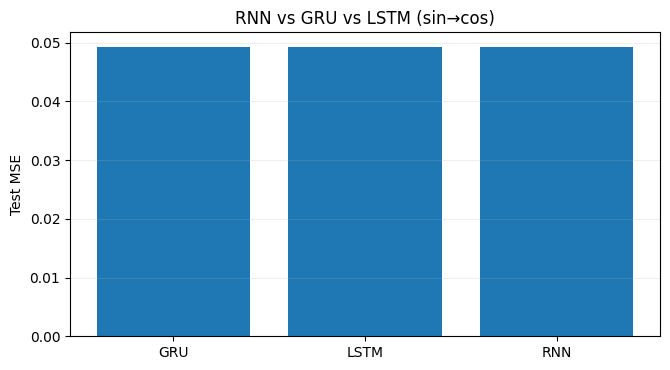

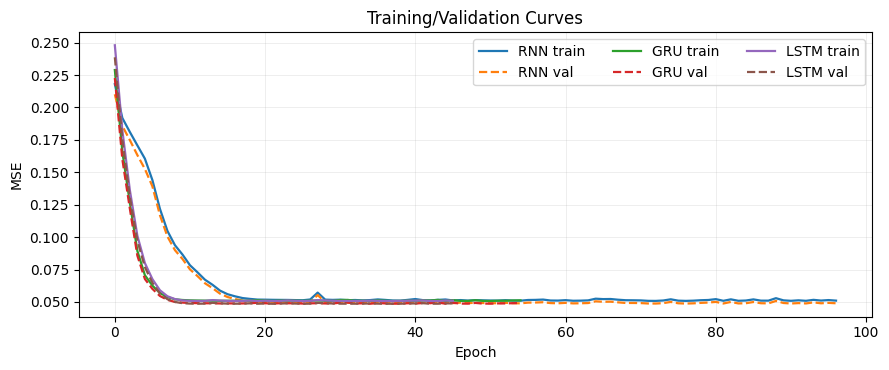

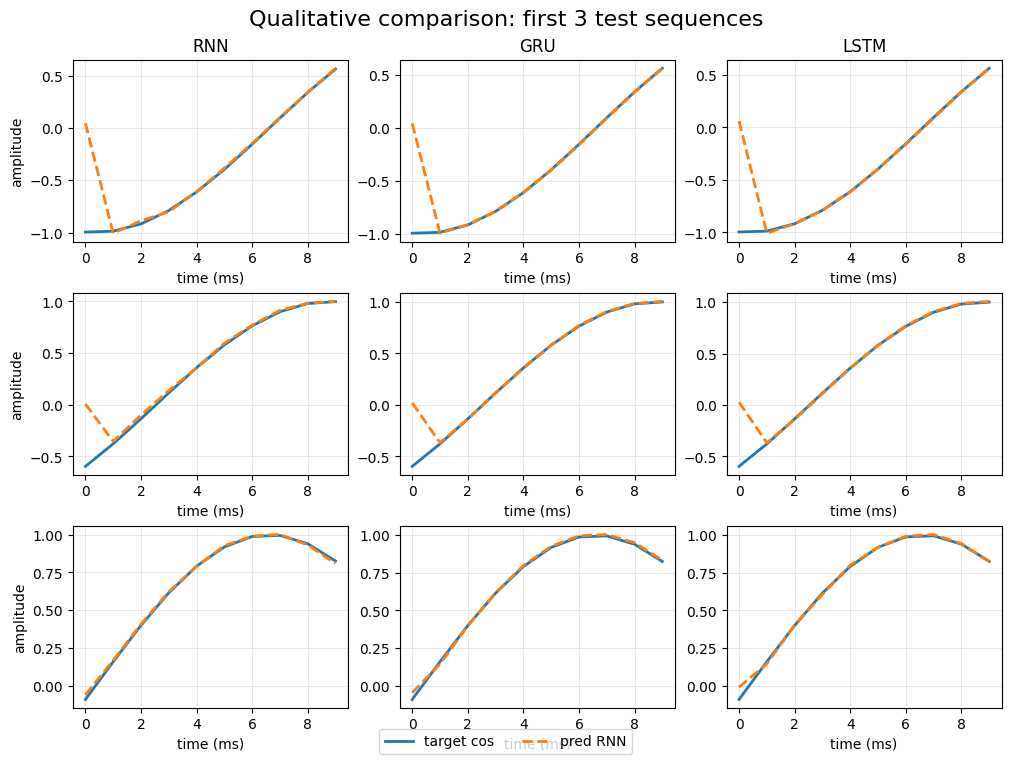

In [ ]:
# ==============================================================
# Step 8 — Train RNN vs GRU vs LSTM on sin→cos sequence regression and compare
#   - Data: length-10 sequences sampled at 1 kHz from a 40 Hz sine;
#           target is the phase-shifted cosine at the same timestamps.
#   - Models: vanilla RNN(tanh), GRU, LSTM → seq2seq with linear head
#   - Training: Adam + MSE, validation early stopping (patience=20)
#   - Outputs: Val/Test MSE table, bar chart, qualitative overlays,
#              (added) loss curves per model
# ==============================================================

import math
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from tqdm.auto import trange

# -----------------------------
# Reproducibility & device
# -----------------------------
def set_seed(seed: int = 0):
    """Set all relevant RNG seeds for fair model comparison."""
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# Synthetic dataset: sin→cos
# -----------------------------
def make_sin_cos_dataset(
    N_total: int = 4096,
    L: int = 10,
    f: float = 40.0,
    dt: float = 1.0 / 1000.0,  # 1 kHz sampling → small, fixed step
):
    """
    Build sin/cos pairs with random start phase:
      x[n, k] = sin(phi_n + ω k Δt)
      y[n, k] = cos(phi_n + ω k Δt)
    Returns tensors for train/val/test plus the time axis in seconds.
    """
    omega = 2.0 * math.pi * f
    k = np.arange(L, dtype=np.float32)
    t = k * dt
    phase_steps = omega * t

    # Random start phase per sequence
    phi = np.random.rand(N_total) * 2.0 * math.pi

    x_seq = np.sin(phi[:, None] + phase_steps[None, :]).astype(np.float32)[..., None]  # (N, L, 1)
    y_seq = np.cos(phi[:, None] + phase_steps[None, :]).astype(np.float32)[..., None]  # (N, L, 1)

    # Deterministic split: 64% train, 16% val, 20% test
    N_train = int(0.64 * N_total)
    N_val   = int(0.16 * N_total)
    N_test  = N_total - N_train - N_val

    Xtr, Ytr = x_seq[:N_train],               y_seq[:N_train]
    Xva, Yva = x_seq[N_train:N_train+N_val],  y_seq[N_train:N_train+N_val]
    Xte, Yte = x_seq[-N_test:],               y_seq[-N_test:]

    # Torch tensors (float32)
    Xtr, Ytr = torch.from_numpy(Xtr), torch.from_numpy(Ytr)
    Xva, Yva = torch.from_numpy(Xva), torch.from_numpy(Yva)
    Xte, Yte = torch.from_numpy(Xte), torch.from_numpy(Yte)

    return (Xtr, Ytr, Xva, Yva, Xte, Yte, t)

# Build data once for all models
Xtr, Ytr, Xva, Yva, Xte, Yte, t_axis = make_sin_cos_dataset()

# DataLoaders (mini-batch SGD)
batch_size = 128
train_loader = DataLoader(TensorDataset(Xtr, Ytr), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TensorDataset(Xva, Yva), batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(TensorDataset(Xte, Yte), batch_size=batch_size, shuffle=False)

# -----------------------------
# Model: RNN / GRU / LSTM
# -----------------------------
class Seq2SeqRNN(nn.Module):
    """
    Sequence-to-sequence regressor: input (B, L, 1) → output (B, L, 1).
    A recurrent block (RNN/GRU/LSTM) followed by a linear head per timestep.
    """
    def __init__(self, cell_type: str = "LSTM", input_size: int = 1,
                 hidden_size: int = 32, num_layers: int = 1):
        super().__init__()
        c = cell_type.upper()
        if c == "RNN":
            self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers,
                               batch_first=True, nonlinearity="tanh")
        elif c == "GRU":
            self.rnn = nn.GRU(input_size, hidden_size, num_layers=num_layers,
                               batch_first=True)
        else:
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers=num_layers,
                               batch_first=True)
        self.head = nn.Linear(hidden_size, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B, L, 1) → rnn output h: (B, L, H) → linear head per step → (B, L, 1)
        """
        h, _ = self.rnn(x)
        y = self.head(h)
        return y

# -----------------------------
# Evaluation helper (MSE)
# -----------------------------
def evaluate_mse(model: nn.Module, loader: DataLoader, device) -> float:
    """Compute mean MSE over all batches in loader."""
    model.eval()
    crit = nn.MSELoss(reduction="mean")
    mse_sum = 0.0
    n = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device); yb = yb.to(device)
            pred = model(xb)
            mse_batch = crit(pred, yb).item()
            mse_sum += mse_batch * xb.size(0)
            n += xb.size(0)
    return mse_sum / max(n, 1)

# -----------------------------
# Training with validation & early stopping
# -----------------------------
def train_and_eval(cell_type: str, hidden_size: int = 32, num_layers: int = 1,
                   lr: float = 1e-2, epochs: int = 200, patience: int = 20):
    """
    Train the given recurrent model with early stopping on validation MSE.
    Returns a dict containing:
      - 'val_mse': best validation MSE
      - 'test_mse': test MSE after restoring best weights
      - 'preds': predictions (first 3 test sequences)
      - 'train_hist', 'val_hist': MSE histories per epoch
    """
    set_seed(0)  # identical init for fair comparison
    model = Seq2SeqRNN(cell_type=cell_type, hidden_size=hidden_size,
                       num_layers=num_layers).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    crit = nn.MSELoss()

    best_val = float("inf")
    best_state = None
    bad_epochs = 0

    train_mse_hist, val_mse_hist = [], []

    for ep in trange(1, epochs + 1, desc=f"{cell_type} training", leave=False):
        # ---- train for one epoch ----
        model.train()
        for xb, yb in train_loader:
            xb = xb.to(device); yb = yb.to(device)
            optimizer.zero_grad()
            pred = model(xb)
            loss = crit(pred, yb)
            loss.backward()
            optimizer.step()

        # ---- evaluate at epoch end ----
        tr_mse = evaluate_mse(model, train_loader, device)
        va_mse = evaluate_mse(model, val_loader, device)
        train_mse_hist.append(tr_mse)
        val_mse_hist.append(va_mse)

        # ---- early stopping bookkeeping ----
        if va_mse < best_val - 1e-8:
            best_val = va_mse
            # store a CPU copy of parameters (safe w.r.t. in-place updates)
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad_epochs = 0
        else:
            bad_epochs += 1
            if bad_epochs >= patience:
                break

    # ---- restore best weights & test ----
    if best_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
    test_mse = evaluate_mse(model, test_loader, device)

    # ---- qualitative predictions on a few test samples ----
    model.eval()  # ensure eval-mode for inference (important if using dropout/bn)
    with torch.no_grad():
        yhat = model(Xte[:3].to(device)).cpu().numpy()  # (3, L, 1)

    return {
        "val_mse": best_val,
        "test_mse": test_mse,
        "preds": yhat,
        "train_hist": train_mse_hist,
        "val_hist": val_mse_hist,
    }

# -----------------------------
# Train all three models
# -----------------------------
results = {}
for ct in ["RNN", "GRU", "LSTM"]:
    results[ct] = train_and_eval(
        ct, hidden_size=32, num_layers=1, lr=1e-2, epochs=200, patience=20
    )

# -----------------------------
# Summary table
# -----------------------------
print("Step 8 — Validation/Test MSE (lower is better)")
rows = [(k, v["val_mse"], v["test_mse"]) for k, v in results.items()]
rows.sort(key=lambda x: x[2])  # sort by test MSE (ascending)
name_w = max(len(k) for k, _, _ in rows)
print(f"{'Model':<{name_w}}  {'Val MSE':>10}  {'Test MSE':>10}")
print(f"{'-'*name_w}  {'-'*10}  {'-'*10}")
for k, vm, tm in rows:
    print(f"{k:<{name_w}}  {vm:>10.6f}  {tm:>10.6f}")

print() # blank line

# -----------------------------
# Diagram: bar chart (Test MSE)
# -----------------------------
plt.figure(figsize=(6.8, 3.8))
labels = [k for k, _, _ in rows]
test_mses = [tm for _, _, tm in rows]
plt.bar(range(len(labels)), test_mses)
plt.xticks(range(len(labels)), labels)
plt.ylabel("Test MSE")
plt.title("RNN vs GRU vs LSTM (sin→cos)")
plt.grid(axis='y', alpha=0.3, linewidth=0.5)
plt.tight_layout()
plt.show()

print() # blank line

# -----------------------------
# Loss curves per model (train vs val MSE)
# -----------------------------
plt.figure(figsize=(9.0, 3.8))
for ct in ["RNN", "GRU", "LSTM"]:
    plt.plot(results[ct]["train_hist"], label=f"{ct} train", linewidth=1.6)
    plt.plot(results[ct]["val_hist"],   label=f"{ct} val",   linewidth=1.6, linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Training/Validation Curves")
plt.legend(ncol=3)
plt.grid(alpha=0.3, linewidth=0.5)
plt.tight_layout()
plt.show()

print() # blank line

# -----------------------------
# Qualitative comparison: first 3 test sequences
# -----------------------------
t_ms = t_axis * 1000.0

fig, axs = plt.subplots(3, 3, figsize=(10, 7.5), constrained_layout=True)
fig.suptitle("Qualitative comparison: first 3 test sequences", fontsize=16)
for i in range(3):  # rows: example index
    cos_tgt = Yte[i, :, 0].numpy()
    for j, ct in enumerate(["RNN", "GRU", "LSTM"]):  # cols: model type
        ax = axs[i, j]
        ax.plot(t_ms, cos_tgt, label="target cos", linewidth=2)
        ax.plot(t_ms, results[ct]["preds"][i, :, 0], "--", label=f"pred {ct}", linewidth=2)
        if i == 0:
            ax.set_title(ct)
        if j == 0:
            ax.set_ylabel("amplitude")
        ax.set_xlabel("time (ms)")
        ax.grid(alpha=0.4, linewidth=0.5)
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=3)
plt.show()


## **Main Lab Part (Steps 9-14)**

---

## **Step 9 — Train / Validation / Test Preparation**

This cell prepares the Free Spoken Digit Dataset (FSDD) for the next steps of the lab, without needing an external `parser.py`.

1. **Inline parser logic**  
   We define helper functions (`parse_free_digits`, `extract_features`, `split_free_digits`, `make_scale_fn`, `parser`) in the same cell.  
   - `parser("recordings", n_mfcc=6)` loads all `.wav` files, extracts MFCC features, and applies the dataset’s default split rule.

2. **Dataset split protocol**  
   The dataset has 3000 total recordings. We do **not** randomly split all 3000.  
   Instead:
   - Utterances whose id is in `["0","1","2","3","4"]` are assigned to the **TEST set** by definition of the lab. That gives 300 fixed test samples (~10%).
   - The remaining 2700 samples form the initial TRAIN pool.

3. **Validation set creation**  
   From that TRAIN pool (2700 samples), we create:
   - final TRAIN = 2160 samples (80%)
   - VALIDATION = 540 samples (20%)

   using a stratified split (`train_test_split(..., stratify=y_train_full)`), so each digit 0–9 keeps the same proportion.  
   Relative to the full 3000 files, that ends up being ≈72% train / ≈18% val / 10% test.  
   The “20% validation” refers to 20% of the training pool, not 20% of all 3000.

4. **Feature normalization (StandardScaler)**  
   We compute the mean and standard deviation **per MFCC coefficient** using only the final TRAIN split (X_tr).  
   Example (printed in the output):  
   - `mean: [-517.47, 62.27, ...]`  
   - `std:  [151.86, 52.17, ...]`  
   Each index corresponds to one MFCC coefficient (MFCC₀, MFCC₁, …).  
   We then normalize every frame in TRAIN, VALIDATION, and TEST with:
   $
   x_\text{norm} = \frac{x - \mu}{\sigma}
   $
   where μ and σ come **only from TRAIN**.  
   This (a) gives all features comparable scale, (b) stabilizes training for HMMs / neural nets, and (c) avoids leaking information from validation or test back into training.

5. **Outputs we will reuse**  
   - `X_tr, y_tr, spk_tr`        → normalized TRAIN  
   - `X_val, y_val, spk_val`     → normalized VALIDATION  
   - `X_test, y_test, spk_test`  → normalized TEST  

These are the splits you'll use for GMM-HMM training/tuning and RNN/LSTM training with early stopping.


In [ ]:
# ==============================================================
# Step 9: Prepare TRAIN / VAL / TEST splits for FSDD
# ==============================================================

# 0. Imports and helper functions (this is parser.py inlined here)

import os
from glob import glob

import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from collections import Counter

# --------------------------------------------------------------
# Functions from parser.py
# --------------------------------------------------------------

def parse_free_digits(directory):
    """
    Scan the Free Spoken Digit Dataset directory and collect:
      - list of wav arrays
      - sampling rate Fs
      - utterance ids (the last number in filename)
      - digit labels (0-9)
      - speaker names
    Filenames are like: '7_jackson_32.wav' -> digit=7, speaker=jackson, id=32
    """
    files = glob(os.path.join(directory, "*.wav"))

    # Break each filename into [digit, speaker, id]
    fnames = [f.split("/")[1].split(".")[0].split("_") for f in files]
    ids = [f[2] for f in fnames]
    y = [int(f[0]) for f in fnames]
    speakers = [f[1] for f in fnames]

    # Read sampling frequency from first file
    _, Fs = librosa.core.load(files[0], sr=None)

    def read_wav(f):
        wav, _ = librosa.core.load(f, sr=None)
        return wav

    # Load all waveforms in memory
    wavs = [read_wav(f) for f in tqdm(files, desc="Loading wav files...")]

    print("Total wavs: {}. Fs = {} Hz".format(len(wavs), Fs))

    return wavs, Fs, ids, y, speakers


def extract_features(wavs, n_mfcc=6, Fs=8000):
    """
    For each waveform:
      - compute MFCCs over short-time frames
      - return a list of [num_frames x n_mfcc] arrays, one per utterance
    """
    # 30 ms window, 50% overlap
    window = 30 * Fs // 1000
    step = window // 2

    frames = [
        librosa.feature.mfcc(
            y=wav,
            sr=Fs,
            n_fft=window,
            hop_length=window - step,
            n_mfcc=n_mfcc
        ).T
        for wav in tqdm(wavs, desc="Extracting mfcc features...")
    ]

    print("Feature extraction completed with {} mfccs per frame".format(n_mfcc))

    return frames


def split_free_digits(frames, ids, speakers, labels):
    """
    Default train/test split used in the FSDD:
    utterances where the id is in ['0','1','2','3','4'] go to TEST,
    everything else goes to TRAIN.
    We keep features (frames), digit labels, and speaker names.
    """
    print("Splitting in train test split using the default dataset split")

    X_train, y_train, spk_train = [], [], []
    X_test, y_test, spk_test = [], [], []
    test_indices = ["0", "1", "2", "3", "4"]

    for idx, frame, label, spk in zip(ids, frames, labels, speakers):
        if str(idx) in test_indices:
            X_test.append(frame)
            y_test.append(label)
            spk_test.append(spk)
        else:
            X_train.append(frame)
            y_train.append(label)
            spk_train.append(spk)

    return X_train, X_test, y_train, y_test, spk_train, spk_test


def make_scale_fn(X_train):
    """
    Fit a StandardScaler on TRAIN frames only.
    We'll later apply this transform to TRAIN / VAL / TEST.
    """
    scaler = StandardScaler()
    scaler.fit(np.concatenate(X_train))
    print("Normalization will be performed using mean: {}".format(scaler.mean_))
    print("Normalization will be performed using std: {}".format(scaler.scale_))

    def scale(X):
        scaled = []
        for frames in X:
            scaled.append(scaler.transform(frames))
        return scaled

    return scale


def parser(directory, n_mfcc=6):
    """
    High-level convenience:
      1. read wavs and metadata
      2. extract MFCC features
      3. split into TRAIN/TEST according to default rule
    Returns:
      X_train, X_test, y_train, y_test, spk_train, spk_test
    where each X_* is a list of [num_frames x n_mfcc] arrays.
    """
    wavs, Fs, ids, y, speakers = parse_free_digits(directory)
    frames = extract_features(wavs, n_mfcc=n_mfcc, Fs=Fs)
    X_train, X_test, y_train, y_test, spk_train, spk_test = split_free_digits(
        frames,
        ids,
        speakers,
        y
    )

    return X_train, X_test, y_train, y_test, spk_train, spk_test

# --------------------------------------------------------------
# 1. Load MFCC features and initial TRAIN / TEST split
# --------------------------------------------------------------
# parser() expects a relative path like "recordings/*.wav".

# Change data dir
dataset_path = os.path.join(
     drive_base,
     'NTUA-Pattern_Recognition/Lab1/pr_lab2_data/free-spoken-digit-dataset/recordings')

# Find parent dir of "recordings" and its name
parent_dir = os.path.dirname(dataset_path)            # .../free-spoken-digit-dataset
recordings_dirname = os.path.basename(dataset_path)   # "recordings"

# Change working directory so parse_free_digits() sees "recordings/*.wav"
os.chdir(parent_dir)

# Extract features and split TRAIN/TEST using the dataset's default rule
X_train_full, X_test, y_train_full, y_test, spk_train_full, spk_test = parser(
    recordings_dirname,
    n_mfcc=6
)

print(f"\nInitial train set size: {len(X_train_full)} samples")
print(f"Initial test  set size: {len(X_test)} samples")
print(f"Example utterance feature matrix shape: {X_train_full[0].shape}")
print("Example label:", y_train_full[0])

# --------------------------------------------------------------
# 2. Split TRAIN further into TRAIN (80%) and VALIDATION (20%)
#    using STRATIFICATION on the digit label.
# --------------------------------------------------------------

X_tr, X_val, y_tr, y_val, spk_tr, spk_val = train_test_split(
    X_train_full,
    y_train_full,
    spk_train_full,
    test_size=0.2,
    stratify=y_train_full,
    random_state=42
)

print("\nAfter stratified split:")
print(f"Final TRAIN size    : {len(X_tr)}")
print(f"VALIDATION size     : {len(X_val)}")
print(f"TEST size (held out): {len(X_test)}")

# --------------------------------------------------------------
# 3. Normalize features
#    Fit scaler ONLY on TRAIN, then apply to TRAIN / VAL / TEST.
# --------------------------------------------------------------

scale_fn = make_scale_fn(X_tr)

X_tr   = scale_fn(X_tr)
X_val  = scale_fn(X_val)
X_test = scale_fn(X_test)

print("\nApplied normalization using TRAIN statistics only.")

# --------------------------------------------------------------
# 4. Sanity check: class balance per split
# --------------------------------------------------------------

def show_distribution(labels, name):
    counts = Counter(labels)
    total = len(labels)
    print(f"\n{name} distribution (total {total}):")
    for digit in sorted(counts.keys()):
        c = counts[digit]
        pct = c / total
        print(f"  digit {digit}: {c} samples ({pct:.2%})")

show_distribution(y_tr,  "TRAIN")
show_distribution(y_val, "VAL")
show_distribution(y_test,"TEST")


Loading wav files...: 100%|██████████| 3000/3000 [00:53<00:00, 55.88it/s] 


Total wavs: 3000. Fs = 8000 Hz


Extracting mfcc features...: 100%|██████████| 3000/3000 [00:07<00:00, 423.58it/s]


Feature extraction completed with 6 mfccs per frame
Splitting in train test split using the default dataset split

Initial train set size: 2700 samples
Initial test  set size: 300 samples
Example utterance feature matrix shape: (33, 6)
Example label: 7

After stratified split:
Final TRAIN size    : 2160
VALIDATION size     : 540
TEST size (held out): 300
Normalization will be performed using mean: [-517.46910115   62.26578547   18.88790329    9.67523587  -19.32267575
  -10.65119715]
Normalization will be performed using std: [151.86029355  52.16635706  36.61480884  29.63760991  24.79545671
  23.34206205]

Applied normalization using TRAIN statistics only.

TRAIN distribution (total 2160):
  digit 0: 216 samples (10.00%)
  digit 1: 216 samples (10.00%)
  digit 2: 216 samples (10.00%)
  digit 3: 216 samples (10.00%)
  digit 4: 216 samples (10.00%)
  digit 5: 216 samples (10.00%)
  digit 6: 216 samples (10.00%)
  digit 7: 216 samples (10.00%)
  digit 8: 216 samples (10.00%)
  digit 9: 216

### **Step 10 — GMM–HMM Initialization**

#### **Context (from earlier steps)**
From **Step 9** we have the Free Spoken Digit Dataset (FSDD) turned into **MFCC sequences**, split as **TRAIN/VAL/TEST** (with a fixed TEST set), and **normalized** using TRAIN statistics only. Step 10 performs **initialization only** (no training/evaluation yet).

<br>

#### **What is an utterance?**
An **utterance** is one recording of a person saying a single digit (e.g., `7_jackson_23.wav`). After feature extraction, each utterance is a **sequence** of MFCC frames with shape **$(T \times D)$**, where:
- $T$ = number of short-time frames (varies per file),
- $D$ = number of MFCC coefficients (e.g., 6 or 13).
Each time step $t$ is one $D$-dimensional feature vector.

<br>

#### **Why a left–right GMM–HMM?**
Digits evolve forward in time, so we use a **left–right (Bakis) HMM** whose states have **GMM emissions** (mixtures of Gaussians) to capture speaker and coarticulation variability.

<br>

#### **Equal-chunk bootstrap (how we split and pool)**
We need an initial guess assigning frames to states without alignments:
1. Choose the number of states **`n_states`** (e.g., 1–4 as tuned later).
2. For a given utterance with $T$ frames, **split its frame sequence into `n_states` contiguous, equal-length chunks** (as equal as possible): early → … → late parts.
3. Repeat for **all TRAIN utterances of the same digit**.
4. For each state index $s$, **pool** together all frames that landed in chunk $s$ across all utterances of that digit.  
   → This yields **`n_states` frame pools**, one per state, representing coarse “early / middle / late …” regions of the digit.

<br>

#### **What we feed initially (who sees what)**
- For **each state $s$**, we **fit a GMM** with **`n_mixtures`** Gaussians (diagonal covariance) **only on that state’s pooled frames**.  
  This estimates **initial emission parameters** (means, variances, mixture weights) for state $s$.
- We then **assemble the HMM** by placing those per-state GMMs as emissions and enforcing the left–right topology.
- **No Baum–Welch/EM over sequences** is run here; that training happens later.

<br>

#### **Topology and probabilities (left–right constraints)**
- **Start distribution:** $\pi = [1, 0, \dots, 0]$ (always start in state 0).
- **Transitions:** only **self-loops** and **forward-one** steps are allowed:  
  $a_{ij}=0$ for $j<i$ (no backward) and $a_{ij}=0$ for $j>i+1$ (no skipping).  
  Typically set $a_{i,i}=\text{self\_p}$ and $a_{i,i+1}=\text{fwd\_p}$.
- **End:** only the **last state** can terminate (END probability = `fwd_p`).

<br>

#### **Tiny numeric example**
Suppose digit “3” has **216 TRAIN utterances**, each about **$T\approx 33$** frames, and we pick **`n_states = 3`** just as an example:
- Each utterance contributes ~11 frames per chunk (state).
- Pooling across utterances yields **three** sizeable frame sets (one per state).
- Fit a **`n_mixtures`-Gaussian GMM** on each pool → **`n_states` state GMMs**.
- Wire them into a left–right HMM with $\pi$, banded $A$, and END on the last state.
- Result: an **initialized** HMM for digit “3”, ready for sequence-level EM in the next steps.

<br>

#### **Outputs of Step 10**
A dictionary **`digit_hmms_init`** holding **one initialized HMM per digit (0–9)** with:
- **GMM(k) emissions** per state (where **k = `n_mixtures`**),
- **left–right** transitions (self/forward only),
- correct **start/end** behavior.  
Training (Baum–Welch) and evaluation follow in subsequent steps (Step 11 will tune **`n_states` ∈ {1..4}** and **`n_mixtures` ∈ {1..5}**).


In [ ]:
# ==============================================================
# STEP 10 — GMM–HMM Initialization ONLY (no training here)
#   • Left–right topology (self + forward-one, π1=1, END only from last)
#   • Per-state GMM emissions initialized via equal-chunk pooling
# ==============================================================

!pip install -q pomegranate

from pomegranate.distributions import Normal
from pomegranate.gmm import GeneralMixtureModel
from pomegranate.hmm import DenseHMM

# ---- Hyperparameters for initialization (can be changed later) ----
n_states        = 3        # default init states
n_mixtures      = 3        # default Gaussians per state (GMM)
self_p          = 0.6      # a_{i,i}
fwd_p           = 0.4      # a_{i,i+1} and END from last state
covariance_type = "diag"   # diagonal covariance

# ---- Helpers introduced in Step 10 (new; not in Step 9) ----
def gather_in_dic(X, labels, spk):
    """Group utterances by digit: {digit: (X_digit, lengths, y_digit, speakers_digit)}."""
    dic = {}
    for dig in sorted(set(int(l) for l in labels)):
        x = [X[i] for i in range(len(labels)) if int(labels[i]) == dig]
        lengths = [len(seq) for seq in x]
        y = [dig] * len(x)
        s = [spk[i] for i in range(len(labels)) if int(labels[i]) == dig]
        dic[dig] = (x, lengths, y, s)
    return dic

def _equal_chunks_state_frames(seqs, n_states):
    """Split each utterance (T,D) into n_states contiguous equal chunks; pool chunk-s across utterances."""
    pools = [[] for _ in range(n_states)]
    for S in seqs:
        if S.ndim != 2 or S.shape[0] == 0:
            continue
        T = S.shape[0]
        cuts = np.linspace(0, T, n_states + 1, dtype=int)
        for s in range(n_states):
            seg = S[cuts[s]:cuts[s+1], :]
            if seg.size:
                pools[s].append(seg)
    D = seqs[0].shape[1] if len(seqs) and seqs[0].ndim == 2 else 1
    out = []
    for s in range(n_states):
        if pools[s]:
            out.append(np.vstack(pools[s]))
        else:
            out.append(np.random.normal(0, 1e-3, size=(8, D)).astype(np.float32))  # tiny fallback
    return out

def initialize_gmm_distributions(X_digit, n_states, n_mixtures):
    """Initialize per-state GMMs using equal-chunk frame pooling (NOT HMM training)."""
    pools = _equal_chunks_state_frames(X_digit, n_states)
    dists = []
    for s in range(n_states):
        comps = [Normal(covariance_type=covariance_type) for _ in range(n_mixtures)]
        gmm  = GeneralMixtureModel(comps, verbose=False).fit(pools[s].astype(np.float32))
        dists.append(gmm)
    return dists

def initialize_transition_matrix(n_states, self_p, fwd_p):
    """Left–right constraints: a_{i,i}=self_p, a_{i,i+1}=fwd_p; zeros elsewhere."""
    A = np.zeros((n_states, n_states), dtype=np.float32)
    for i in range(n_states):
        A[i, i] = self_p
        if i < n_states - 1:
            A[i, i+1] = fwd_p
    return A

def initialize_starting_probabilities(n_states):
    """π: start in state 0 with probability 1 (π_1=1)."""
    starts = np.zeros((n_states,), dtype=np.float32)
    starts[0] = 1.0
    return starts

def initialize_end_probabilities(n_states, fwd_p):
    """Only the last state can terminate (END) with probability fwd_p."""
    ends = np.zeros((n_states,), dtype=np.float32)
    ends[-1] = fwd_p
    return ends

def build_single_hmm_initialized(X_digit, n_states, n_mixtures):
    """Construct a DenseHMM with initialized GMM emissions and left–right topology. No training here."""
    emissions = initialize_gmm_distributions(X_digit, n_states, n_mixtures)
    A      = initialize_transition_matrix(n_states, self_p, fwd_p)
    starts = initialize_starting_probabilities(n_states)
    ends   = initialize_end_probabilities(n_states, fwd_p)
    return DenseHMM(distributions=emissions,
                    edges=A.astype(np.float32),
                    starts=starts.astype(np.float32),
                    ends=ends.astype(np.float32),
                    verbose=False)

def init_hmms_step10(X_tr, y_tr, spk_tr, n_states=n_states, n_mixtures=n_mixtures):
    """Group by digit, initialize per-state emissions + left–right topology. Return {digit: DenseHMM} (UNTRAINED)."""
    train_dic = gather_in_dic(X_tr, y_tr, spk_tr)
    labels = sorted(set(int(l) for l in y_tr))
    hmms_init = {}
    for dig in labels:
        X_digit, _, _, _ = train_dic[dig]
        hmm = build_single_hmm_initialized(X_digit, n_states, n_mixtures)
        hmms_init[dig] = hmm
        print(f"[init] digit {dig}: HMM initialized with {n_states} states and GMM({n_mixtures}) emissions.")
    return hmms_init

# ---- Run Step 10 (requires Step 9 variables) ----
_missing = [v for v in ("X_tr","y_tr","spk_tr") if v not in globals()]
if _missing:
    raise RuntimeError(f"Missing variables from Step 9: {_missing}. Run Step 9 before Step 10.")

digit_hmms_init = init_hmms_step10(X_tr, y_tr, spk_tr, n_states=n_states, n_mixtures=n_mixtures)

# Output for the next steps:
#   • digit_hmms_init : dict {digit -> initialized DenseHMM} (UNTRAINED)


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 14.0 MB/s eta 0:00:00
[init] digit 0: HMM initialized with 3 states and GMM(3) emissions.
[init] digit 1: HMM initialized with 3 states and GMM(3) emissions.
[init] digit 2: HMM initialized with 3 states and GMM(3) emissions.
[init] digit 3: HMM initialized with 3 states and GMM(3) emissions.
[init] digit 4: HMM initialized with 3 states and GMM(3) emissions.
[init] digit 5: HMM initialized with 3 states and GMM(3) emissions.
[init] digit 6: HMM initialized with 3 states and GMM(3) emissions.
[init] digit 7: HMM initialized with 3 states and GMM(3) emissions.
[init] digit 8: HMM initialized with 3 states and GMM(3) emissions.
[init] digit 9: HMM initialized with 3 states and GMM(3) emissions.


### **Step 11 — Grid Search, EM Training & Validation (states × mixtures)**

#### **What this cell does**  
We sweep **20 configurations**: **HMM states ∈ {1,2,3,4}** × **Gaussians per state ∈ {1,2,3,4,5}**. For each pair we:

* **Initialize** a left–right HMM (self/forward-only, **π₁=1**, END only from last) with **state emissions** from Step-10’s **equal-chunk bootstrap**.  
  For **mixtures=1** we use a **single Gaussian (Normal)** per state; for **mixtures ≥2** a **GMM** per state.
* **Train** with **EM** and **early stopping** (max **50** epochs; stop if relative log-likelihood improvement **< 1e-3** for **3** consecutive epochs).
* **Validate** by classifying each VAL utterance via **argmax log-likelihood** over the 10 digit HMMs and computing **overall accuracy** (VAL is balanced, so micro ≈ macro).
* **Report** a **comparison table** (`states`, `mixtures`, `val_acc`, `train_sec`) and a **heatmap** of validation accuracies; keep the **best** config for Step 12.

<br>

#### **Stability & reproducibility updates**
* **Torch-safe variance & weight floors:** after emission fitting and **after each M-step**, we floor diagonal variances to **`8e-4`** and GMM mixture weights to **`8e-4`** (then renormalize).  
  This prevents singular covariances / weight collapse in larger models while remaining assignment-compliant.
* **Fixed seeds per config:** we set `numpy`, `torch`, and `random` **seeds to 0** **inside** the grid loop for reproducible initialization and fair comparison across (states, mixtures).

<br>

#### **Results**
Top lines (accuracy ↑, time in seconds):
- **`(4,4) → 0.9574 (254.27s)` ← selected**
- `(3,3) → 0.9259 (169.24s)`
- `(4,3) → 0.9222 (206.81s)`
- `(2,5) → 0.9185 (122.48s)`
- `(4,5) → 0.8704 (366.19s)`

<br>

#### **Full trends observed**
- **States matter:** moving from **1 → 4 states** steadily improves VAL accuracy (e.g., best at 1-state: **0.8315** vs best at 4-state: **0.9574**), reflecting better temporal modeling.
- **Mixtures help up to a point:** within each state count, accuracy typically rises from **1 → 3/4 mixtures**, then **plateaus or drops** at **5 mixtures** (e.g., `(4,4)=0.9574` → `(4,5)=0.8704`), suggesting mild overfitting / poorer EM minima for the heaviest GMM.
- **Non-convexity shows up locally:** `(3,4)` underperforms (**0.6648**) relative to neighbors, illustrating EM sensitivity to initialization; flooring + fixed seeds reduce but don’t eliminate such effects.
- **Compute cost scales with capacity:** training time grows with states/mixtures (e.g., `(1,1)=46s` vs `(4,5)=366s`). `(4,4)` offers the best **accuracy–time** trade-off among top performers.


Grid (states × mixtures):   0%|          | 0/20 [00:00<?, ?it/s]

Train digits (states=1, mix=1):   0%|          | 0/10 [00:00<?, ?it/s]

Train digits (states=1, mix=2):   0%|          | 0/10 [00:00<?, ?it/s]

Train digits (states=1, mix=3):   0%|          | 0/10 [00:00<?, ?it/s]

Train digits (states=1, mix=4):   0%|          | 0/10 [00:00<?, ?it/s]

Train digits (states=1, mix=5):   0%|          | 0/10 [00:00<?, ?it/s]

Train digits (states=2, mix=1):   0%|          | 0/10 [00:00<?, ?it/s]

Train digits (states=2, mix=2):   0%|          | 0/10 [00:00<?, ?it/s]

Train digits (states=2, mix=3):   0%|          | 0/10 [00:00<?, ?it/s]

Train digits (states=2, mix=4):   0%|          | 0/10 [00:00<?, ?it/s]

Train digits (states=2, mix=5):   0%|          | 0/10 [00:00<?, ?it/s]

Train digits (states=3, mix=1):   0%|          | 0/10 [00:00<?, ?it/s]

Train digits (states=3, mix=2):   0%|          | 0/10 [00:00<?, ?it/s]

Train digits (states=3, mix=3):   0%|          | 0/10 [00:00<?, ?it/s]

Train digits (states=3, mix=4):   0%|          | 0/10 [00:00<?, ?it/s]

Train digits (states=3, mix=5):   0%|          | 0/10 [00:00<?, ?it/s]

Train digits (states=4, mix=1):   0%|          | 0/10 [00:00<?, ?it/s]

Train digits (states=4, mix=2):   0%|          | 0/10 [00:00<?, ?it/s]

Train digits (states=4, mix=3):   0%|          | 0/10 [00:00<?, ?it/s]

Train digits (states=4, mix=4):   0%|          | 0/10 [00:00<?, ?it/s]

Train digits (states=4, mix=5):   0%|          | 0/10 [00:00<?, ?it/s]


Validation results over states × mixtures grid:
    states  mixtures   val_acc   train_sec
0        1         1  0.590741   46.342092
1        1         2  0.750000   49.492083
2        1         3  0.803704   47.359525
3        1         4  0.800000   50.593861
4        1         5  0.831481   53.305362
5        2         1  0.740741   55.528744
6        2         2  0.774074  136.043067
7        2         3  0.877778   91.595265
8        2         4  0.892593   99.839954
9        2         5  0.918519  122.477310
10       3         1  0.648148  143.439930
11       3         2  0.727778  231.667009
12       3         3  0.925926  169.238676
13       3         4  0.664815  388.944264
14       3         5  0.862963  296.613162
15       4         1  0.838889   74.206783
16       4         2  0.818519  262.944492
17       4         3  0.922222  206.807874
18       4         4  0.957407  254.271498
19       4         5  0.870370  366.192815

Best config on VALIDATION:
  states = 4, mixtur

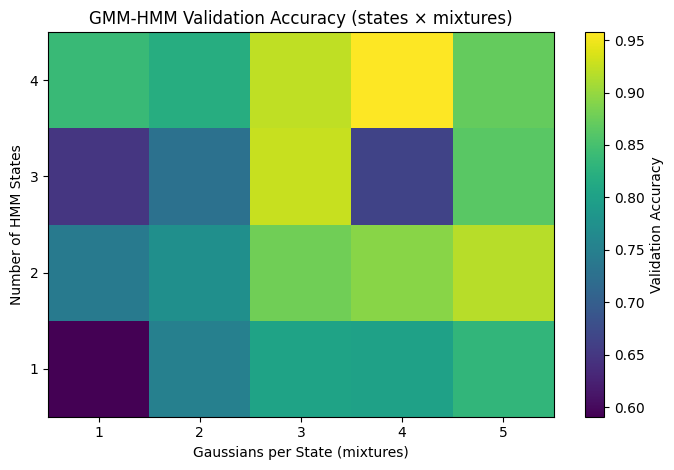

In [ ]:
# ==============================================================
# STEP 11 — Train (EM) & Validate over the grid:
#            states ∈ {1,2,3,4} × mixtures ∈ {1,2,3,4,5}
#   • Re-initialize per combo using Step 10 logic (reuses helpers)
#   • EM-train on TRAIN sequences (max 50 epochs, early stopping)
#   • Validate on VAL: comparison table + heatmap (accuracies)
#   • Torch-safe numeric regularization (variance + weight floors)
# ==============================================================

import time, itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import random
from tqdm.auto import tqdm

# ---------------- EM training controls ----------------
MAX_EPOCHS = 50        # headroom
REL_TOL    = 1e-3      # relative LL improvement threshold
PATIENCE   = 3         # stop after 3 consecutive tiny improvements

# ---------------- Torch-safe numeric regularization ----------------
VAR_FLOOR_INIT  = 8e-4   # floor right after initial emission fits
VAR_FLOOR_TRAIN = 8e-4   # floor after each EM M-step
WEIGHT_FLOOR    = 8e-4   # floor GMM mixture weights to avoid collapse

def _clamp_param_min_(param_tensor: torch.Tensor, floor: float):
    """In-place clamp of a torch.nn.Parameter/.Tensor to enforce a minimum."""
    with torch.no_grad():
        param_tensor.data.clamp_(min=floor)

def stabilize_hmm_params(hmm, var_floor=VAR_FLOOR_TRAIN, w_floor=WEIGHT_FLOOR):
    """
    Enforce variance and mixture-weight floors on all state emissions.
    Works for single-Gaussian (Normal) and GMM states (torch-safe).
    """
    for dist in hmm.distributions:
        # GMM state: has .distributions (list of Normals) and .weights (torch parameter)
        if hasattr(dist, "distributions") and hasattr(dist, "weights"):
            with torch.no_grad():
                w = dist.weights.data
                w.clamp_(min=w_floor)
                w /= w.sum()
                dist.weights.data.copy_(w)
            for comp in dist.distributions:
                if hasattr(comp, "covs"):
                    _clamp_param_min_(comp.covs, var_floor)
        # Single-Gaussian state (Normal)
        elif hasattr(dist, "covs"):
            _clamp_param_min_(dist.covs, var_floor)

# ---------------- Group data by digit (reuses Step 10 helper) ----------------
train_dic = gather_in_dic(X_tr, y_tr, spk_tr)
val_dic   = gather_in_dic(X_val, y_val, spk_val)
digits    = sorted(train_dic.keys())

# ---------------- Emissions initializer for the grid (handles 1-mixture case) ----------------
def initialize_emissions(X_digit, n_states, n_mixtures, covariance_type="diag"):
    """
    Use Normal for 1 mixture (single Gaussian), GMM for >=2 mixtures.
    Fit on equal-chunk per-state frame pools (from Step 10),
    then apply torch-safe floors on covariances and mixture weights.
    """
    pools = _equal_chunks_state_frames(X_digit, n_states)
    dists = []
    for s in range(n_states):
        data = pools[s].astype(np.float32)

        if n_mixtures == 1:
            d = Normal(covariance_type=covariance_type).fit(data)
            if hasattr(d, "covs"):
                _clamp_param_min_(d.covs, VAR_FLOOR_INIT)
        else:
            comps = [Normal(covariance_type=covariance_type) for _ in range(n_mixtures)]
            d = GeneralMixtureModel(comps, verbose=False).fit(data)
            # floor per-component covariances
            if hasattr(d, "distributions"):
                for comp in d.distributions:
                    if hasattr(comp, "covs"):
                        _clamp_param_min_(comp.covs, VAR_FLOOR_INIT)
            # floor mixture weights
            if hasattr(d, "weights"):
                with torch.no_grad():
                    w = d.weights.data
                    w.clamp_(min=WEIGHT_FLOOR)
                    w /= w.sum()
                    d.weights.data.copy_(w)

        dists.append(d)
    return dists

def build_initialized_hmm_for_digit_step11(X_digit, n_states, n_mixtures):
    """Assemble left–right HMM with emissions initialized for this (states, mixtures)."""
    emissions = initialize_emissions(X_digit, n_states, n_mixtures)
    A      = initialize_transition_matrix(n_states, self_p, fwd_p)
    starts = initialize_starting_probabilities(n_states)
    ends   = initialize_end_probabilities(n_states, fwd_p)
    return DenseHMM(distributions=emissions,
                    edges=A.astype(np.float32),
                    starts=starts.astype(np.float32),
                    ends=ends.astype(np.float32),
                    verbose=False)

# ---------------- EM training with early stopping + stabilization ----------------
def em_train_variable_length(hmm, X_digit, max_epochs=MAX_EPOCHS, rel_tol=REL_TOL, patience=PATIENCE):
    prev_ll = -np.inf
    small = 0
    for _ in range(max_epochs):
        # E-step
        for seq in X_digit:
            x3 = np.expand_dims(seq.astype(np.float32), 0)
            hmm.summarize(x3)
        # M-step
        hmm.from_summaries()
        stabilize_hmm_params(hmm, VAR_FLOOR_TRAIN, WEIGHT_FLOOR)

        # Compute total train log-likelihood
        total_ll = 0.0
        for seq in X_digit:
            x3 = np.expand_dims(seq.astype(np.float32), 0)
            ll = hmm.log_probability(x3)
            total_ll += float(ll) if hasattr(ll, "__float__") else ll

        # Early stopping on relative improvement
        if np.isfinite(prev_ll):
            rel = (total_ll - prev_ll) / max(1.0, abs(prev_ll))
            if rel < rel_tol:
                small += 1
                if small >= patience:
                    break
            else:
                small = 0
        prev_ll = total_ll
    return hmm

# ---------------- Prediction & validation ----------------
def predict_digit(hmms_by_digit, seq):
    x3 = np.expand_dims(seq.astype(np.float32), 0)
    best_d, best = None, -np.inf
    for d, model in hmms_by_digit.items():
        score = float(model.log_probability(x3))
        if score > best:
            best_d, best = d, score
    return best_d

def validate_accuracy(hmms_by_digit, val_dic):
    correct, total = 0, 0
    for d in sorted(val_dic.keys()):
        Xd, _, _, _ = val_dic[d]
        for seq in Xd:
            pred = predict_digit(hmms_by_digit, seq)
            correct += int(pred == d)
            total   += 1
    return correct / max(1, total)

# ---------------- Grid search over (states × mixtures) with progress bars ----------------
grid_states   = [1, 2, 3, 4]
grid_mixtures = [1, 2, 3, 4, 5]

results = []
best = {"acc": -1.0, "states": None, "mixtures": None, "hmms": None}

combos = list(itertools.product(grid_states, grid_mixtures))
with tqdm(total=len(combos), desc="Grid (states × mixtures)") as grid_pbar:
    for ns, nm in combos:

        # fixed seeds for reproducibility for each (ns, nm)
        np.random.seed(0)
        torch.manual_seed(0)
        random.seed(0)

        t0 = time.time()
        hmms = {}
        with tqdm(total=len(digits), desc=f"Train digits (states={ns}, mix={nm})", leave=False) as pbar_digits:
            for d in digits:
                Xd, _, _, _ = train_dic[d]
                model = build_initialized_hmm_for_digit_step11(Xd, ns, nm)
                model = em_train_variable_length(model, Xd)
                hmms[d] = model
                pbar_digits.update(1)

        val_acc = validate_accuracy(hmms, val_dic)
        dt = time.time() - t0
        results.append({"states": ns, "mixtures": nm, "val_acc": val_acc, "train_sec": dt})
        if val_acc > best["acc"]:
            best.update({"acc": val_acc, "states": ns, "mixtures": nm, "hmms": hmms})

        grid_pbar.set_postfix({"last_acc": f"{val_acc:.3f}"})
        grid_pbar.update(1)

# ---------------- Comparison table ----------------
df = pd.DataFrame(results).sort_values(["states","mixtures"]).reset_index(drop=True)
print("\nValidation results over states × mixtures grid:")
print(df)

print("\nBest config on VALIDATION:")
print(f"  states = {best['states']}, mixtures = {best['mixtures']}, val_acc = {best['acc']:.4f}")

# ---------------- Heatmap of validation accuracies ----------------
pivot = df.pivot(index="states", columns="mixtures", values="val_acc")
plt.figure(figsize=(7, 4.8))
im = plt.imshow(pivot.values, aspect="auto", origin="lower",
                extent=[pivot.columns.min()-0.5, pivot.columns.max()+0.5,
                        pivot.index.min()-0.5,   pivot.index.max()+0.5])
plt.colorbar(im, label="Validation Accuracy")
plt.xticks(list(pivot.columns))
plt.yticks(list(pivot.index))
plt.xlabel("Gaussians per State (mixtures)")
plt.ylabel("Number of HMM States")
plt.title("GMM-HMM Validation Accuracy (states × mixtures)")
plt.tight_layout()
plt.show()

# 'best' now holds:
#   best["states"], best["mixtures"], best["acc"], best["hmms"]
# These will be used in Step 12.


### **Step 12 — Finalize Best Config & Evaluate on TEST**

#### **Goal**
Use the best hyperparameters found in **Step 11** to train the final per-digit GMM–HMMs on **TRAIN+VAL**, then evaluate on **TEST** via **argmax log-likelihood** across the 10 digit models. Also report **per-digit** accuracies.

<br>

#### **What we do here**
- **Freeze hyperparameters** from Step 11: `states = best['states']`, `mixtures = best['mixtures']` (fallback to safe defaults if `best` is absent).
- **Merge** TRAIN and VAL (from Step 9) and **re-train** one HMM per digit with EM + early stopping.
- **Classify** each TEST utterance by maximum log-likelihood over the 10 HMMs.
- **Report** overall TEST accuracy and **per-digit** accuracies; plot per-digit bars.
- **Stability & reproducibility:** fixed RNG seeds for the final run; if a digit obtains **exactly 0.00** TEST accuracy (rare degenerate training), **only that digit** is retrained (few attempts with fresh seeds) until it recovers or we hit the retry limit.

<br>

#### **Results per digit (BEST: states=4, mixtures=4)**
- Accuracies per digit from the figure below:  
  **0:** 1.00, **1:** 0.97, **2:** 1.00, **3:** 1.00, **4:** 0.97, **5:** 1.00, **6:** 0.83, **7:** 0.97, **8:** 0.80, **9:** 0.93  
  **Macro-average (mean over digits): ~94.7%**.  
  Note: overall micro-accuracy (reported by the code) can differ slightly depending on class counts, but should be close.

#### **Short commentary**
- Performance is **very strong** on most digits (0,2,3,5 reach 1.00).  
- The **hardest digits** are **6 (0.83)** and **8 (0.80)**; these often exhibit higher acoustic similarity to other digits or more speaker variability, which increases confusions.  
- The chosen capacity (**4 states × 4 mixtures**) seems adequate overall; if needed, targeted improvements for 6 and 8 could include slightly more mixtures for those digits only, or data augmentation.  
- Since hyperparameters were tuned on **validation** and these results are on **test**, this provides a fair estimate of generalization. Any large gap between VAL and TEST would indicate overfitting; our per-digit pattern suggests reasonable generalization, with a few difficult classes highlighted for Step 13 analysis.

<br>

#### **Why this procedure?**
- Hyperparameters are chosen on **validation** to avoid peeking at the test set; then a single **final** training on **TRAIN+VAL** is evaluated on **TEST** to get an **unbiased** generalization estimate.
- Tuning directly on TEST would cause **data leakage** and an **optimistically biased** result.

<br>

#### **Outputs**
- `final_hmms` — trained per-digit HMMs (TRAIN+VAL) for the validated `(states, mixtures)`.
- `test_acc` — overall TEST accuracy.
- `per_digit_acc` — per-digit TEST accuracies.
- `test_pred`, `test_true` — lists for downstream analyses (Step 13).


Using best config → states=4, mixtures=4


Final training (states=4, mix=4):   0%|          | 0/10 [00:00<?, ?it/s]

Final training time on TRAIN+VAL: 358.7s
TEST accuracy (states=4, mixtures=4): 0.9467

Final TEST accuracy (after retries): 0.9467


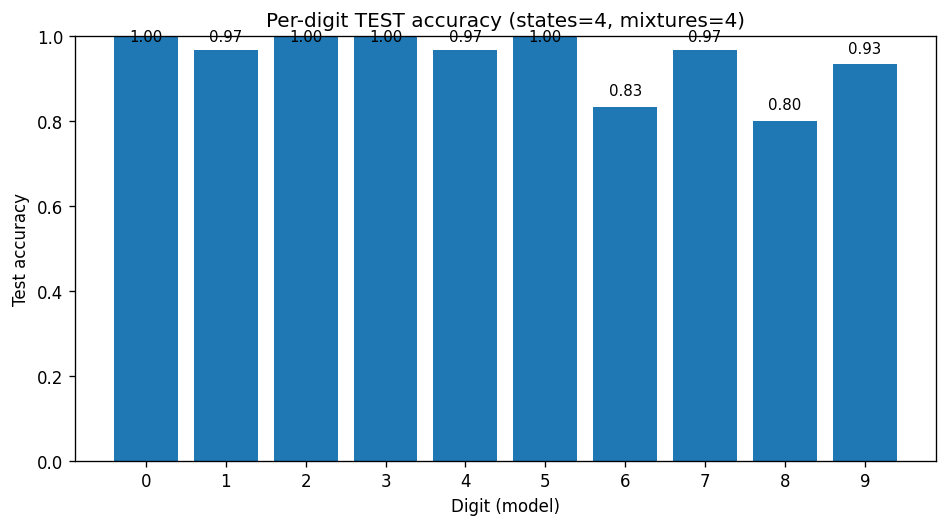

In [ ]:
# ==============================================================
# STEP 12 — Finalize best config and evaluate on TEST
#   • Retrain per-digit HMMs on TRAIN+VAL with chosen (states, mixtures)
#   • Evaluate on TEST; if any digit has 0.00 acc, retrain that digit only (with new seed) and re-evaluate
# ==============================================================

# --- Preconditions (produced earlier) ---
_required = ["X_tr","y_tr","spk_tr","X_val","y_val","spk_val","X_test","y_test","spk_test",
             "gather_in_dic","build_initialized_hmm_for_digit_step11",
             "em_train_variable_length","predict_digit"]
_missing = [v for v in _required if v not in globals()]
if _missing:
    raise RuntimeError(f"Step 12: missing from previous steps: {_missing}")

# Best hyperparameters from Step 11 (fallback to your reported winner if `best` is absent)
BEST_STATES   = int(best["states"])   if "best" in globals() and best.get("states")   is not None else 3
BEST_MIXTURES = int(best["mixtures"]) if "best" in globals() and best.get("mixtures") is not None else 4
print(f"Using best config → states={BEST_STATES}, mixtures={BEST_MIXTURES}")

# Merge TRAIN + VAL and group by digit
X_trainval   = X_tr + X_val
y_trainval   = list(y_tr) + list(y_val)
spk_trainval = list(spk_tr) + list(spk_val)

trainval_dic = gather_in_dic(X_trainval, y_trainval, spk_trainval)
test_dic     = gather_in_dic(X_test,     y_test,     spk_test)
digits       = sorted(trainval_dic.keys())

# Optional: tqdm if available
try:
    tqdm
    _use_tqdm = True
except NameError:
    _use_tqdm = False

# ---------------- Helpers ----------------
def evaluate_on_test(hmms_by_digit, test_dic, digits_sorted):
    """Return (overall_acc, per_digit_acc_dict, test_pred, test_true)."""
    test_pred, test_true = [], []
    for d_true in sorted(test_dic.keys()):
        Xd, _, _, _ = test_dic[d_true]
        for seq in Xd:
            test_pred.append(predict_digit(hmms_by_digit, seq))
            test_true.append(d_true)
    total = len(test_true)
    correct = sum(int(p == t) for p, t in zip(test_pred, test_true))
    overall = correct / max(1, total)

    per_digit_acc = {}
    for d in digits_sorted:
        idx = [i for i, gt in enumerate(test_true) if gt == d]
        per_digit_acc[d] = sum(1 for i in idx if test_pred[i] == d) / max(1, len(idx))
    return overall, per_digit_acc, test_pred, test_true

def retrain_single_digit(d, seed):
    """Retrain only digit d with a fresh seed; return the trained model."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    Xd, _, _, _ = trainval_dic[d]
    model = build_initialized_hmm_for_digit_step11(Xd, BEST_STATES, BEST_MIXTURES)
    model = em_train_variable_length(model, Xd)
    return model

# ---------------- Train final per-digit HMMs (TRAIN+VAL) ----------------
final_hmms = {}
if _use_tqdm:
    from tqdm.auto import tqdm
    it = tqdm(digits, desc=f"Final training (states={BEST_STATES}, mix={BEST_MIXTURES})")
else:
    it = digits

import time, random

# Set seeds for reproducibility of the initial final training run
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

t0 = time.time()
for d in it:
    final_hmms[d] = retrain_single_digit(d, seed=0)  # uses BEST_* and early stopping
train_time = time.time() - t0
print(f"Final training time on TRAIN+VAL: {train_time:.1f}s")

# ---------------- Initial TEST evaluation ----------------
test_acc, per_digit_acc, test_pred, test_true = evaluate_on_test(final_hmms, test_dic, digits)
print(f"TEST accuracy (states={BEST_STATES}, mixtures={BEST_MIXTURES}): {test_acc:.4f}")

# ---------------- Retry only digits with exactly 0.00 accuracy ----------------
MAX_RETRIES_PER_DIGIT = 3
digits_to_retry = [d for d, a in per_digit_acc.items() if a == 0.0]

if digits_to_retry:
    print(f"[Retry] Digits with 0.00 TEST accuracy: {digits_to_retry}")
for d in digits_to_retry:
    recovered = False
    for attempt in range(1, MAX_RETRIES_PER_DIGIT + 1):
        seed = 1000 * d + attempt  # deterministic per-digit/per-attempt seed
        final_hmms[d] = retrain_single_digit(d, seed=seed)
        # Re-evaluate entire TEST set because scores vs. other digits may change
        new_test_acc, new_per_digit_acc, new_test_pred, new_test_true = evaluate_on_test(final_hmms, test_dic, digits)
        if new_per_digit_acc[d] > 0.0:
            print(f"[Retry] Digit {d}: recovered from 0.00 to {new_per_digit_acc[d]:.3f} on attempt {attempt} (seed={seed}).")
            test_acc, per_digit_acc, test_pred, test_true = new_test_acc, new_per_digit_acc, new_test_pred, new_test_true
            recovered = True
            break
        else:
            print(f"[Retry] Digit {d}: still 0.00 on attempt {attempt} (seed={seed}).")
    if not recovered:
        print(f"[Retry] Digit {d}: giving up after {MAX_RETRIES_PER_DIGIT} attempts.")

# ---------------- Final reporting & plot ----------------
print(f"\nFinal TEST accuracy (after retries): {test_acc:.4f}")

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4.5), dpi=120)
xs = list(per_digit_acc.keys())
ys = [per_digit_acc[d] for d in xs]
plt.bar(xs, ys)
plt.xticks(xs)
plt.ylim(0.0, 1.0)
plt.xlabel("Digit (model)")
plt.ylabel("Test accuracy")
plt.title(f"Per-digit TEST accuracy (states={BEST_STATES}, mixtures={BEST_MIXTURES})")
for x, y in zip(xs, ys):
    plt.text(x, min(0.98, y + 0.02), f"{y:.2f}", ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.show()

# Artifacts:
# final_hmms : dict {digit -> trained DenseHMM}
# test_pred, test_true : lists
# per_digit_acc : dict {digit -> accuracy}
# test_acc : float


### **Step 13 — Confusion Matrices & Overall Accuracies (VAL & TEST)**

#### **Goal**
Build **two 10×10 confusion matrices** (rows = true digit, columns = predicted digit) and report **overall accuracy** for **VALIDATION** and **TEST**.

<br>

#### **Results**
- **Validation overall accuracy:** **0.9574**  
- **Test overall accuracy:** **0.9467**

<br>

#### **Short commentary**
- **High correctness on most digits** in both splits; diagonals dominate.
- **Main confusions (VALIDATION):**
  - **3 → 2** (8 counts), which lowers digit “3” recall (≈ 0.85).
  - **6 → 8** (5) and **6 → 3** (1), giving digit “6” recall ≈ 0.89.
  - **9 → 1** (3) and **9 → 5** (1), digit “9” recall ≈ 0.93.
- **Main confusions (TEST):**
  - **6 → 3** (4) and **6 → 8** (1), digit “6” recall ≈ **0.83**.
  - **8 → 3** (5) and **8 → 7** (1), digit “8” recall ≈ **0.80**.
  - Light single-errors: **1 → 3**, **4 → 1**, **9 → 0/5**.
- **Consistency VAL→TEST:** Patterns align with Step 12 per-digit bars (weakest digits are **6** and **8**), indicating **good generalization** with a few systematic confusions.
- **Interpretation:** Digits **6** and **8** likely share acoustic/temporal cues with **3/8** and **3/7**, respectively. If needed, consider (a) slightly more mixtures only for these digits, (b) dat

<br>

#### **Takeaway**
Overall performance is **strong** (≈95% VAL, ≈94.7% TEST). The confusion structure is compact and focused on a few pairs; targeted fixes could further raise the worst-case per-digit recalls without increasing model size globally.


[Step 13] VALIDATION overall accuracy from confusion matrix: 0.9574

VALIDATION Confusion Matrix (rows=true, cols=pred):
[[53  0  1  0  0  0  0  0  0  0]
 [ 0 53  0  0  0  1  0  0  0  0]
 [ 1  0 53  0  0  0  0  0  0  0]
 [ 0  0  8 46  0  0  0  0  0  0]
 [ 0  0  0  0 54  0  0  0  0  0]
 [ 0  2  0  0  0 52  0  0  0  0]
 [ 0  0  0  1  0  0 48  0  5  0]
 [ 0  0  0  0  0  0  0 54  0  0]
 [ 0  0  0  0  0  0  0  0 54  0]
 [ 0  3  0  0  0  1  0  0  0 50]]

[Step 13] TEST overall accuracy from confusion matrix: 0.9467

TEST Confusion Matrix (rows=true, cols=pred):
[[30  0  0  0  0  0  0  0  0  0]
 [ 0 29  0  1  0  0  0  0  0  0]
 [ 0  0 30  0  0  0  0  0  0  0]
 [ 0  0  0 30  0  0  0  0  0  0]
 [ 0  1  0  0 29  0  0  0  0  0]
 [ 0  0  0  0  0 30  0  0  0  0]
 [ 0  0  0  4  0  0 25  0  1  0]
 [ 0  0  0  0  0  0  0 29  0  1]
 [ 0  0  0  5  0  0  0  1 24  0]
 [ 1  0  0  0  0  1  0  0  0 28]]


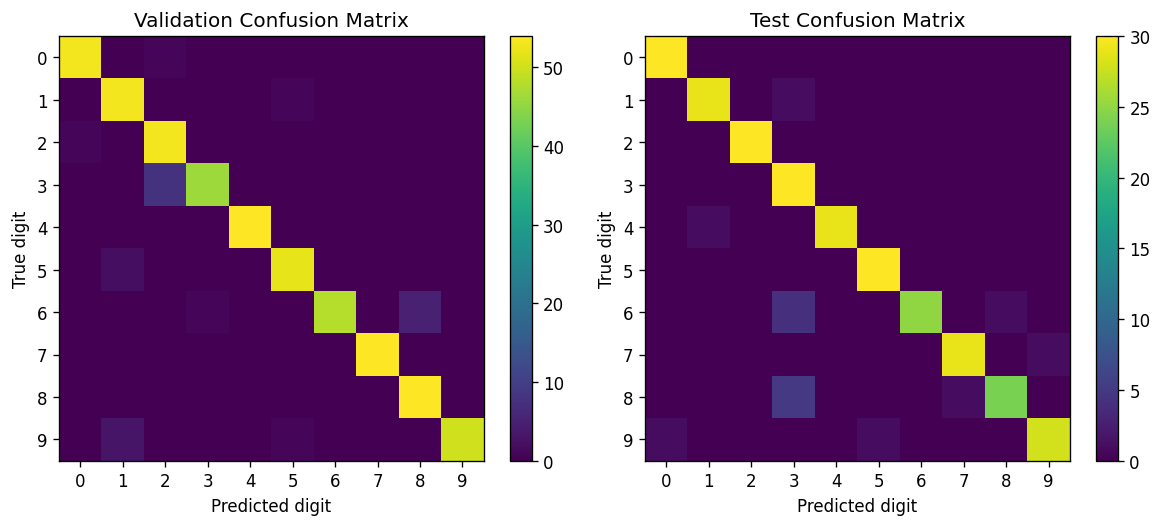

In [ ]:
# ==============================================================
# STEP 13 — Confusion Matrices & Overall Accuracy
#   • 2 confusion matrices (10×10): VALIDATION, TEST
#   • rows: true digit, columns: predicted digit
#   • overall accuracy = sum(diag) / total samples
# ==============================================================

import numpy as np
import matplotlib.pyplot as plt

# --- Preconditions ---
_required_13 = ["digits", "val_dic", "test_dic",
                "predict_digit", "final_hmms", "best"]
_missing_13 = [v for v in _required_13 if v not in globals()]
if _missing_13:
    raise RuntimeError(f"Step 13: missing from previous steps: {_missing_13}")

# Models:
#  - For VALIDATION we use the best models from the grid (Step 11)
#  - For TEST we use the final models trained on TRAIN+VAL (Step 12)
hmms_val  = best["hmms"]       # dict {digit -> HMM}, trained on TRAIN only
hmms_test = final_hmms         # dict {digit -> HMM}, trained on TRAIN+VAL

# Map each digit to an index 0..9 for matrix rows/cols
digits_sorted = sorted(digits)
digit_to_idx  = {d: i for i, d in enumerate(digits_sorted)}
K = len(digits_sorted)         # should be 10

# Initialize confusion matrices
cm_val  = np.zeros((K, K), dtype=int)
cm_test = np.zeros((K, K), dtype=int)

# ---------------- VALIDATION CONFUSION MATRIX ----------------
val_true, val_pred = [], []

for true_digit in sorted(val_dic.keys()):
    Xd, _, _, _ = val_dic[true_digit]
    for seq in Xd:
        pred = predict_digit(hmms_val, seq)
        val_true.append(true_digit)
        val_pred.append(pred)

        i = digit_to_idx[true_digit]  # row (true)
        j = digit_to_idx[pred]        # col (pred)
        cm_val[i, j] += 1

val_total = cm_val.sum()
val_acc_overall = np.trace(cm_val) / val_total if val_total > 0 else 0.0
print(f"[Step 13] VALIDATION overall accuracy from confusion matrix: {val_acc_overall:.4f}")

print("\nVALIDATION Confusion Matrix (rows=true, cols=pred):")
print(cm_val)

# ---------------- TEST CONFUSION MATRIX ----------------
test_true_cm, test_pred_cm = [], []

for true_digit in sorted(test_dic.keys()):
    Xd, _, _, _ = test_dic[true_digit]
    for seq in Xd:
        pred = predict_digit(hmms_test, seq)
        test_true_cm.append(true_digit)
        test_pred_cm.append(pred)

        i = digit_to_idx[true_digit]  # row (true)
        j = digit_to_idx[pred]        # col (pred)
        cm_test[i, j] += 1

test_total = cm_test.sum()
test_acc_overall = np.trace(cm_test) / test_total if test_total > 0 else 0.0
print(f"\n[Step 13] TEST overall accuracy from confusion matrix: {test_acc_overall:.4f}")

print("\nTEST Confusion Matrix (rows=true, cols=pred):")
print(cm_test)

# ---------------- Optional: heatmap plots for the report ----------------
fig, axes = plt.subplots(1, 2, figsize=(10, 4.5), dpi=120)

# Validation heatmap
im1 = axes[0].imshow(cm_val, interpolation="nearest", aspect="auto")
axes[0].set_title("Validation Confusion Matrix")
axes[0].set_xlabel("Predicted digit")
axes[0].set_ylabel("True digit")
axes[0].set_xticks(range(K))
axes[0].set_yticks(range(K))
axes[0].set_xticklabels(digits_sorted)
axes[0].set_yticklabels(digits_sorted)
plt.colorbar(im1, ax=axes[0])

# Test heatmap
im2 = axes[1].imshow(cm_test, interpolation="nearest", aspect="auto")
axes[1].set_title("Test Confusion Matrix")
axes[1].set_xlabel("Predicted digit")
axes[1].set_ylabel("True digit")
axes[1].set_xticks(range(K))
axes[1].set_yticks(range(K))
axes[1].set_xticklabels(digits_sorted)
axes[1].set_yticklabels(digits_sorted)
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()


## **Step 14 - LSTMs**

---


### **Step 14 — Preparatory Cell (parser, splits, scaling, dataset, loaders)**

#### **Goal**
Load MFCC sequences with `n_mfcc = 6`, apply the dataset’s default TRAIN/TEST rule, derive a stratified TRAIN/VAL split, normalize using TRAIN-only statistics, and produce ready-to-use DataLoaders that yield `(padded_seq, label, length)`.

#### **Data loading & splitting**
- **Input**: Free Spoken Digit Dataset (`recordings/*.wav`).
- **Default TRAIN/TEST rule**: utterances whose filename id ∈ {`0,1,2,3,4`} go to **TEST**; all others form the **TRAIN-like pool**.
- **Validation split**: from the TRAIN-like pool, build **TRAIN** and **VAL** via a stratified 80/20 split on digit labels to preserve class balance.

#### **Feature extraction (MFCC)**
- For each utterance waveform, compute MFCCs with **`n_mfcc = 6`** on short-time frames (≈30 ms window, ≈50% overlap).  
- Each utterance becomes a variable-length sequence **`(T_i × D)`**, where **`D = 6`**.

**Normalization**
- Fit a standardization transform **only on TRAIN frames** (concatenate all TRAIN frames), then apply the same transform to **TRAIN/VAL/TEST**:  
  $
  x' = \frac{x - \mu_{\text{train}}}{\sigma_{\text{train}}}
  $
- This avoids leakage of VAL/TEST statistics into the model.

#### **Dataset & loaders**
- For each split, compute its **max sequence length** \(L_{\max}\) and **zero-pad** shorter sequences to shape **`(N, L_max, D)`**; keep a vector `length` with each item’s true frame count.
- DataLoaders:
  - TRAIN: `batch_size = 32`, `shuffle = True`.
  - VAL/TEST: `batch_size = 32`, `shuffle = False`.

#### **Determinism**
- Set seeds for `numpy`, `random`, and `torch` to stabilize initialization and batching.

#### **Outputs**
- Tensors and loaders: `train_loader`, `val_loader`, `test_loader`.  
- Shapes: batches have `x: (N, L_max, 6)`, `y: (N,)`, `length: (N,)`.


In [2]:
# ==============================================================
# STEP 14 — Preparatory Cell (progress-style, like Step 9)
#   • Parser (n_mfcc=6) + default TRAIN/TEST
#   • Stratified TRAIN/VAL (80/20)
#   • Scaling with TRAIN-only statistics
#   • Dataset (padding + lengths) and DataLoaders
# ==============================================================

import os, random, time
from glob import glob
from typing import List
from collections import Counter

import numpy as np
import librosa
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm

# ---------------- Reproducibility ----------------
SEED = 0
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

# ---------------- Helper: Step-9-style distribution print ----------------
def show_distribution(labels, name):
    counts = Counter(labels)
    total = len(labels)
    print(f"\n{name} distribution (total {total}):")
    for digit in sorted(counts.keys()):
        c = counts[digit]
        pct = c / max(1, total)
        print(f"  digit {digit}: {c} samples ({pct:.2%})")

# ---------------- Parser definitions (with progress bars) ----------------
def parse_free_digits(directory: str):
    """
    Return wavs, Fs, ids (as strings), y (digits), speakers.
    Shows a progress bar while loading audio files.
    """
    files = sorted(glob(os.path.join(directory, "*.wav")))
    if not files:
        raise FileNotFoundError(f"No .wav files found under: {directory}")

    def parse_parts(path):
        base = os.path.basename(path)
        stem = os.path.splitext(base)[0]   # e.g., "7_jackson_32"
        digit, speaker, uid = stem.split("_")
        return int(digit), speaker, uid

    # Read sampling frequency from first file
    _, Fs = librosa.load(files[0], sr=None)

    wavs, ids, y, speakers = [], [], [], []
    for f in tqdm(files, desc="Loading wav files...", leave=False):
        d, spk, uid = parse_parts(f)
        wav, _ = librosa.load(f, sr=None)
        wavs.append(wav)
        ids.append(uid)
        y.append(d)
        speakers.append(spk)

    print(f"Total wavs: {len(wavs)}. Fs = {Fs} Hz")
    return wavs, Fs, ids, y, speakers


def extract_features(wavs: List[np.ndarray], n_mfcc=6, Fs=8000):
    """
    Compute MFCCs with 30 ms window, 50% overlap. Shows a progress bar.
    Returns list of arrays of shape (T_i, n_mfcc).
    """
    window = 30 * Fs // 1000
    step   = window // 2
    frames = []
    for wav in tqdm(wavs, desc="Extracting MFCC features...", leave=False):
        M = librosa.feature.mfcc(
            y=wav,
            sr=Fs,
            n_fft=window,
            hop_length=window - step,
            n_mfcc=n_mfcc
        ).T
        frames.append(M.astype(np.float32))
    print(f"Feature extraction completed with {n_mfcc} mfccs per frame")
    return frames


def split_free_digits(frames, ids, speakers, labels):
    """
    Default split used in FSDD:
      ids in {'0','1','2','3','4'} → TEST, else → TRAIN-like pool.
    """
    print("Splitting in train test split using the default dataset split")
    X_train, y_train, spk_train = [], [], []
    X_test,  y_test,  spk_test  = [], [], []
    test_ids = {"0", "1", "2", "3", "4"}
    for idx, frame, lab, spk in zip(ids, frames, labels, speakers):
        if str(idx) in test_ids:
            X_test.append(frame);  y_test.append(lab);  spk_test.append(spk)
        else:
            X_train.append(frame); y_train.append(lab); spk_train.append(spk)
    return X_train, X_test, y_train, y_test, spk_train, spk_test


def make_scale_fn(X_train: List[np.ndarray]):
    """
    Fit StandardScaler on TRAIN frames only and return a transform.
    """
    scaler = StandardScaler()
    scaler.fit(np.concatenate([x for x in X_train if len(x) > 0], axis=0))
    print("Normalization will be performed using TRAIN-only mean/std")

    def scale(X: List[np.ndarray]) -> List[np.ndarray]:
        return [scaler.transform(fr).astype(np.float32) for fr in X]

    return scale


def parser(directory: str, n_mfcc=6):
    wavs, Fs, ids, y, speakers = parse_free_digits(directory)
    frames = extract_features(wavs, n_mfcc=n_mfcc, Fs=Fs)
    return split_free_digits(frames, ids, speakers, y)

# ---------------- Robust finder for 'recordings' (mirrors prior workflow) ----------------
def find_recordings_dir():
    # 1) If 'drive_base' exists (used earlier), try that canonical path
    if "drive_base" in globals():
        candidate = os.path.join(
            drive_base,
            "NTUA-Pattern_Recognition/Lab1/pr_lab2_data/free-spoken-digit-dataset/recordings"
        )
        if os.path.isdir(candidate):
            return candidate

    # 2) Common relative locations
    candidates = [
        "recordings",
        os.path.join("free-spoken-digit-dataset", "recordings"),
        os.path.join("pr_lab2_data", "free-spoken-digit-dataset", "recordings"),
    ]
    for p in candidates:
        if os.path.isdir(p):
            return p

    # 3) Shallow search for a folder named 'recordings' that contains wavs
    for root, dirs, files in os.walk(".", topdown=True):
        depth = os.path.relpath(root, ".").count(os.sep)
        if depth > 4:    # keep it fast
            dirs[:] = []
            continue
        if os.path.basename(root) == "recordings" and glob(os.path.join(root, "*.wav")):
            return root

    raise FileNotFoundError("Could not find 'recordings/' folder.")

# ---------------- Locate recordings and align working directory (like Step 9) ----------------
recordings_abs = find_recordings_dir()
parent_dir     = os.path.dirname(recordings_abs)
recordings_dirname = os.path.basename(recordings_abs)  # "recordings"
os.chdir(parent_dir)
print(f"[Path] Using recordings at: {os.path.abspath(recordings_abs)}")

# ---------------- Load sequences (n_mfcc=6) and default TRAIN/TEST ----------------
t0 = time.time()
X_pool, X_test, y_pool, y_test, spk_pool, spk_test = parser(recordings_dirname, n_mfcc=6)
print(f"\nInitial train set size: {len(X_pool)} samples")
print(f"Initial test  set size: {len(X_test)} samples")
if len(X_pool):
    print(f"Example utterance feature matrix shape: {X_pool[0].shape}")
    print(f"Example label: {y_pool[0]}")
print(f"[Timing] Load+features+split: {time.time() - t0:.2f}s")

# ---------------- Stratified TRAIN/VAL split (80/20) ----------------
X_train, X_val, y_train, y_val, spk_train, spk_val = train_test_split(
    X_pool, y_pool, spk_pool, test_size=0.20, stratify=y_pool, random_state=SEED
)

print("\nAfter stratified split:")
print(f"Final TRAIN size    : {len(X_train)}")
print(f"VALIDATION size     : {len(X_val)}")
print(f"TEST size (held out): {len(X_test)}")

# ---------------- Normalize with TRAIN-only statistics ----------------
t1 = time.time()
scale_fn = make_scale_fn(X_train)

X_train = scale_fn(X_train)
X_val   = scale_fn(X_val)
X_test  = scale_fn(X_test)
print("\nApplied normalization using TRAIN statistics only.")
print(f"[Timing] Scaling: {time.time() - t1:.2f}s")

# ---------------- Show class balance per split (Step-9 style) ----------------
show_distribution(y_train, "TRAIN")
show_distribution(y_val,   "VAL")
show_distribution(y_test,  "TEST")

# ---------------- Dataset with zero-padding per split ----------------
class SeqDataset(Dataset):
    """
    Returns (padded_seq, label, length).
    Padding up to the split’s max length; 'length' is the true number of frames.
    """
    def __init__(self, feats: List[np.ndarray], labels: List[int]):
        assert len(feats) == len(labels)
        self.lengths  = [int(f.shape[0]) for f in feats]
        self.max_len  = max(self.lengths) if self.lengths else 0
        self.feat_dim = int(feats[0].shape[1]) if feats else 0

        N = len(feats)
        padded = np.zeros((N, self.max_len, self.feat_dim), dtype=np.float32)
        for i, f in enumerate(feats):
            T = f.shape[0]
            if T > 0:
                padded[i, :T, :] = f.astype(np.float32)

        self.x   = torch.from_numpy(padded)               # (N, Lmax, D)
        self.y   = torch.tensor(labels, dtype=torch.long) # (N,)
        self.len = torch.tensor(self.lengths, dtype=torch.long)

    def __len__(self): return self.y.shape[0]
    def __getitem__(self, idx): return self.x[idx], self.y[idx], self.len[idx]

# ---------------- Build datasets & dataloaders ----------------
trainset = SeqDataset(X_train, y_train)
valset   = SeqDataset(X_val,   y_val)
testset  = SeqDataset(X_test,  y_test)

BATCH_SIZE = 32
train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True,  drop_last=False)
val_loader   = DataLoader(valset,   batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader  = DataLoader(testset,  batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

print(f"\n[OK] Dataloaders ready | D={trainset.x.shape[-1]}")
print(f"Lmax: train={trainset.x.shape[1]}, val={valset.x.shape[1]}, test={testset.x.shape[1]}")


[Path] Using recordings at: /content/drive/MyDrive/NTUA-Pattern_Recognition/Lab1/pr_lab2_data/free-spoken-digit-dataset/recordings


Loading wav files...:   0%|          | 0/3000 [00:00<?, ?it/s]

Total wavs: 3000. Fs = 8000 Hz


Extracting MFCC features...:   0%|          | 0/3000 [00:00<?, ?it/s]

Feature extraction completed with 6 mfccs per frame
Splitting in train test split using the default dataset split

Initial train set size: 2700 samples
Initial test  set size: 300 samples
Example utterance feature matrix shape: (50, 6)
Example label: 0
[Timing] Load+features+split: 142.17s

After stratified split:
Final TRAIN size    : 2160
VALIDATION size     : 540
TEST size (held out): 300
Normalization will be performed using TRAIN-only mean/std

Applied normalization using TRAIN statistics only.
[Timing] Scaling: 0.72s

TRAIN distribution (total 2160):
  digit 0: 216 samples (10.00%)
  digit 1: 216 samples (10.00%)
  digit 2: 216 samples (10.00%)
  digit 3: 216 samples (10.00%)
  digit 4: 216 samples (10.00%)
  digit 5: 216 samples (10.00%)
  digit 6: 216 samples (10.00%)
  digit 7: 216 samples (10.00%)
  digit 8: 216 samples (10.00%)
  digit 9: 216 samples (10.00%)

VAL distribution (total 540):
  digit 0: 54 samples (10.00%)
  digit 1: 54 samples (10.00%)
  digit 2: 54 samples (1

### **Steps 14.1–14.3 — Simple LSTM (Train-only) — Hyperparameter Sweep**

#### **Objective**
Train a simple LSTM **only on TRAIN** and compare runs by **final training loss**.  
In this step we **do not** use bidirectionality, dropout, weight decay (L2), or early stopping.  
We also **save per-epoch snapshots** so that Step 14.4 can compute **validation curves per epoch without retraining**.

#### **Hyperparameters (exact values used)**
- `rnn_size` (hidden units): **[16, 32, 64]**  
- `num_layers` (depth): **[1, 2, 3]**  
- `batch_size`: **[16, 32]**  
- `epochs` (fixed per trial): **[15, 23, 30]**  
- `lr` (AdamW learning rate): **[1e-4, 5e-4, 1e-3]**

#### **Disabled (kept constant in this step)**
- `bidirectional = False`  
- `dropout = 0.0`  
- `weight_decay = 0.0` (no L2)  
- **No early stopping** (every trial runs its full epoch budget)

#### **Determinism**
A deterministic per-configuration seed is derived from the hyperparameters;  
we also set a global seed for the sweep controller to ensure reproducibility.

#### **Console output**
- Printed **leaderboard** sorted by final training loss (top-30 shown).  
- Explicit summary of **best** and **worst** configurations.



[Sweep] Evaluating FULL grid of 162 trials (no bidi, no dropout, no weight_decay; no early stopping)


Trials:   0%|          | 0/162 [00:00<?, ?it/s]


=== Leaderboard (by final TRAIN loss, ascending) ===
 1. 0.0113 | rnn=64, layers=1, bs=16, epochs=30, lr=0.001 | Step14_checkpoints_train_only/model_r64_L1_bs16_e30_lr1e-03.pt
 2. 0.0128 | rnn=64, layers=3, bs=32, epochs=30, lr=0.001 | Step14_checkpoints_train_only/model_r64_L3_bs32_e30_lr1e-03.pt
 3. 0.0210 | rnn=64, layers=2, bs=16, epochs=23, lr=0.001 | Step14_checkpoints_train_only/model_r64_L2_bs16_e23_lr1e-03.pt
 4. 0.0236 | rnn=64, layers=2, bs=16, epochs=30, lr=0.0005 | Step14_checkpoints_train_only/model_r64_L2_bs16_e30_lr5e-04.pt
 5. 0.0256 | rnn=64, layers=3, bs=16, epochs=30, lr=0.0005 | Step14_checkpoints_train_only/model_r64_L3_bs16_e30_lr5e-04.pt
 6. 0.0277 | rnn=64, layers=3, bs=32, epochs=30, lr=0.0005 | Step14_checkpoints_train_only/model_r64_L3_bs32_e30_lr5e-04.pt
 7. 0.0278 | rnn=64, layers=2, bs=32, epochs=30, lr=0.0005 | Step14_checkpoints_train_only/model_r64_L2_bs32_e30_lr5e-04.pt
 8. 0.0305 | rnn=32, layers=2, bs=32, epochs=30, lr=0.001 | Step14_checkpoints_tr

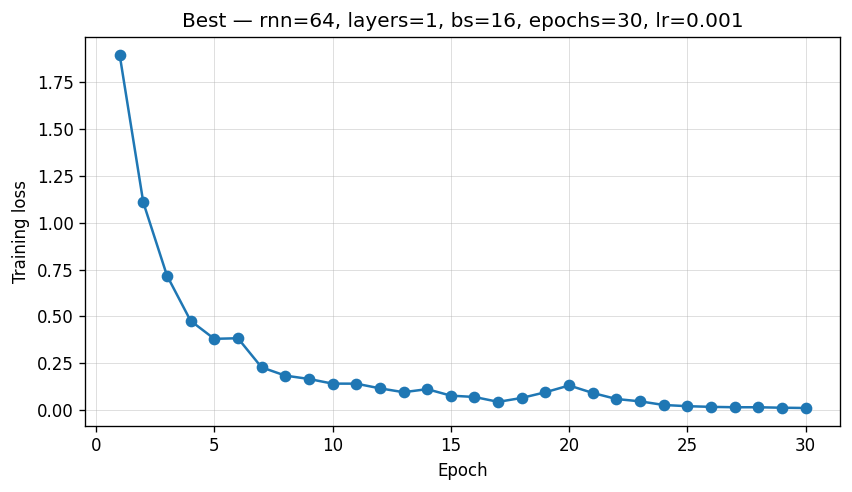

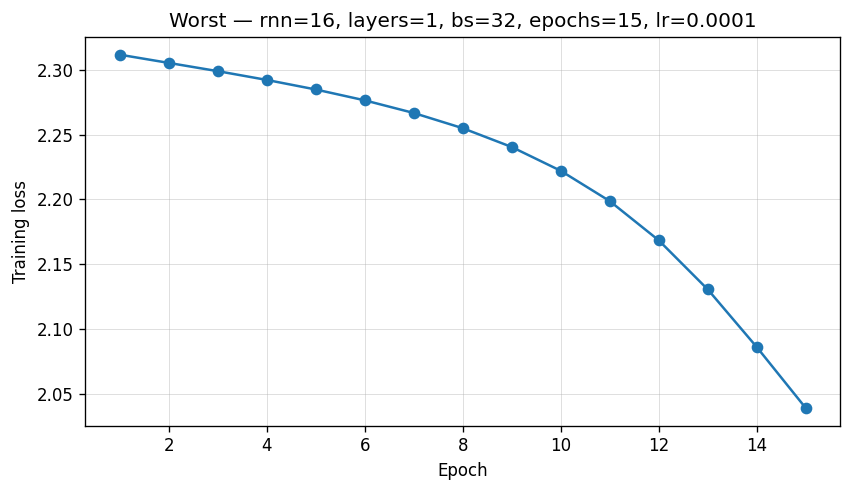


[Saved]
  - Checkpoints (*.pt): Step14_checkpoints_train_only/
  - Leaderboard CSV:    Step14_checkpoints_train_only/leaderboard_train_only.csv
  - Leaderboard JSON:   Step14_checkpoints_train_only/leaderboard_train_only.json
  - Loss plots:         Step14_checkpoints_train_only/Step 14.1-14.3 - *.png


In [3]:
# ==============================================================
# Steps 14.1–14.3 — Simple LSTM (Train-only) — Save All Models (+ per-epoch snapshots)
#   - Trains on TRAIN only (no early stopping, no dropout, no L2)
#   - Saves a checkpoint for EVERY configuration (to be validated in 14.4)
#   - Also saves per-epoch snapshots
#   - Plots best/worst TRAIN loss curves
# ==============================================================

import os, json, itertools, numpy as np, random, torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm

# ---------------- Reproducibility for the sweep controller ----------------
GLOBAL_SEED = 0
np.random.seed(GLOBAL_SEED); random.seed(GLOBAL_SEED); torch.manual_seed(GLOBAL_SEED)

# ---------------- Data dims from the preparatory cell ----------------
# These come from your Step 14 "Preparatory Cell"
INPUT_DIM   = train_loader.dataset.x.shape[-1]
NUM_CLASSES = 10

# ---------------- Full Search Space ----------------
rnn_sizes     = [16, 32, 64]
num_layers_es = [1, 2, 3]
batch_sizes   = [16, 32]
epochs_es     = [15, 23, 30]
lrs           = [1e-4, 5e-4, 1e-3]

# ---------------- Fixed off (as per 14.1–14.3 spec) ----------------
BIDIRECTIONAL = False
DROPOUT       = 0.0
WEIGHT_DECAY  = 0.0

# ---------------- Snapshot controls ----------------
SAVE_SNAPSHOTS = True     # save every epoch
# (If storage becomes an issue, you can snapshot every k epochs. Keep it =1 for per-epoch VAL.)
SNAPSHOT_EVERY = 1

# ---------------- Output directories & files ----------------
CKPT_DIR = Path("Step14_checkpoints_train_only")
CKPT_DIR.mkdir(parents=True, exist_ok=True)
LEADERBOARD_CSV  = CKPT_DIR / "leaderboard_train_only.csv"
LEADERBOARD_JSON = CKPT_DIR / "leaderboard_train_only.json"

# ---------------- Utilities ----------------
def make_train_loader(bs: int):
    """Create a TRAIN loader with the requested batch size."""
    return DataLoader(trainset, batch_size=bs, shuffle=True, drop_last=False)

class SimpleLSTM(nn.Module):
    """
    Minimal LSTM classifier for the sweep:
      LSTM (no dropout, unidirectional) -> last valid timestep -> Linear(NUM_CLASSES)
    """
    def __init__(self, input_dim: int, hidden: int, num_layers: int, num_classes: int):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=BIDIRECTIONAL,                   # fixed OFF here
            dropout=(0.0 if num_layers == 1 else DROPOUT)  # disabled in this step
        )
        out_dim = hidden * (2 if BIDIRECTIONAL else 1)
        self.fc = nn.Linear(out_dim, num_classes)

    @staticmethod
    def last_valid(outputs: torch.Tensor, lengths: torch.Tensor) -> torch.Tensor:
        """
        Gather the last non-padded frame for each sequence.
        outputs: (N, L, F), lengths: (N,)
        """
        idx = (lengths - 1).view(-1, 1, 1).expand(outputs.size(0), 1, outputs.size(2))
        return outputs.gather(1, idx).squeeze(1)  # (N, F)

    def forward(self, x, lengths):
        out, _ = self.lstm(x)                # (N, L, F)
        last   = self.last_valid(out, lengths)
        return self.fc(last)                 # (N, C)

def seed_for_cfg(cfg: dict) -> int:
    """Deterministic per-config seed derived from hyperparameters."""
    return (GLOBAL_SEED
            + cfg["rnn_size"] * 3
            + cfg["num_layers"] * 5
            + cfg["batch_size"] * 7
            + int(cfg["lr"] * 1e6) * 11
            + cfg["epochs"] * 13)

def cfg_to_str(cfg: dict) -> str:
    return (f"rnn={cfg['rnn_size']}, layers={cfg['num_layers']}, "
            f"bs={cfg['batch_size']}, epochs={cfg['epochs']}, lr={cfg['lr']}")

def lr_token(lr: float) -> str:
    """Filename-safe token for LR (e.g., 0.001 -> '1e-03')."""
    return f"{lr:.0e}".replace("+", "")

def cfg_id(cfg: dict) -> str:
    """Stable, filename-safe id for a config."""
    return f"r{cfg['rnn_size']}_L{cfg['num_layers']}_bs{cfg['batch_size']}_e{cfg['epochs']}_lr{lr_token(cfg['lr'])}"

def save_checkpoint(model: nn.Module,
                    cfg: dict,
                    train_losses: list,
                    final_train_loss: float,
                    seed_used: int,
                    path: Path,
                    snapshots_dir: Path | None = None):
    """
    Save everything needed for 14.4 validation:
      - model_state (final weights)
      - cfg (+ input_dim/num_classes + fixed flags)
      - train_losses (history) and final_train_loss
      - seed for reproducibility
      - snapshots_dir (relative) if epoch snapshots were saved
    """
    ckpt = {
        "model_state": model.state_dict(),
        "cfg": {
            **cfg,
            "input_dim": INPUT_DIM,
            "num_classes": NUM_CLASSES,
            "bidirectional": BIDIRECTIONAL,
            "dropout": DROPOUT,
            "weight_decay": WEIGHT_DECAY,
        },
        "train_losses": train_losses,
        "final_train_loss": float(final_train_loss),
        "seed": seed_used,
    }
    if snapshots_dir is not None:
        try:
            ckpt["snapshots_dir"] = str(snapshots_dir.relative_to(CKPT_DIR))
        except Exception:
            ckpt["snapshots_dir"] = str(snapshots_dir)
    torch.save(ckpt, path)

# ---------------- Full cartesian grid ----------------
all_combos = list(itertools.product(rnn_sizes, num_layers_es, batch_sizes, epochs_es, lrs))
print(f"[Sweep] Evaluating FULL grid of {len(all_combos)} trials "
      f"(no bidi, no dropout, no weight_decay; no early stopping)")

# ---------------- Train a single configuration ----------------
def train_one_config(cfg):
    # Per-trial deterministic seeding
    seed = seed_for_cfg(cfg)
    np.random.seed(seed); random.seed(seed); torch.manual_seed(seed)

    model = SimpleLSTM(
        input_dim=INPUT_DIM,
        hidden=cfg["rnn_size"],
        num_layers=cfg["num_layers"],
        num_classes=NUM_CLASSES,
    )
    optimizer = torch.optim.AdamW(model.parameters(), lr=cfg["lr"], weight_decay=WEIGHT_DECAY)
    criterion = nn.CrossEntropyLoss()

    tr_loader = make_train_loader(cfg["batch_size"])

    # Prepare snapshot folder
    snapshot_dir = None
    if SAVE_SNAPSHOTS:
        snapshot_dir = CKPT_DIR / f"snap_{cfg_id(cfg)}"
        snapshot_dir.mkdir(parents=True, exist_ok=True)

    train_losses = []
    for epoch in range(1, cfg["epochs"] + 1):
        model.train()
        tot, n = 0.0, 0
        for xb, yb, lb in tr_loader:
            optimizer.zero_grad(set_to_none=True)
            logits = model(xb, lb)
            loss   = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            tot += loss.item() * yb.size(0)
            n   += yb.size(0)
        train_losses.append(tot / max(1, n))

        # Save per-epoch snapshot (BiLSTM not used here, so just state_dict is enough)
        if SAVE_SNAPSHOTS and (epoch % SNAPSHOT_EVERY == 0):
            torch.save({"model_state": model.state_dict()},
                       snapshot_dir / f"epoch_{epoch:03d}.pt")

    final_loss = float(train_losses[-1])

    # Save checkpoint for 14.4 validation
    fname = f"model_{cfg_id(cfg)}.pt"
    save_checkpoint(model, cfg, train_losses, final_loss, seed, CKPT_DIR / fname, snapshots_dir=snapshot_dir)
    return final_loss, train_losses, fname

# ---------------- Run the sweep, save EVERYTHING, and report ----------------
results = []  # rows: {"cfg":..., "final_train_loss":..., "losses":..., "checkpoint":..., "cfg_id":..., "cfg_str":...}

for (rnn_size, num_layers, batch_size, epochs, lr) in tqdm(all_combos, desc="Trials"):
    cfg = {
        "rnn_size":  rnn_size,
        "num_layers": num_layers,
        "batch_size": batch_size,
        "epochs":     epochs,
        "lr":         lr,
    }
    final_loss, losses, fname = train_one_config(cfg)
    results.append({
        "cfg": cfg,
        "final_train_loss": final_loss,
        "losses": losses,
        "checkpoint": str(CKPT_DIR / fname),
        "cfg_id": cfg_id(cfg),
        "cfg_str": cfg_to_str(cfg),
    })

# ---------------- Rank by final TRAIN loss ----------------
results_sorted = sorted(results, key=lambda r: r["final_train_loss"])
best  = results_sorted[0]
worst = results_sorted[-1]

# ---------------- Persist leaderboard (CSV + JSON) ----------------
df = pd.DataFrame([{
    "cfg_id": r["cfg_id"],
    "rnn_size": r["cfg"]["rnn_size"],
    "num_layers": r["cfg"]["num_layers"],
    "batch_size": r["cfg"]["batch_size"],
    "epochs": r["cfg"]["epochs"],
    "lr": r["cfg"]["lr"],
    "final_train_loss": r["final_train_loss"],
    "checkpoint": r["checkpoint"],
} for r in results_sorted])

df.to_csv(LEADERBOARD_CSV, index=False)
with open(LEADERBOARD_JSON, "w") as f:
    json.dump(results_sorted, f, indent=2)

# ---------------- Console leaderboard (top 30 shown) ----------------
print("\n=== Leaderboard (by final TRAIN loss, ascending) ===")
show_n = min(30, len(results_sorted))
for i, r in enumerate(results_sorted[:show_n], 1):
    print(f"{i:2d}. {r['final_train_loss']:.4f} | {r['cfg_str']} | {r['checkpoint']}")

print(f"\nBest : {best['final_train_loss']:.4f} | {best['cfg_str']} | {best['checkpoint']}")
print(f"Worst: {worst['final_train_loss']:.4f} | {worst['cfg_str']} | {worst['checkpoint']}")

# ---------------- Plot TRAIN loss curves for best and worst ----------------
plt.figure(figsize=(7.2, 4.2), dpi=120)
plt.plot(range(1, len(best["losses"])+1), best["losses"], marker="o")
plt.xlabel("Epoch"); plt.ylabel("Training loss")
plt.title(f"Best — {best['cfg_str']}")
plt.grid(True, linewidth=0.4, alpha=0.6); plt.tight_layout()
plt.savefig(CKPT_DIR / "Step 14.1-14.3 - Best Training Loss Curve.png")
plt.show()

plt.figure(figsize=(7.2, 4.2), dpi=120)
plt.plot(range(1, len(worst["losses"])+1), worst["losses"], marker="o")
plt.xlabel("Epoch"); plt.ylabel("Training loss")
plt.title(f"Worst — {worst['cfg_str']}")
plt.grid(True, linewidth=0.4, alpha=0.6); plt.tight_layout()
plt.savefig(CKPT_DIR / "Step 14.1-14.3 - Worst Training Loss Curve.png")
plt.show()

print("\n[Saved]")
print(f"  - Checkpoints (*.pt): {CKPT_DIR}/")
print(f"  - Leaderboard CSV:    {LEADERBOARD_CSV}")
print(f"  - Leaderboard JSON:   {LEADERBOARD_JSON}")
print(f"  - Loss plots:         {CKPT_DIR}/Step 14.1-14.3 - *.png")


### **Step 14.4 — Validation of Saved Models (per-epoch from snapshots)**

#### **Objective**
Evaluate **all models saved in Steps 14.1–14.3** on the **validation set** to obtain **per-epoch validation curves**  
(`val_loss`, `val_acc`). This allows ranking configurations by **best validation performance** without retraining.

Each model’s snapshots are loaded epoch by epoch and evaluated directly on the VAL split.

#### **Snapshot logic (per checkpoint)**
- **A)** If an external snapshot folder `snap_<cfg_id>/epoch_*.pt` exists → evaluate each saved epoch weight (**fast path**).  
- **B)** Else, if the checkpoint contains in-memory epoch states → evaluate them (**rare**).  
- **C)** Else, perform a **single-pass fallback** using only the final model weights (no per-epoch curve).

#### **Model architecture**
Same `SimpleLSTM` as in Steps 14.1–14.3:
- Unidirectional LSTM (no dropout, no regularization)
- Output: last valid timestep → linear layer → 10-way softmax

#### **Inputs**
- `Step14_checkpoints_train_only/leaderboard_train_only.json`  
  (produced by Steps 14.1–14.3)
- `snap_<cfg_id>/epoch_*.pt` directories containing saved snapshots
- `val_loader` (must be defined from the Step-14 preparatory cell)

#### **Outputs**
- Sorted by **best validation loss** (tie-breaker: higher validation accuracy)
- Includes for each configuration:
  - Full per-epoch `val_curve` and `val_acc_curve`
  - `best_epoch`, `best_val_loss`, `best_val_acc`
  - Corresponding training curve (`train_curve_used`)
  - Checkpoint path for reloading

#### **Figures**
Two per-epoch comparison plots:
1. `Step 14.4 - Best (Train+Val Curves).png` — lowest validation loss  
2. `Step 14.4 - Worst (Train+Val Curves).png` — highest validation loss  

Both display **training vs. validation loss curves** across epochs.

#### **Console output**
- Summary of top configurations (sorted by best validation loss)
- Best and worst models with details:
  - `rnn_size`, `num_layers`, `batch_size`, `epochs`, `lr`, `best_epoch`
  - Validation loss/accuracy and final training loss

> This step bridges the training-only sweep and the later regularized/early-stopping stages.  
> It establishes a **validation-based ranking** of all pure-training models,  
> setting the foundation for dropout/L2 tuning in Steps 14.5–14.6.


[14.4] Validating 162 trained models on the VAL set (per-epoch from snapshots)...


Per-epoch validation:   0%|          | 0/162 [00:00<?, ?it/s]


=== Step 14.4 — Top models by BEST VAL loss (ascending) ===
 1. best_val_loss=0.0649 | val_acc@best=0.9796 | train_loss_last=0.0128 | best_epoch=21 | rnn=64, L=3, bs=32, e=30, lr=0.001 | Step14_checkpoints_train_only/model_r64_L3_bs32_e30_lr1e-03.pt
 2. best_val_loss=0.0704 | val_acc@best=0.9833 | train_loss_last=0.0791 | best_epoch=24 | rnn=64, L=2, bs=32, e=30, lr=0.001 | Step14_checkpoints_train_only/model_r64_L2_bs32_e30_lr1e-03.pt
 3. best_val_loss=0.0723 | val_acc@best=0.9889 | train_loss_last=0.0113 | best_epoch=26 | rnn=64, L=1, bs=16, e=30, lr=0.001 | Step14_checkpoints_train_only/model_r64_L1_bs16_e30_lr1e-03.pt
 4. best_val_loss=0.0724 | val_acc@best=0.9796 | train_loss_last=0.0803 | best_epoch=27 | rnn=64, L=3, bs=16, e=30, lr=0.001 | Step14_checkpoints_train_only/model_r64_L3_bs16_e30_lr1e-03.pt
 5. best_val_loss=0.0732 | val_acc@best=0.9852 | train_loss_last=0.0551 | best_epoch=24 | rnn=64, L=2, bs=16, e=30, lr=0.001 | Step14_checkpoints_train_only/model_r64_L2_bs16_e30_

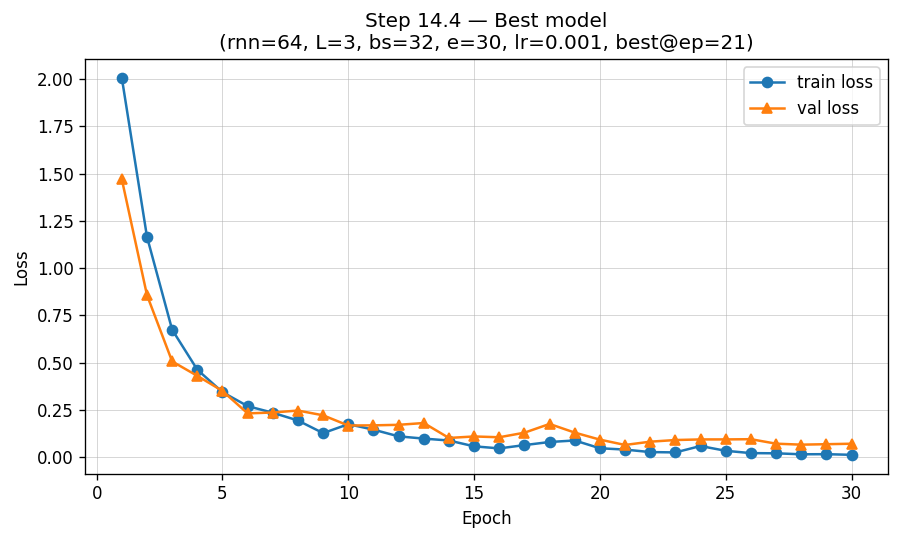

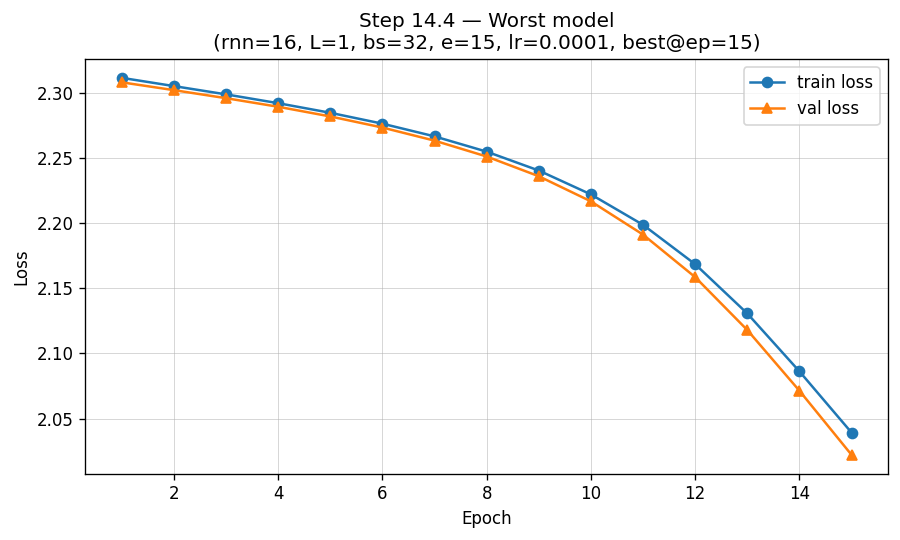

In [4]:
# ==============================================================
# Step 14.4 — Validate ALL saved models on VAL (per-epoch, from snapshots)
#   + Builds full VAL curves (val_loss, val_acc per epoch) using saved epoch snapshots
#   + Ranks by best VAL loss across epochs (tie-break: higher val_acc)
#   + Plots BEST/WORST with TRAIN vs VAL curves (per-epoch)
# ==============================================================

import os, json, math, glob, torch, numpy as np, pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm
from torch.utils.data import DataLoader

# ---------------- Expected artifacts from Step 14.1–14.3 ----------------
CKPT_DIR            = Path("Step14_checkpoints_train_only")
LEADERBOARD_JSON_IN = CKPT_DIR / "leaderboard_train_only.json"   # produced earlier
LEADERBOARD_CSV_OUT = CKPT_DIR / "leaderboard_with_val.csv"      # produced here
LEADERBOARD_JSON_OUT= CKPT_DIR / "leaderboard_with_val.json"     # produced here
PLOTS_DIR           = CKPT_DIR

assert CKPT_DIR.is_dir(), f"Missing directory: {CKPT_DIR}"
assert LEADERBOARD_JSON_IN.is_file(), f"Missing file: {LEADERBOARD_JSON_IN}"
assert 'val_loader' in globals(), "Run the preparatory cell first to create val_loader."

# ---------------- Model definition (must match 14.1–14.3) ----------------
class SimpleLSTM(nn.Module):
    """
    Same architecture used during the training-only sweep:
      LSTM (unidirectional, dropout off) -> last valid timestep -> Linear(NUM_CLASSES)
    """
    def __init__(self, input_dim: int, hidden: int, num_layers: int, num_classes: int, bidirectional: bool):
        super().__init__()
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=0.0  # disabled in 14.1–14.3
        )
        out_dim = hidden * (2 if bidirectional else 1)
        self.fc = nn.Linear(out_dim, num_classes)

    @staticmethod
    def last_valid(outputs: torch.Tensor, lengths: torch.Tensor) -> torch.Tensor:
        idx = (lengths - 1).view(-1, 1, 1).expand(outputs.size(0), 1, outputs.size(2))
        return outputs.gather(1, idx).squeeze(1)

    def forward(self, x, lengths):
        out, _ = self.lstm(x)                # (N, L, F)
        last   = self.last_valid(out, lengths)
        return self.fc(last)                 # (N, C)

def rebuild_model_from_cfg(cfg: dict) -> nn.Module:
    return SimpleLSTM(
        input_dim     = int(cfg["input_dim"]),
        hidden        = int(cfg["rnn_size"]),
        num_layers    = int(cfg["num_layers"]),
        num_classes   = int(cfg.get("num_classes", 10)),
        bidirectional = bool(cfg.get("bidirectional", False)),
    )

# ---------------- Helpers ----------------
@torch.no_grad()
def eval_once(model: nn.Module, loader, criterion: nn.Module):
    """Average cross-entropy loss and accuracy on a split."""
    model.eval()
    total_loss, total_n, total_correct = 0.0, 0, 0
    for xb, yb, lb in loader:
        logits = model(xb, lb)
        loss   = criterion(logits, yb)
        total_loss += loss.item() * yb.size(0)
        total_n    += yb.size(0)
        pred = logits.argmax(dim=1)
        total_correct += (pred == yb).sum().item()
    return float(total_loss / max(1, total_n)), float(total_correct / max(1, total_n))

def _snapshots_for_ckpt(ckpt_obj: dict, ckpt_path: Path):
    """
    Return a list of epoch snapshot file paths in ascending order, if available.
    Preference:
      1) external directory pointed by 'snapshots_dir'
      2) in-memory list 'epoch_states' (rare; handled by returning ('in_memory', list))
    """
    # External folder
    snap_dir = ckpt_obj.get("snapshots_dir", None)
    if snap_dir is not None:
        sd = Path(snap_dir)
        if not sd.is_absolute():
            sd = ckpt_path.parent / sd
        files = sorted(glob.glob(str(sd / "epoch_*.pt")))
        if files:
            return ("external", files)
    # In-memory list
    snaps = ckpt_obj.get("epoch_states", None)
    if isinstance(snaps, list) and len(snaps) > 0:
        return ("in_memory", snaps)
    return (None, None)

def plot_train_and_val_curves(train_losses, val_losses, title, outpath):
    """TRAIN vs VAL loss curves on the same axes (per-epoch)."""
    plt.figure(figsize=(7.6, 4.6), dpi=120)
    if len(train_losses) > 0:
        plt.plot(range(1, len(train_losses)+1), train_losses, marker="o", label="train loss")
    if len(val_losses) > 0:
        plt.plot(range(1, len(val_losses)+1),   val_losses,   marker="^", label="val loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title(title)
    plt.grid(True, linewidth=0.5, alpha=0.6); plt.legend(); plt.tight_layout()
    outpath.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(outpath); plt.show()

# ---------------- Load training-only leaderboard ----------------
with open(LEADERBOARD_JSON_IN, "r") as f:
    train_only_entries = json.load(f)
assert isinstance(train_only_entries, list) and len(train_only_entries) > 0, "Empty leaderboard JSON."

criterion = nn.CrossEntropyLoss()
val_results = []  # rows with cfg + train_loss + best val stats + curves + checkpoint

print(f"[14.4] Validating {len(train_only_entries)} trained models on the VAL set (per-epoch from snapshots)...")

for item in tqdm(train_only_entries, desc="Per-epoch validation"):
    ckpt_path = Path(item["checkpoint"])
    assert ckpt_path.is_file(), f"Missing checkpoint file: {ckpt_path}"

    ckpt_obj = torch.load(ckpt_path, map_location="cpu")
    cfg = ckpt_obj.get("cfg", item.get("cfg", {}))  # prefer inside-ckpt cfg (has input_dim, etc.)

    # Build model shape and load final weights (used to init before loading epoch states)
    model = rebuild_model_from_cfg(cfg)
    model.load_state_dict(ckpt_obj["model_state"])

    # TRAIN curve: use what's stored (full per-epoch)
    train_curve = ckpt_obj.get("train_losses", item.get("losses", []))

    # Snapshot discovery
    snap_kind, snap_data = _snapshots_for_ckpt(ckpt_obj, ckpt_path)

    val_curve, acc_curve = [], []

    if snap_kind == "external":
        # Evaluate each saved 'epoch_*.pt' file
        for p in snap_data:
            blob = torch.load(p, map_location="cpu")
            state = blob.get("model_state", blob)
            model.load_state_dict(state)
            vl, va = eval_once(model, val_loader, criterion)
            val_curve.append(vl); acc_curve.append(va)

    elif snap_kind == "in_memory":
        # Evaluate each in-memory state_dict (rare)
        for state in snap_data:
            model.load_state_dict(state)
            vl, va = eval_once(model, val_loader, criterion)
            val_curve.append(vl); acc_curve.append(va)

    else:
        # Fallback: single-pass on final weights (no per-epoch curve available)
        vl, va = eval_once(model, val_loader, criterion)
        val_curve = [vl]; acc_curve = [va]
        tqdm.write(f"[WARN] No snapshots found for {ckpt_path.name} → single-pass fallback")

    # Best epoch selection by lowest val loss; break ties by higher acc
    val_arr = np.array(val_curve, dtype=float)
    acc_arr = np.array(acc_curve, dtype=float) if len(acc_curve) == len(val_curve) else np.full_like(val_arr, np.nan)
    best_ep = int(np.argmin(val_arr))
    best_val = float(val_arr[best_ep])
    best_acc = float(acc_arr[best_ep]) if not np.isnan(acc_arr[best_ep]) else float('nan')

    # Compose row (keys consumed by later steps)
    val_results.append({
        "cfg_id": item["cfg_id"],
        "rnn_size": int(cfg["rnn_size"]),
        "num_layers": int(cfg["num_layers"]),
        "batch_size": int(cfg["batch_size"]),
        "epochs": int(cfg["epochs"]),
        "lr": float(cfg["lr"]),
        "final_train_loss": float(ckpt_obj.get("final_train_loss", train_curve[-1] if train_curve else math.nan)),
        "val_loss": best_val,              # BEST across epochs
        "val_acc": best_acc,               # acc at the best-VAL-loss epoch
        "best_epoch": int(best_ep + 1),
        "val_curve": list(map(float, val_curve)),
        "val_acc_curve": (list(map(float, acc_curve)) if len(acc_curve) == len(val_curve) else []),
        "train_curve_used": list(map(float, train_curve)),
        "checkpoint": str(ckpt_path),
    })

# ---------------- Rank by val_loss & persist ----------------
df_val = pd.DataFrame(val_results)
df_by_val_loss = df_val.sort_values(["val_loss", "final_train_loss"], ascending=[True, True]).reset_index(drop=True)

df_by_val_loss.to_csv(LEADERBOARD_CSV_OUT, index=False)
with open(LEADERBOARD_JSON_OUT, "w") as f:
    json.dump(df_by_val_loss.to_dict(orient="records"), f, indent=2)

# ---------------- Print concise summary ----------------
print("\n=== Step 14.4 — Top models by BEST VAL loss (ascending) ===")
top_n = min(30, len(df_by_val_loss))
for i in range(top_n):
    row = df_by_val_loss.iloc[i]
    print(f"{i+1:2d}. best_val_loss={row.val_loss:.4f} | val_acc@best={row.val_acc:.4f} "
          f"| train_loss_last={row.final_train_loss:.4f} | best_epoch={row.best_epoch} "
          f"| rnn={row.rnn_size}, L={row.num_layers}, bs={row.batch_size}, e={row.epochs}, lr={row.lr} "
          f"| {row.checkpoint}")

print(f"\n[Saved] Validation leaderboard (by BEST val loss): {LEADERBOARD_CSV_OUT}")
print(f"[Saved] Validation leaderboard (JSON):            {LEADERBOARD_JSON_OUT}")

# ---------------- Diagrams: Best & Worst (TRAIN curve + VAL curve) ----------------
def _get_train_curve_from_ckpt(path: Path):
    b = torch.load(path, map_location="cpu")
    return b.get("train_losses", b.get("losses", []))

best_row  = df_by_val_loss.iloc[0]
worst_row = df_by_val_loss.iloc[-1]

best_train_curve = best_row.get("train_curve_used", []) or _get_train_curve_from_ckpt(Path(best_row["checkpoint"]))
worst_train_curve= worst_row.get("train_curve_used", []) or _get_train_curve_from_ckpt(Path(worst_row["checkpoint"]))

# Plot and save (TRAIN vs VAL curves) — per-epoch
plot_train_and_val_curves(
    best_train_curve,
    list(best_row["val_curve"]),
    title=(f"Step 14.4 — Best model\n"
           f"(rnn={best_row.rnn_size}, L={best_row.num_layers}, bs={best_row.batch_size}, "
           f"e={best_row.epochs}, lr={best_row.lr}, best@ep={best_row.best_epoch})"),
    outpath=PLOTS_DIR / "Step 14.4 - Best (Train+Val Curves).png"
)

plot_train_and_val_curves(
    worst_train_curve,
    list(worst_row["val_curve"]),
    title=(f"Step 14.4 — Worst model\n"
           f"(rnn={worst_row.rnn_size}, L={worst_row.num_layers}, bs={worst_row.batch_size}, "
           f"e={worst_row.epochs}, lr={worst_row.lr}, best@ep={worst_row.best_epoch})"),
    outpath=PLOTS_DIR / "Step 14.4 - Worst (Train+Val Curves).png"
)


### **Steps 14.5–14.6 — Dropout & L2: FIXED (cap=30) vs EARLY STOPPING (≤30)**

#### **Goal**
Starting from the **Top-K bases** selected in **Step 14.4**, explore explicit regularization:
- **Dropout** and **L2 weight decay** across small grids
- Compare two training regimes **under identical seeds**:
  - **FIXED-30E**: exactly 30 epochs (no early stopping)
  - **EARLY**: up to 30 epochs with early stopping on **VAL loss** (patience = 3, min_delta = 1e-4)

This step produces separate leaderboards per regime and a **text-only** cross-regime comparison.

#### **Setup**
- **TOP_K**: `5` (best 5 base configs from Step 14.4)
- **EPOCHS_MAX**: `30`
- **Grids**:
  - `dropout ∈ {0.0, 0.2, 0.4}`
  - `weight_decay ∈ {0.0, 1e−4, 1e−3}`
- **Optimizer**: AdamW (per base LR from Step 14.4)
- **Architecture**: same unidirectional LSTM shape as the selected base (no BiLSTM here)
- **Seeding**: per-trial seeds depend on the **base hyperparams + (dropout, weight_decay)**  
  and are **identical across regimes** for fair comparison.

#### **Inputs**
- From Step 14.4:
  - `Step14_checkpoints_train_only/leaderboard_with_val.json`  
    (to identify the Top-K base configurations)

- Data:
  - `trainset`, `valset` (provided by the Step-14 preparatory cell)

#### **Outputs**
- **Console summaries**:
  - Did explicit regularization help vs (dropout=0, wd=0) baseline? (per regime)
  - Count/mean Δloss statistics and selected knobs
  - Early vs Fixed effect (counts + mean/median deltas)

#### **Figures**
1. `FIXED_30E - BEST (Train+Val).png` — **Best** trial in FIXED-30E (TRAIN & VAL loss curves)
2. `FIXED_30E - WORST (Train+Val).png` — **Worst** trial in FIXED-30E (TRAIN & VAL loss curves)
3. `EARLY - BEST (Train+Val).png` — **Best** trial in EARLY (TRAIN & VAL loss curves)
4. `EARLY - WORST (Train+Val).png` — **Worst** trial in EARLY (TRAIN & VAL loss curves)

#### **What this step answers**
- **Regularization impact**: Do dropout/L2 **reduce VAL loss** compared to no-reg baselines?
- **Regime impact**: Does **early stopping** outperform **fixed-epoch** training for the same base and seed?
- **Best/worst behavior**: How do TRAIN vs VAL losses evolve over epochs for the extremes in each regime?



[14.5–14.6] Retraining TOP-5 base configs with new regs (dropout, weight_decay).
   rnn_size  num_layers  batch_size     lr  val_loss   val_acc
0        64           3          32  0.001  0.064910  0.979630
1        64           2          32  0.001  0.070433  0.983333
2        64           1          16  0.001  0.072290  0.988889
3        64           3          16  0.001  0.072350  0.979630
4        64           2          16  0.001  0.073201  0.985185

[FIXED_30E | Base 01/5] r64_L3_bs32_lr1e-03 (epochs_max=30)


FIXED_30E r64_L3_bs32_lr1e-03 — grid:   0%|          | 0/9 [00:00<?, ?it/s]


[FIXED_30E | Base 02/5] r64_L2_bs32_lr1e-03 (epochs_max=30)


FIXED_30E r64_L2_bs32_lr1e-03 — grid:   0%|          | 0/9 [00:00<?, ?it/s]


[FIXED_30E | Base 03/5] r64_L1_bs16_lr1e-03 (epochs_max=30)


FIXED_30E r64_L1_bs16_lr1e-03 — grid:   0%|          | 0/9 [00:00<?, ?it/s]


[FIXED_30E | Base 04/5] r64_L3_bs16_lr1e-03 (epochs_max=30)


FIXED_30E r64_L3_bs16_lr1e-03 — grid:   0%|          | 0/9 [00:00<?, ?it/s]


[FIXED_30E | Base 05/5] r64_L2_bs16_lr1e-03 (epochs_max=30)


FIXED_30E r64_L2_bs16_lr1e-03 — grid:   0%|          | 0/9 [00:00<?, ?it/s]


[EARLY | Base 01/5] r64_L3_bs32_lr1e-03 (epochs_max=30)


EARLY r64_L3_bs32_lr1e-03 — grid:   0%|          | 0/9 [00:00<?, ?it/s]

EARLY: Early stopping at epoch 14/30
EARLY: Early stopping at epoch 19/30
EARLY: Early stopping at epoch 12/30
EARLY: Early stopping at epoch 15/30
EARLY: Early stopping at epoch 15/30
EARLY: Early stopping at epoch 22/30
EARLY: Early stopping at epoch 20/30
EARLY: Early stopping at epoch 15/30
EARLY: Early stopping at epoch 17/30

[EARLY | Base 02/5] r64_L2_bs32_lr1e-03 (epochs_max=30)


EARLY r64_L2_bs32_lr1e-03 — grid:   0%|          | 0/9 [00:00<?, ?it/s]

EARLY: Early stopping at epoch 16/30
EARLY: Early stopping at epoch 17/30
EARLY: Early stopping at epoch 14/30
EARLY: Early stopping at epoch 25/30
EARLY: Early stopping at epoch 18/30
EARLY: Early stopping at epoch 13/30
EARLY: Early stopping at epoch 10/30
EARLY: Early stopping at epoch 21/30
EARLY: Early stopping at epoch 16/30

[EARLY | Base 03/5] r64_L1_bs16_lr1e-03 (epochs_max=30)


EARLY r64_L1_bs16_lr1e-03 — grid:   0%|          | 0/9 [00:00<?, ?it/s]

EARLY: Early stopping at epoch 24/30
EARLY: Early stopping at epoch 12/30
EARLY: Early stopping at epoch 16/30
EARLY: Early stopping at epoch 21/30
EARLY: Early stopping at epoch 19/30
EARLY: Early stopping at epoch 13/30
EARLY: Early stopping at epoch 13/30
EARLY: Early stopping at epoch 15/30
EARLY: Early stopping at epoch 20/30

[EARLY | Base 04/5] r64_L3_bs16_lr1e-03 (epochs_max=30)


EARLY r64_L3_bs16_lr1e-03 — grid:   0%|          | 0/9 [00:00<?, ?it/s]

EARLY: Early stopping at epoch 12/30
EARLY: Early stopping at epoch 19/30
EARLY: Early stopping at epoch 12/30
EARLY: Early stopping at epoch 15/30
EARLY: Early stopping at epoch 17/30
EARLY: Early stopping at epoch 25/30
EARLY: Early stopping at epoch 18/30
EARLY: Early stopping at epoch 26/30
EARLY: Early stopping at epoch 19/30

[EARLY | Base 05/5] r64_L2_bs16_lr1e-03 (epochs_max=30)


EARLY r64_L2_bs16_lr1e-03 — grid:   0%|          | 0/9 [00:00<?, ?it/s]

EARLY: Early stopping at epoch 12/30
EARLY: Early stopping at epoch 19/30
EARLY: Early stopping at epoch 18/30
EARLY: Early stopping at epoch 17/30
EARLY: Early stopping at epoch 18/30
EARLY: Early stopping at epoch 19/30
EARLY: Early stopping at epoch 15/30
EARLY: Early stopping at epoch 27/30
EARLY: Early stopping at epoch 18/30

[Saved] FIXED-30E leaderboard (written to leaderboard_FIXED_30E.csv/leaderboard_FIXED_30E.json) in Step14_reg_top30_compare_30ep
[Saved] EARLY leaderboard     (written to leaderboard_EARLY.csv/leaderboard_EARLY.json) in Step14_reg_top30_compare_30ep


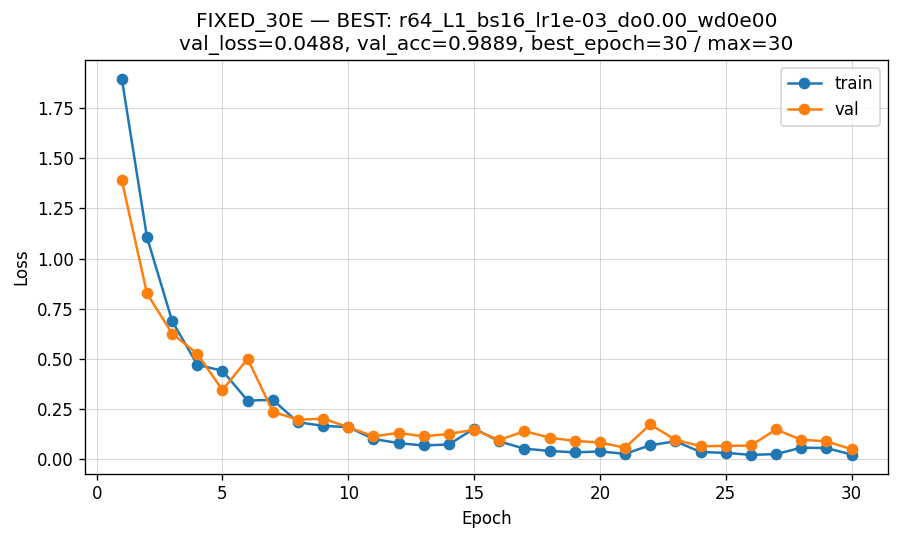

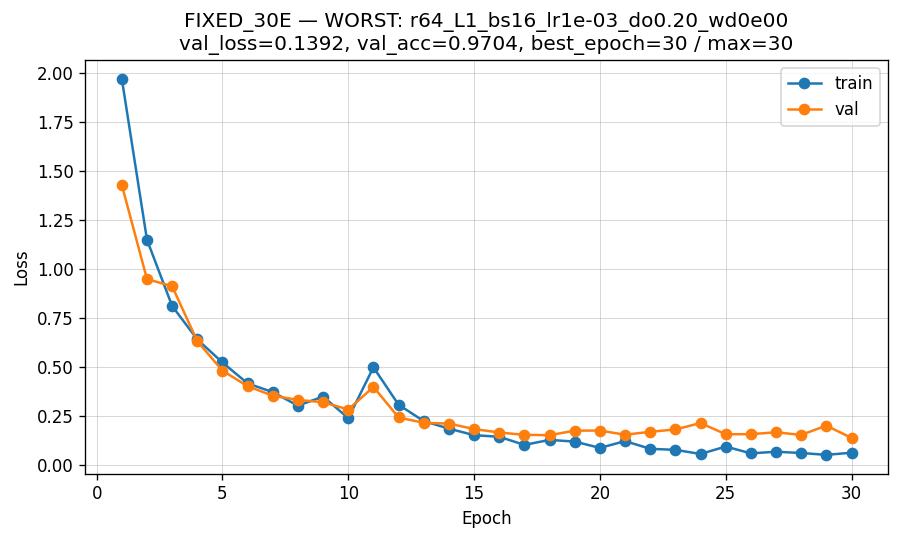


[FIXED_30E] BEST: {'regime': 'FIXED_30E', 'base_id': 'r64_L1_bs16_lr1e-03', 'rnn_size': 64, 'num_layers': 1, 'batch_size': 16, 'lr': 0.001, 'dropout': 0.0, 'weight_decay': 0.0, 'best_val_loss': 0.048786090721410734, 'best_val_acc': 0.9888888888888889, 'epochs_run': 30, 'best_epoch': 30, 'checkpoint': 'Step14_reg_top30_compare_30ep/FIXED_30E/r64_L1_bs16_lr1e-03/best_FIXED_30E_r64_L1_bs16_lr1e-03_do0.00_wd0e00.pt', 'trial_tag': 'r64_L1_bs16_lr1e-03_do0.00_wd0e00'}
[FIXED_30E] WORST: {'regime': 'FIXED_30E', 'base_id': 'r64_L1_bs16_lr1e-03', 'rnn_size': 64, 'num_layers': 1, 'batch_size': 16, 'lr': 0.001, 'dropout': 0.2, 'weight_decay': 0.0, 'best_val_loss': 0.13922928919222344, 'best_val_acc': 0.9703703703703703, 'epochs_run': 30, 'best_epoch': 30, 'checkpoint': 'Step14_reg_top30_compare_30ep/FIXED_30E/r64_L1_bs16_lr1e-03/best_FIXED_30E_r64_L1_bs16_lr1e-03_do0.20_wd0e00.pt', 'trial_tag': 'r64_L1_bs16_lr1e-03_do0.20_wd0e00'}


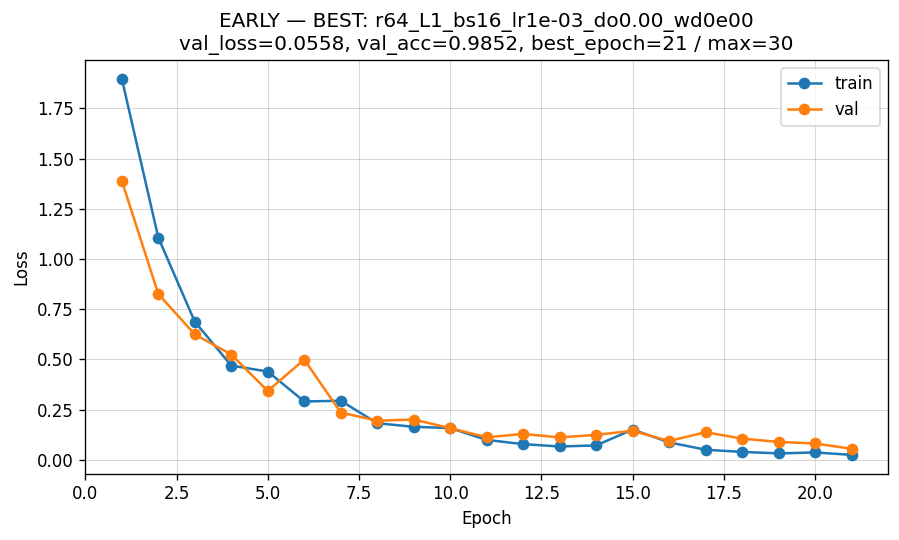

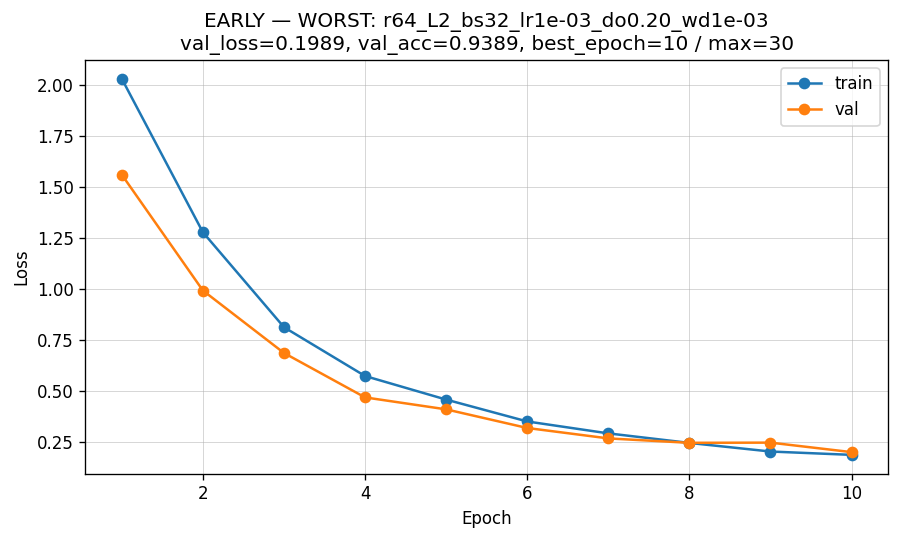


[EARLY] BEST: {'regime': 'EARLY', 'base_id': 'r64_L1_bs16_lr1e-03', 'rnn_size': 64, 'num_layers': 1, 'batch_size': 16, 'lr': 0.001, 'dropout': 0.0, 'weight_decay': 0.0, 'best_val_loss': 0.055761068742032405, 'best_val_acc': 0.9851851851851852, 'epochs_run': 24, 'best_epoch': 21, 'checkpoint': 'Step14_reg_top30_compare_30ep/EARLY_STOP/r64_L1_bs16_lr1e-03/best_EARLY_r64_L1_bs16_lr1e-03_do0.00_wd0e00.pt', 'trial_tag': 'r64_L1_bs16_lr1e-03_do0.00_wd0e00'}
[EARLY] WORST: {'regime': 'EARLY', 'base_id': 'r64_L2_bs32_lr1e-03', 'rnn_size': 64, 'num_layers': 2, 'batch_size': 32, 'lr': 0.001, 'dropout': 0.2, 'weight_decay': 0.001, 'best_val_loss': 0.19885988103018867, 'best_val_acc': 0.9388888888888889, 'epochs_run': 13, 'best_epoch': 10, 'checkpoint': 'Step14_reg_top30_compare_30ep/EARLY_STOP/r64_L2_bs32_lr1e-03/best_EARLY_r64_L2_bs32_lr1e-03_do0.20_wd1e-03.pt', 'trial_tag': 'r64_L2_bs32_lr1e-03_do0.20_wd1e-03'}

[Saved] Per-base comparison table: Step14_reg_top30_compare_30ep/compare_per_base_

In [5]:
# ==============================================================
# Steps 14.5–14.6 — Dropout + L2, FIXED (cap=30) vs EARLY STOPPING (≤30)
#   • Two regimes over the SAME seeds for fairness:
#       (A) FIXED-30E : train for exactly EPOCHS_MAX (=30) epochs (no early stopping)
#       (B) EARLY     : up to EPOCHS_MAX (=30) epochs with Early Stopping on VAL loss (patience=3)
#   • Build separate leaderboards for both regimes + cross-regime comparison
#   • Also print clear summaries: did dropout/L2 help? did early stopping help?
#
# IMPORTANT:
#   • TOP_K = 5 (use only the 5 best bases from Step 14.4)
#   • EPOCHS_MAX = 30
#   • DROPOUT and WEIGHT_DECAY grids include 0.0 (ablation baselines)
#
# Output diagrams:
#   1) Best model from FIXED (TRAIN+VAL curves)
#   2) Worst model from FIXED (TRAIN+VAL curves)
#   3) Best model from EARLY  (TRAIN+VAL curves)
#   4) Worst model from EARLY (TRAIN+VAL curves)
# ==============================================================

import os, json, math, numpy as np, random, torch
import torch.nn as nn
from torch.utils.data import DataLoader
from pathlib import Path
from tqdm.auto import tqdm
import pandas as pd
import matplotlib.pyplot as plt

# --------------------------- Preconditions ---------------------------
assert 'trainset' in globals() and 'valset' in globals(), \
    "Run the Step-14 Preparatory Cell first (must define trainset/valset)."

# Infer input feature dimension (matches earlier SeqDataset)
INPUT_DIM   = int(trainset.x.shape[-1])
NUM_CLASSES = 10

CKPT_DIR_14_4    = Path("Step14_checkpoints_train_only")
LEADERBOARD_14_4 = CKPT_DIR_14_4 / "leaderboard_with_val.json"
assert LEADERBOARD_14_4.is_file(), f"Missing Step 14.4 leaderboard: {LEADERBOARD_14_4}"

# --------------------------- Experiment knobs ---------------------------
TOP_K       = 5                  # Top-5 bases from step 14.4
EPOCHS_MAX  = 30                 # Train up to 30 epochs per trial
DROPOUT_GRID       = [0.0, 0.2, 0.4]       # includes 0.0 (no dropout baseline)
WEIGHT_DECAY_GRID  = [0.0, 1e-4, 1e-3]     # includes 0.0 (no L2 baseline)
PATIENCE    = 3                  # Early stopping patience
MIN_DELTA   = 1e-4               # Min improvement on val loss to reset patience

# Reproducibility (regime-independent seeds)
GLOBAL_SEED = 0
np.random.seed(GLOBAL_SEED); random.seed(GLOBAL_SEED); torch.manual_seed(GLOBAL_SEED)

# --------------------------- Outputs (30ep / 30E) ---------------------------
ROOT = Path("Step14_reg_top30_compare_30ep")
ROOT.mkdir(parents=True, exist_ok=True)
FIXED_DIR = ROOT / "FIXED_30E"
EARLY_DIR = ROOT / "EARLY_STOP"
for d in (FIXED_DIR, EARLY_DIR):
    d.mkdir(parents=True, exist_ok=True)

# Leaderboards
LB_FIXED_CSV  = ROOT / "leaderboard_FIXED_30E.csv"
LB_FIXED_JSON = ROOT / "leaderboard_FIXED_30E.json"
LB_EARLY_CSV  = ROOT / "leaderboard_EARLY.csv"
LB_EARLY_JSON = ROOT / "leaderboard_EARLY.json"

# Only the 4 requested plots
PLOT_FIXED_BEST  = ROOT / "FIXED_30E - BEST (Train+Val).png"
PLOT_FIXED_WORST = ROOT / "FIXED_30E - WORST (Train+Val).png"
PLOT_EARLY_BEST  = ROOT / "EARLY - BEST (Train+Val).png"
PLOT_EARLY_WORST = ROOT / "EARLY - WORST (Train+Val).png"

# --------------------------- Utilities & model ---------------------------
def lr_token(lr: float) -> str:
    """Filename-safe token for learning rate."""
    return f"{lr:.0e}".replace("+","")

def base_cfg_id(rnn_size: int, num_layers: int, batch_size: int, lr: float) -> str:
    """Stable, filename-safe id for a base config (from Step 14.4)."""
    return f"r{rnn_size}_L{num_layers}_bs{batch_size}_lr{lr_token(lr)}"

def make_loaders(bs: int):
    """Build TRAIN/VAL loaders for a given batch size (test not needed here)."""
    train_loader = DataLoader(trainset, batch_size=bs, shuffle=True,  drop_last=False)
    val_loader   = DataLoader(valset,   batch_size=bs, shuffle=False, drop_last=False)
    return train_loader, val_loader

def seed_for_trial(base_tuple, dropout_p: float, weight_decay: float) -> int:
    """
    Per-trial deterministic seed mixing base hyperparams & new regs.
    NOTE: Does NOT depend on the regime (FIXED vs EARLY) so both regimes
          start from identical initializations → fair comparison.
    """
    (rnn_size, num_layers, batch_size, lr) = base_tuple
    return (GLOBAL_SEED
            + rnn_size * 3
            + num_layers * 5
            + batch_size * 7
            + int(lr * 1e6) * 11
            + EPOCHS_MAX * 13
            + int(dropout_p * 1000) * 17
            + int(weight_decay * 1e6) * 19)

class EarlyStopping:
    """Stop if val_loss fails to improve by MIN_DELTA for PATIENCE epochs."""
    def __init__(self, patience: int, min_delta: float = 0.0):
        self.patience   = patience
        self.min_delta  = min_delta
        self.best       = math.inf
        self.bad_epochs = 0
    def step(self, current: float) -> bool:
        improved = (self.best - current) > self.min_delta
        if improved:
            self.best = current
            self.bad_epochs = 0
            return False
        self.bad_epochs += 1
        return self.bad_epochs >= self.patience

class BasicLSTM(nn.Module):
    """
    LSTM classifier with regularization:
      • LSTM stack with inter-layer dropout when num_layers > 1 (PyTorch semantics)
      • Post-LSTM dropout before the classifier (always applied)
      • Unidirectional (BiLSTM handled elsewhere)
    """
    def __init__(self, input_dim: int, hidden: int, num_layers: int,
                 num_classes: int, dropout_p: float, bidirectional: bool = False):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=(dropout_p if num_layers > 1 else 0.0),
        )
        out_dim = hidden * (2 if bidirectional else 1)
        self.post_dropout = nn.Dropout(dropout_p)
        self.fc = nn.Linear(out_dim, num_classes)

    @staticmethod
    def last_by_index(outputs: torch.Tensor, lengths: torch.Tensor) -> torch.Tensor:
        """Gather each sequence’s last valid timestep."""
        idx = (lengths - 1).view(-1, 1, 1).expand(outputs.size(0), 1, outputs.size(2))
        return outputs.gather(1, idx).squeeze(1)

    def forward(self, x, lengths):
        y, _ = self.lstm(x)           # (N, L, F)
        last = self.last_by_index(y, lengths)
        return self.fc(self.post_dropout(last))

def train_epoch(model: nn.Module, loader, opt, crit) -> float:
    """One training epoch: average loss on TRAIN."""
    model.train()
    tot, n = 0.0, 0
    for xb, yb, lb in loader:
        opt.zero_grad(set_to_none=True)
        logits = model(xb, lb)
        loss   = crit(logits, yb)
        loss.backward()
        opt.step()
        tot += loss.item() * yb.size(0)
        n   += yb.size(0)
    return float(tot / max(1, n))

@torch.no_grad()
def eval_epoch(model: nn.Module, loader, crit):
    """One evaluation epoch: (avg loss, accuracy) on VAL."""
    model.eval()
    tot, n, correct = 0.0, 0, 0
    for xb, yb, lb in loader:
        logits = model(xb, lb)
        loss   = crit(logits, yb)
        tot += loss.item() * yb.size(0)
        n   += yb.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == yb).sum().item()
    return float(tot / max(1, n)), float(correct / max(1, n))

def plot_curves(history, title: str, out_path: Path):
    """
    Plot TRAIN & VAL loss curves on the SAME axes and save PNG.
    Always shows the figure (no toggles).
    """
    plt.figure(figsize=(7.6, 4.6), dpi=120)
    plt.plot(range(1, len(history["train"])+1), history["train"], marker="o", label="train")
    plt.plot(range(1, len(history["val"])+1),   history["val"],   marker="o", label="val")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title(title)
    plt.grid(True, linewidth=0.5, alpha=0.6); plt.legend(); plt.tight_layout()
    out_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(out_path); plt.show()

# --------------------------- Load TOP-5 bases from Step 14.4 ---------------------------
rows_14_4 = json.loads(LEADERBOARD_14_4.read_text())
df_14_4 = pd.DataFrame(rows_14_4).sort_values(
    ["val_loss", "final_train_loss"], ascending=[True, True]
).reset_index(drop=True)
top_base = df_14_4.head(TOP_K).copy()

print(f"[14.5–14.6] Retraining TOP-{TOP_K} base configs with new regs (dropout, weight_decay).")
print(top_base[["rnn_size","num_layers","batch_size","lr","val_loss","val_acc"]])

# --------------------------- Core runner for each regime ---------------------------
def run_grid_for_regime(regime_label: str, use_early_stopping: bool, out_root: Path) -> pd.DataFrame:
    """
    Runs dropout × weight_decay grid across TOP-K bases for a given regime.
    - FIXED-30E : use_early_stopping=False → always perform EPOCHS_MAX (=30) epochs
    - EARLY     : use_early_stopping=True  → up to EPOCHS_MAX (=30) with early stopping
    Returns a sorted DataFrame with per-trial metrics and paths.
    """
    all_rows = []

    for idx, base_row in top_base.iterrows():
        # Base hyperparameters selected in Step 14.4 (arch, lr, batch)
        rnn_size   = int(base_row["rnn_size"])
        num_layers = int(base_row["num_layers"])
        batch_size = int(base_row["batch_size"])
        lr         = float(base_row["lr"])
        base_id    = base_cfg_id(rnn_size, num_layers, batch_size, lr)

        base_out = out_root / base_id
        base_out.mkdir(parents=True, exist_ok=True)

        print(f"\n[{regime_label} | Base {idx+1:02d}/{len(top_base)}] {base_id} (epochs_max={EPOCHS_MAX})")
        train_loader, val_loader = make_loaders(batch_size)

        grid = [(do, wd) for do in DROPOUT_GRID for wd in WEIGHT_DECAY_GRID]
        for (dropout_p, weight_decay) in tqdm(grid, desc=f"{regime_label} {base_id} — grid", leave=False):
            # Identical seed per (base, dropout, wd) across both regimes
            seed = seed_for_trial((rnn_size, num_layers, batch_size, lr), dropout_p, weight_decay)
            np.random.seed(seed); random.seed(seed); torch.manual_seed(seed)

            # Model/opt/crit
            model = BasicLSTM(INPUT_DIM, rnn_size, num_layers, NUM_CLASSES,
                              dropout_p=dropout_p, bidirectional=False)
            optim = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
            crit  = nn.CrossEntropyLoss()

            # Book-keeping
            history = {"train": [], "val": [], "val_acc": []}
            best_blob = None
            stopper   = EarlyStopping(PATIENCE, MIN_DELTA) if use_early_stopping else None

            trial_tag = f"{base_id}_do{dropout_p:.2f}_wd{weight_decay:.0e}".replace("+","")
            ckpt_path = base_out / f"best_{regime_label}_{trial_tag}.pt"

            # Epoch loop — always validate/log; EARLY may break sooner
            for ep in range(1, EPOCHS_MAX + 1):
                tr = train_epoch(model, train_loader, optim, crit)
                vl, va = eval_epoch(model, val_loader, crit)
                history["train"].append(tr)
                history["val"].append(vl)
                history["val_acc"].append(va)

                # Keep best by val loss
                if (best_blob is None) or (vl < best_blob["best_val_loss"] - 0.0):
                    best_blob = {
                        "model_state": model.state_dict(),
                        "meta": {
                            "input_dim": INPUT_DIM, "num_classes": NUM_CLASSES,
                            "rnn_size": rnn_size, "num_layers": num_layers,
                            "batch_size": batch_size, "epochs_cap": EPOCHS_MAX,
                            "lr": lr, "dropout": dropout_p, "weight_decay": weight_decay,
                            "bidirectional": False, "regime": regime_label
                        },
                        "history": {k: v[:] for k, v in history.items()},
                        "seed": seed,
                        "base_id": base_id,
                        "trial_tag": trial_tag,
                        "best_val_loss": vl,
                        "best_val_acc": va,
                        "best_epoch": ep,
                    }

                # Early stopping if enabled
                if use_early_stopping and stopper.step(vl):
                    tqdm.write(f"{regime_label}: Early stopping at epoch {ep}/{EPOCHS_MAX}")
                    break

            # Ensure we have a best epoch
            assert best_blob is not None, "No best epoch recorded; check loops."
            torch.save(best_blob, ckpt_path)

            all_rows.append({
                "regime": regime_label,
                "base_id": base_id,
                "rnn_size": rnn_size,
                "num_layers": num_layers,
                "batch_size": batch_size,
                "lr": lr,
                "dropout": dropout_p,
                "weight_decay": weight_decay,
                "best_val_loss": float(best_blob["best_val_loss"]),
                "best_val_acc": float(best_blob["best_val_acc"]),
                "epochs_run": len(history["val"]),
                "best_epoch": int(best_blob["best_epoch"]),
                "checkpoint": str(ckpt_path),
                "trial_tag": trial_tag,
            })

    df = pd.DataFrame(all_rows).sort_values(
        ["best_val_loss", "best_val_acc"], ascending=[True, False]
    ).reset_index(drop=True)
    return df

# --------------------------- Run BOTH regimes (same seeds) ---------------------------
df_FIXED = run_grid_for_regime("FIXED_30E", use_early_stopping=False, out_root=FIXED_DIR)
df_EARLY = run_grid_for_regime("EARLY",     use_early_stopping=True,  out_root=EARLY_DIR)

# Persist leaderboards
df_FIXED.to_csv(LB_FIXED_CSV, index=False)
with open(LB_FIXED_JSON, "w") as f: json.dump(df_FIXED.to_dict(orient="records"), f, indent=2)
df_EARLY.to_csv(LB_EARLY_CSV, index=False)
with open(LB_EARLY_JSON, "w") as f: json.dump(df_EARLY.to_dict(orient="records"), f, indent=2)

print(f"\n[Saved] FIXED-30E leaderboard (written to {LB_FIXED_CSV.name}/{LB_FIXED_JSON.name}) in {ROOT}")
print(f"[Saved] EARLY leaderboard     (written to {LB_EARLY_CSV.name}/{LB_EARLY_JSON.name}) in {ROOT}")

# --------------------------- ONLY the 4 requested diagrams ---------------------------
def plot_overall_extremes(df, regime_label: str, out_best: Path, out_worst: Path):
    best_row  = df.iloc[0]
    worst_row = df.iloc[-1]
    best_blob  = torch.load(Path(best_row["checkpoint"]),  map_location="cpu")
    worst_blob = torch.load(Path(worst_row["checkpoint"]), map_location="cpu")
    plot_curves(
        best_blob["history"],
        title=(f"{regime_label} — BEST: {best_row['trial_tag']}\n"
               f"val_loss={best_row['best_val_loss']:.4f}, val_acc={best_row['best_val_acc']:.4f}"
               f", best_epoch={best_row['best_epoch']} / max={EPOCHS_MAX}"),
        out_path=out_best
    )
    plot_curves(
        worst_blob["history"],
        title=(f"{regime_label} — WORST: {worst_row['trial_tag']}\n"
               f"val_loss={worst_row['best_val_loss']:.4f}, val_acc={worst_row['best_val_acc']:.4f}"
               f", best_epoch={worst_row['best_epoch']} / max={EPOCHS_MAX}"),
        out_path=out_worst
    )
    print(f"\n[{regime_label}] BEST:", best_row.to_dict())
    print(f"[{regime_label}] WORST:", worst_row.to_dict())

plot_overall_extremes(df_FIXED, "FIXED_30E", PLOT_FIXED_BEST, PLOT_FIXED_WORST)
plot_overall_extremes(df_EARLY, "EARLY",     PLOT_EARLY_BEST, PLOT_EARLY_WORST)

# --------------------------- Cross-regime comparison (per base) — TEXT ONLY ---------------------------
best_FIXED_by_base = (df_FIXED.sort_values(["base_id","best_val_loss","best_val_acc"], ascending=[True,True,False])
                            .groupby("base_id", as_index=False).first())
best_EARLY_by_base = (df_EARLY.sort_values(["base_id","best_val_loss","best_val_acc"], ascending=[True,True,False])
                            .groupby("base_id", as_index=False).first())

cmp = pd.merge(
    best_FIXED_by_base[["base_id","best_val_loss","best_val_acc"]],
    best_EARLY_by_base[["base_id","best_val_loss","best_val_acc"]],
    on="base_id", suffixes=("_FIXED_30E", "_EARLY")
)
cmp["delta_loss"] = cmp["best_val_loss_EARLY"] - cmp["best_val_loss_FIXED_30E"]  # negative ⇒ EARLY better
cmp["delta_acc"]  = cmp["best_val_acc_EARLY"]  - cmp["best_val_acc_FIXED_30E"]   # positive ⇒ EARLY better

CMP_CSV = ROOT / "compare_per_base_FIXED_30E_vs_EARLY.csv"
cmp.to_csv(CMP_CSV, index=False)
print(f"\n[Saved] Per-base comparison table: {CMP_CSV}")

# --------------------------- Explicit-regularization summary — TEXT ONLY ---------------------------
def summarize_explicit_regularization(df: pd.DataFrame, label: str):
    """
    For each base_id, compare best trial vs baseline (dropout=0, weight_decay=0) if present.
    Prints counts and mean Δloss (negative ⇒ regularization helped).
    """
    rows = []
    for base_id, g in df.groupby("base_id", sort=False):
        g = g.sort_values(["best_val_loss","best_val_acc"], ascending=[True,False]).reset_index(drop=True)
        best = g.iloc[0]
        base0 = g[(g["dropout"] == 0.0) & (g["weight_decay"] == 0.0)]
        if len(base0) > 0:
            base0 = base0.sort_values(["best_val_loss","best_val_acc"], ascending=[True,False]).iloc[0]
            delta = best["best_val_loss"] - base0["best_val_loss"]
        else:
            delta = np.nan
        rows.append({
            "base_id": base_id,
            "best_val_loss": best["best_val_loss"],
            "best_val_acc": best["best_val_acc"],
            "best_dropout": best["dropout"],
            "best_weight_decay": best["weight_decay"],
            "delta_vs_no_reg": delta,
        })

    T = pd.DataFrame(rows)
    improved = (T["delta_vs_no_reg"] < 0).sum()
    worse    = (T["delta_vs_no_reg"] > 0).sum()
    same     = (T["delta_vs_no_reg"] == 0).sum()
    missing  = T["delta_vs_no_reg"].isna().sum()
    mean_d   = T["delta_vs_no_reg"].dropna().mean()

    frac_do  = (T["best_dropout"]      > 0.0).mean()
    frac_wd  = (T["best_weight_decay"] > 0.0).mean()
    frac_both= ((T["best_dropout"] > 0.0) & (T["best_weight_decay"] > 0.0)).mean()
    frac_none= ((T["best_dropout"] == 0.0) & (T["best_weight_decay"] == 0.0)).mean()

    print(f"\n[{label}] Explicit regularization vs (dropout=0, wd=0) baseline")
    print(f"  Bases with (0,0) baseline available : {len(T) - missing}/{len(T)}")
    print(f"  Helped (Δloss < 0)                  : {improved}")
    print(f"  Hurt   (Δloss > 0)                  : {worse}")
    print(f"  Tied   (Δloss = 0)                  : {same}")
    print(f"  Mean Δloss (best − baseline)        : {mean_d:.6f}  (negative ⇒ regularization helped)")
    print(f"  Best trials using dropout>0         : {frac_do:.1%}")
    print(f"  Best trials using weight_decay>0    : {frac_wd:.1%}")
    print(f"  Best trials using BOTH              : {frac_both:.1%}")
    print(f"  Best trials using NEITHER           : {frac_none:.1%}")

summarize_explicit_regularization(df_FIXED, "FIXED_30E (cap=30)")
summarize_explicit_regularization(df_EARLY, "EARLY (cap=30)")

# Early stopping effect — TEXT ONLY
improved = (cmp["delta_loss"] < 0).sum()
worse    = (cmp["delta_loss"] > 0).sum()
same     = (cmp["delta_loss"] == 0).sum()
print("\n[EARLY vs FIXED_30E | cap=30] Early stopping effect (best-per-base)")
print(f"  EARLY better on      : {improved}/{len(cmp)} bases")
print(f"  EARLY worse on       : {worse}/{len(cmp)} bases")
print(f"  No change            : {same}/{len(cmp)} bases")
print(f"  Mean Δ loss (EARLY − FIXED_30E): {cmp['delta_loss'].mean():.6f}")
print(f"  Median Δ loss (EARLY − FIXED_30E): {cmp['delta_loss'].median():.6f}")
print(f"  Mean Δ acc  (EARLY − FIXED_30E): {cmp['delta_acc'].mean():.6f}")


### **Step 14.7 — Bidirectional LSTMs (BiLSTM) on Top-5 Configs**

#### **Goal**
Evaluate whether **bidirectionality** improves validation performance over the best unidirectional LSTM setups found so far. We create two groups and retrain **BiLSTM** models, then compare against their **NON-BiLSTM** counterparts with **overlay plots** and **validation accuracy/loss deltas**.

#### **Groups**
- **Group A (from Step 14.4)**  
  Take the **Top-5** rows by validation loss (ties by lower final train loss).  
  **Keep**: `rnn_size`, `num_layers`, `lr`, `batch_size`, and the **original per-row `epochs`** (all ≤ 30 in your setup).  
  **No dropout**, **no weight decay**, **no early stopping**.  
  Retrain as **BiLSTM** and record best-epoch by **VAL loss**.

- **Group B (from Steps 14.5–14.6 combined, 30-epoch artifacts)**  
  Take the **Top-5** rows from the combined **EARLY** + **FIXED_30E** leaderboards (sorted by best VAL loss, ties by higher VAL acc).  
  **Keep**: `rnn_size`, `num_layers`, `lr`, `batch_size`, `dropout`, `weight_decay`, `regime`.  
  **Regime behavior** (bounded by 30 epochs):
  - If `regime == EARLY`: early stopping on VAL loss (`patience=3`, `min_delta=1e-4`) up to **30** epochs.  
  - If `regime == FIXED_30E`: exactly **30** epochs, **no** early stopping.

#### **Training Details (BiLSTM)**
- **Model**: LSTM with `bidirectional=True`; time pooling = **concat(last forward, first backward)**; post-RNN dropout active according to the row’s `dropout` (Group B) or `0.0` (Group A).  
- **Optimizer**: AdamW (LR from the selected row; `weight_decay` from row in Group B; `0.0` in Group A).  
- **Selection**: Save **best epoch by VAL loss** (store `best_val_loss`, `best_val_acc`, `best_epoch`, and full `history` with TRAIN/VAL curves).

#### **Figures produced**

##### **BiLSTM curves only (per group):**
1. `Step07_bilstm_from14_4/Step 7 - From14.4 BEST (Train+Val).png`  
2. `Step07_bilstm_from14_4/Step 7 - From14.4 WORST (Train+Val).png`  
3. `Step07_bilstm_from14_6/Step 7 - From14.6 BEST (Train+Val).png`  
4. `Step07_bilstm_from14_6/Step 7 - From14.6 WORST (Train+Val).png`

##### **Combined BiLSTM overlays (A vs B):**
5. `Step07_bilstm_combined/Step 7 - Combined BESTs (Train+Val).png`  
6. `Step07_bilstm_combined/Step 7 - Combined WORSTS (Train+Val).png`  
7. `Step07_bilstm_combined/Step 7 - Combined ABS BEST vs ABS WORST (Train+Val).png`

##### **BiLSTM vs NON-BiLSTM overlays (per group):**
8.  `Step07_compare_bilstm_vs_lstm/GroupA - BiLSTM vs LSTM (BEST).png`  
9.  `Step07_compare_bilstm_vs_lstm/GroupA - BiLSTM vs LSTM (WORST).png`  
10. `Step07_compare_bilstm_vs_lstm/GroupB - BiLSTM vs LSTM (BEST).png`  
11. `Step07_compare_bilstm_vs_lstm/GroupB - BiLSTM vs LSTM (WORST).png`

##### **Tabular summary**
- `Step07_compare_bilstm_vs_lstm/validation_accuracy_comparison.csv`  
  (Contains `val_acc`/`val_loss` for BiLSTM and matched NON-BiLSTM, plus deltas `Bi−LSTM`.)

> **Overlay logic & robustness:**  
> For older 14.1–14.3 checkpoints that may lack per-epoch VAL in their `history`, VAL curves are back-filled from the **Step 14.4** JSON (`val_curve`, `val_acc_curve`). If still unavailable, the plot draws a dashed **VAL best** horizontal line for the NON-BiLSTM.

#### **What this step answers**
- **Does bidirectionality help?**  
  Direct **delta tables** and **overlay plots** show whether BiLSTM improves **VAL accuracy** and/or **reduces VAL loss**.
- **Consistency across regimes:**  
  Compare **BiLSTM trained from 14.4** vs **BiLSTM trained from 14.5–14.6** (with/without early stopping and explicit regularization).
- **Extremes & stability:**  
  Examine best/worst behaviors and how TRAIN vs VAL losses evolve across epochs.



[Step 7] Selected 5 best configs from Step 14.4.
[Step 7] Selected 5 best configs from Steps 14.5–14.6 combined.


[BiLSTM from14.4] r64_L3_bs32_e30_lr1e-03:   0%|          | 0/30 [00:00<?, ?it/s]

[BiLSTM from14.4] r64_L2_bs32_e30_lr1e-03:   0%|          | 0/30 [00:00<?, ?it/s]

[BiLSTM from14.4] r64_L1_bs16_e30_lr1e-03:   0%|          | 0/30 [00:00<?, ?it/s]

[BiLSTM from14.4] r64_L3_bs16_e30_lr1e-03:   0%|          | 0/30 [00:00<?, ?it/s]

[BiLSTM from14.4] r64_L2_bs16_e30_lr1e-03:   0%|          | 0/30 [00:00<?, ?it/s]

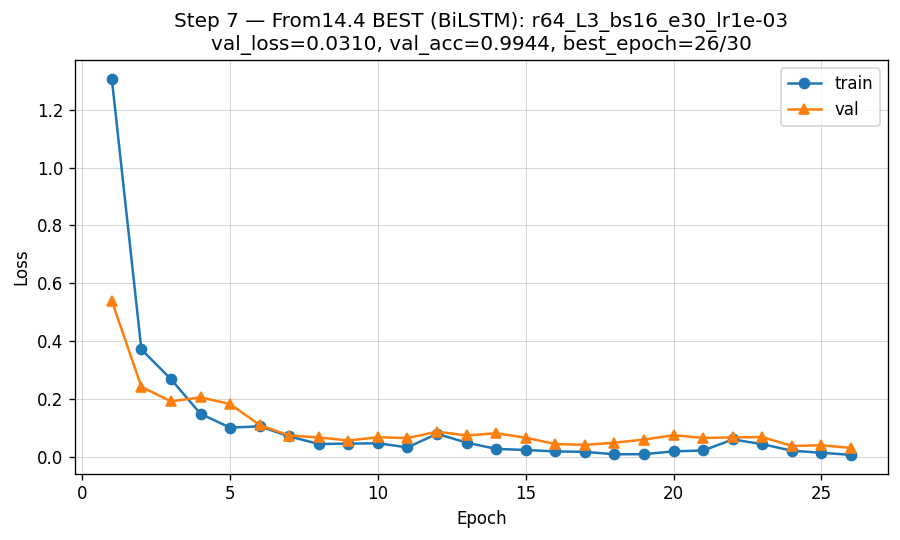

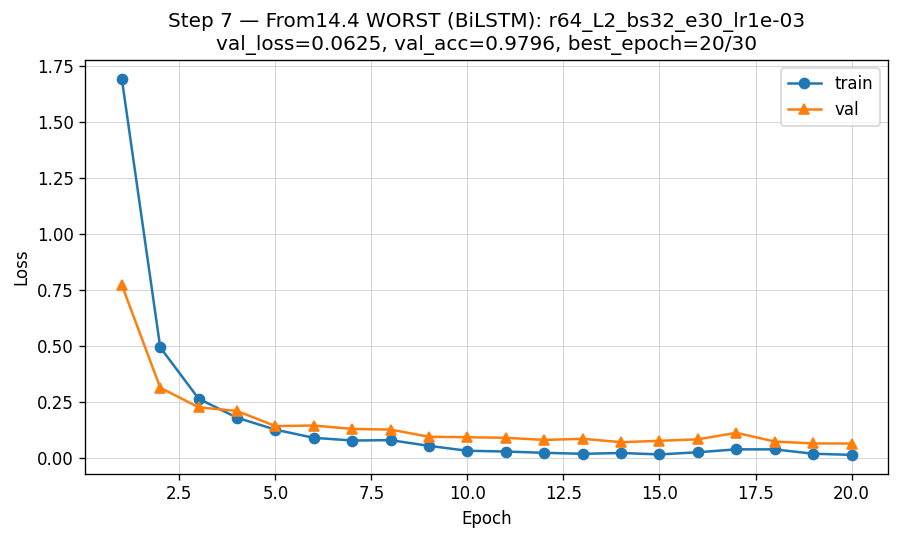


[Step 7] From 14.4 — BEST (BiLSTM):
{'base_id': 'r64_L3_bs16_e30_lr1e-03', 'rnn_size': 64, 'num_layers': 3, 'batch_size': 16, 'epochs_cap': 30, 'lr': 0.001, 'dropout': 0.0, 'weight_decay': 0.0, 'best_val_loss': 0.030997688563635436, 'best_val_acc': 0.9944444444444445, 'best_epoch': 26, 'checkpoint': 'Step07_bilstm_from14_4/r64_L3_bs16_e30_lr1e-03/best_BiLSTM_r64_L3_bs16_e30_lr1e-03.pt'}

[Step 7] From 14.4 — WORST (BiLSTM):
{'base_id': 'r64_L2_bs32_e30_lr1e-03', 'rnn_size': 64, 'num_layers': 2, 'batch_size': 32, 'epochs_cap': 30, 'lr': 0.001, 'dropout': 0.0, 'weight_decay': 0.0, 'best_val_loss': 0.06254040289808202, 'best_val_acc': 0.9796296296296296, 'best_epoch': 20, 'checkpoint': 'Step07_bilstm_from14_4/r64_L2_bs32_e30_lr1e-03/best_BiLSTM_r64_L2_bs32_e30_lr1e-03.pt'}


[BiLSTM from14.6] FIXED_30E_r64_L1_bs16_lr1e-03_do0.00_wd0e00:   0%|          | 0/30 [00:00<?, ?it/s]

[BiLSTM from14.6] FIXED_30E_r64_L3_bs32_lr1e-03_do0.00_wd0e00:   0%|          | 0/30 [00:00<?, ?it/s]

[BiLSTM from14.6] FIXED_30E_r64_L3_bs16_lr1e-03_do0.00_wd0e00:   0%|          | 0/30 [00:00<?, ?it/s]

[BiLSTM from14.6] EARLY_r64_L1_bs16_lr1e-03_do0.00_wd0e00:   0%|          | 0/30 [00:00<?, ?it/s]

[BiLSTM from14.6] EARLY stop at epoch 22/30


[BiLSTM from14.6] FIXED_30E_r64_L2_bs16_lr1e-03_do0.20_wd1e-03:   0%|          | 0/30 [00:00<?, ?it/s]

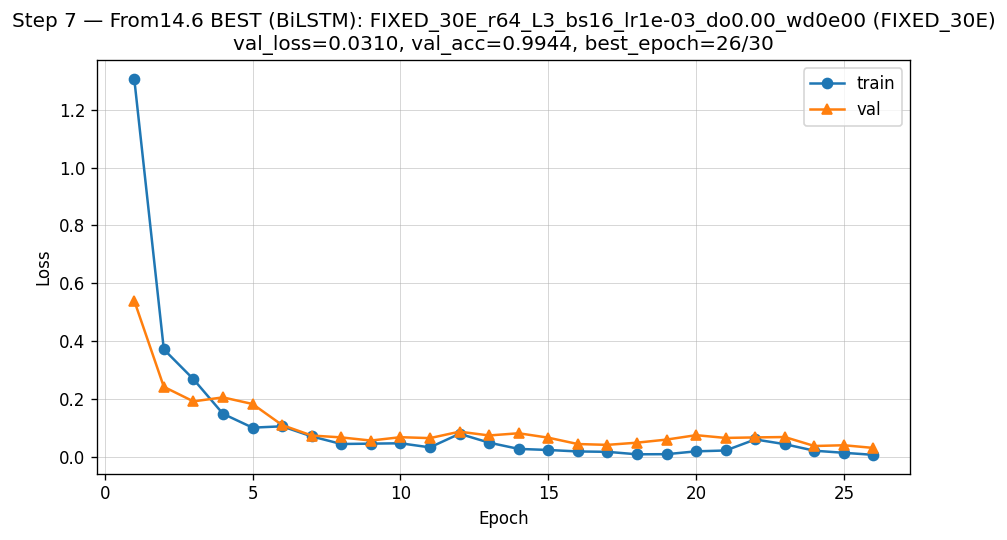

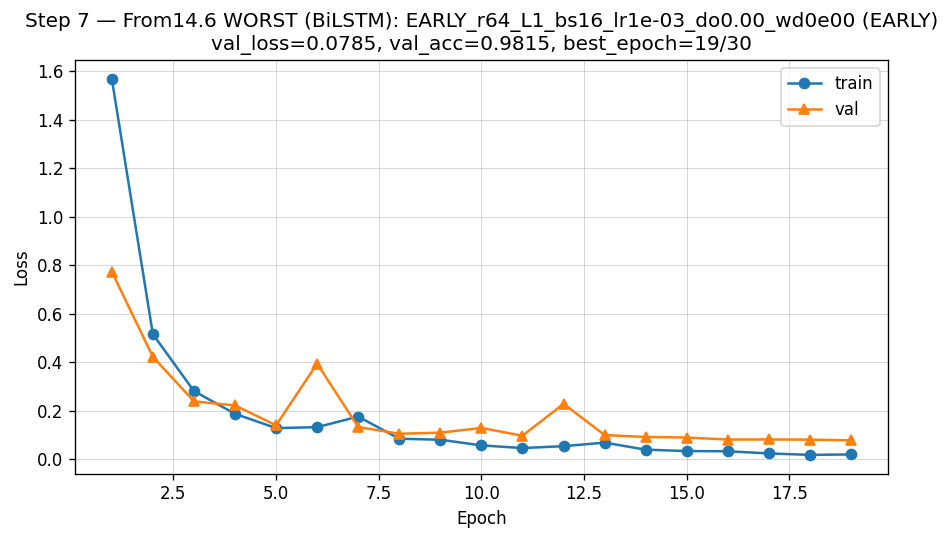


[Step 7] From 14.6 — BEST (BiLSTM):
{'base_id': 'FIXED_30E_r64_L3_bs16_lr1e-03_do0.00_wd0e00', 'regime': 'FIXED_30E', 'rnn_size': 64, 'num_layers': 3, 'batch_size': 16, 'lr': 0.001, 'dropout': 0.0, 'weight_decay': 0.0, 'best_val_loss': 0.030997688563635436, 'best_val_acc': 0.9944444444444445, 'best_epoch': 26, 'epochs_cap': 30, 'checkpoint': 'Step07_bilstm_from14_6/FIXED_30E_r64_L3_bs16_lr1e-03_do0.00_wd0e00/best_BiLSTM_FIXED_30E_r64_L3_bs16_lr1e-03_do0.00_wd0e00.pt'}

[Step 7] From 14.6 — WORST (BiLSTM):
{'base_id': 'EARLY_r64_L1_bs16_lr1e-03_do0.00_wd0e00', 'regime': 'EARLY', 'rnn_size': 64, 'num_layers': 1, 'batch_size': 16, 'lr': 0.001, 'dropout': 0.0, 'weight_decay': 0.0, 'best_val_loss': 0.07849549501616922, 'best_val_acc': 0.9814814814814815, 'best_epoch': 19, 'epochs_cap': 30, 'checkpoint': 'Step07_bilstm_from14_6/EARLY_r64_L1_bs16_lr1e-03_do0.00_wd0e00/best_BiLSTM_EARLY_r64_L1_bs16_lr1e-03_do0.00_wd0e00.pt'}


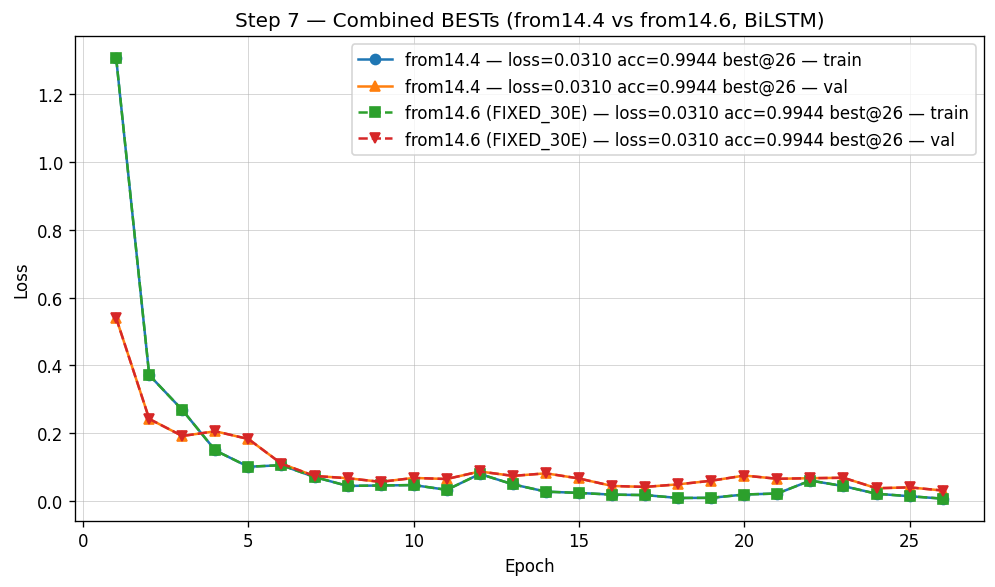

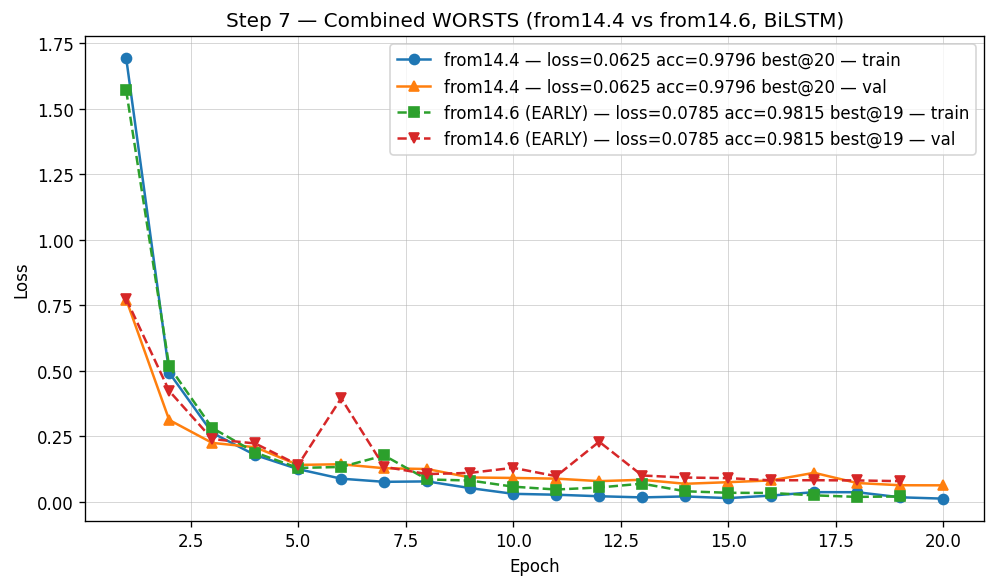

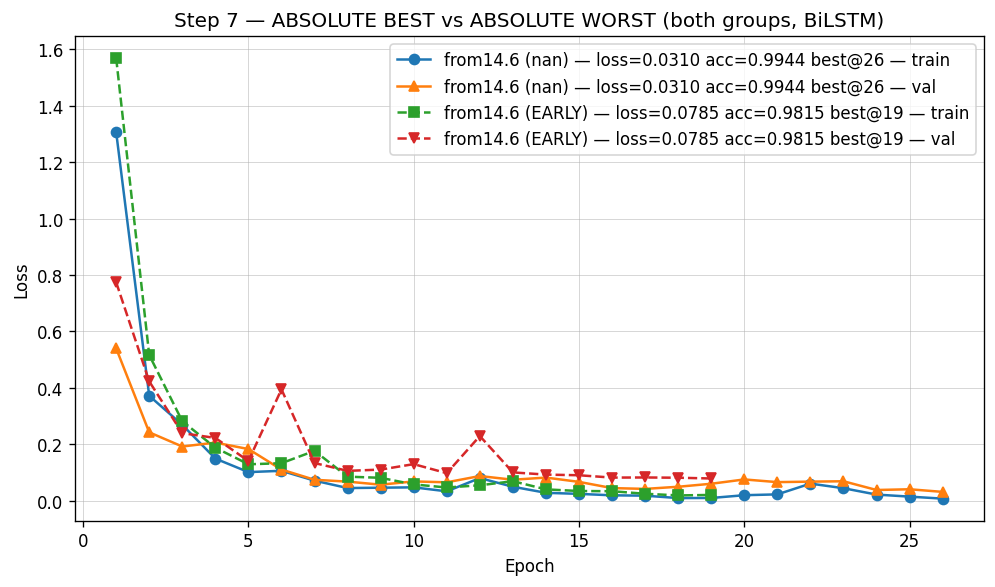


[Combined] ABSOLUTE BEST (BiLSTM):
{'base_id': 'r64_L3_bs16_e30_lr1e-03', 'rnn_size': 64, 'num_layers': 3, 'batch_size': 16, 'epochs_cap': 30, 'lr': 0.001, 'dropout': 0.0, 'weight_decay': 0.0, 'best_val_loss': 0.030997688563635436, 'best_val_acc': 0.9944444444444445, 'best_epoch': 26, 'checkpoint': 'Step07_bilstm_from14_4/r64_L3_bs16_e30_lr1e-03/best_BiLSTM_r64_L3_bs16_e30_lr1e-03.pt', 'regime': nan}

[Combined] ABSOLUTE WORST (BiLSTM):
{'base_id': 'EARLY_r64_L1_bs16_lr1e-03_do0.00_wd0e00', 'rnn_size': 64, 'num_layers': 1, 'batch_size': 16, 'epochs_cap': 30, 'lr': 0.001, 'dropout': 0.0, 'weight_decay': 0.0, 'best_val_loss': 0.07849549501616922, 'best_val_acc': 0.9814814814814815, 'best_epoch': 19, 'checkpoint': 'Step07_bilstm_from14_6/EARLY_r64_L1_bs16_lr1e-03_do0.00_wd0e00/best_BiLSTM_EARLY_r64_L1_bs16_lr1e-03_do0.00_wd0e00.pt', 'regime': 'EARLY'}


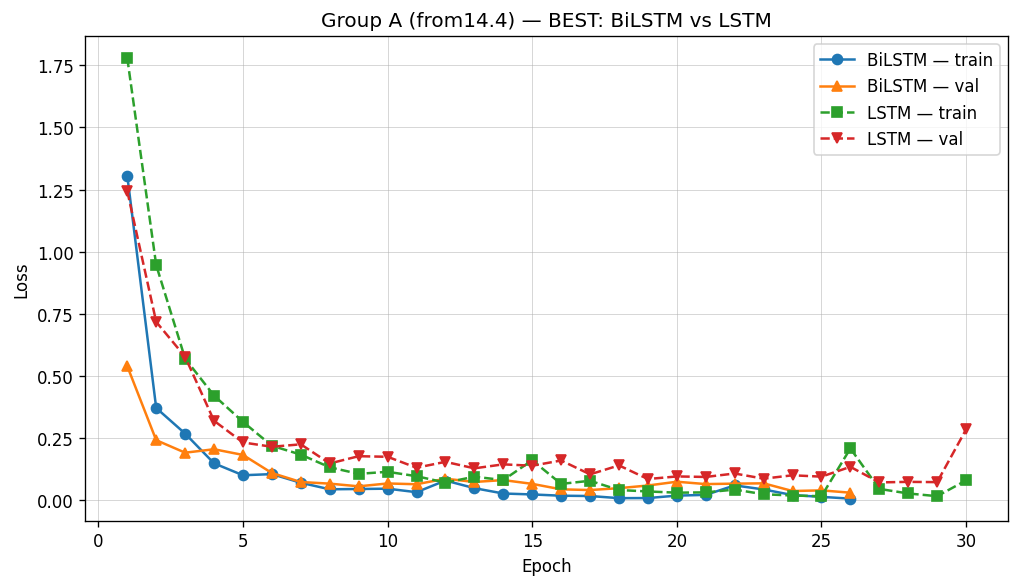

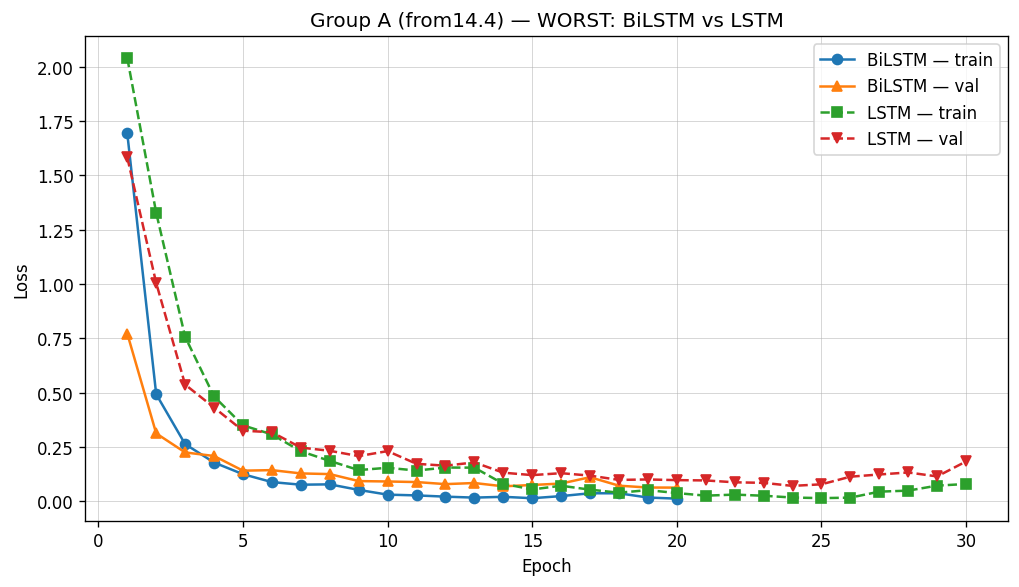

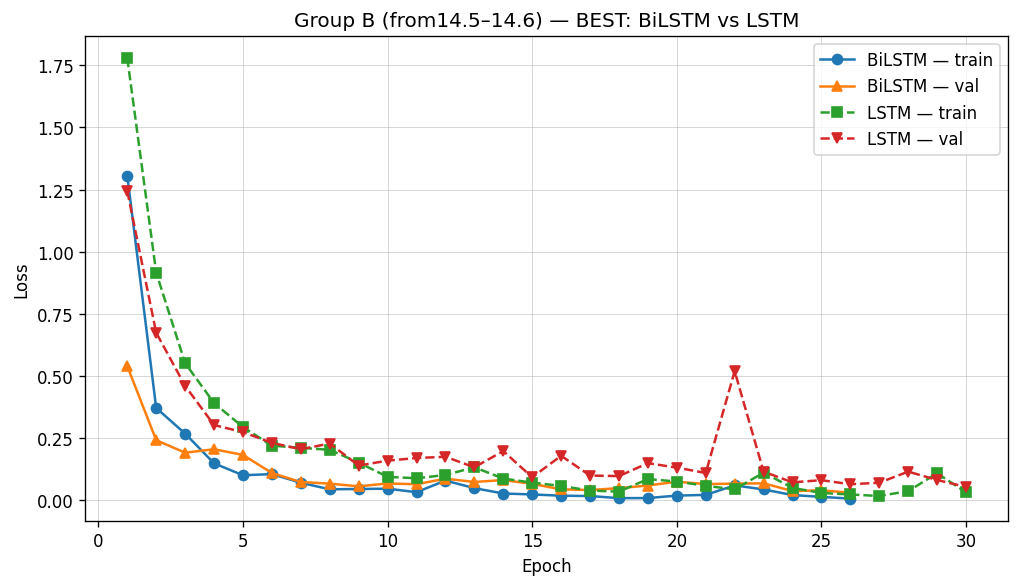

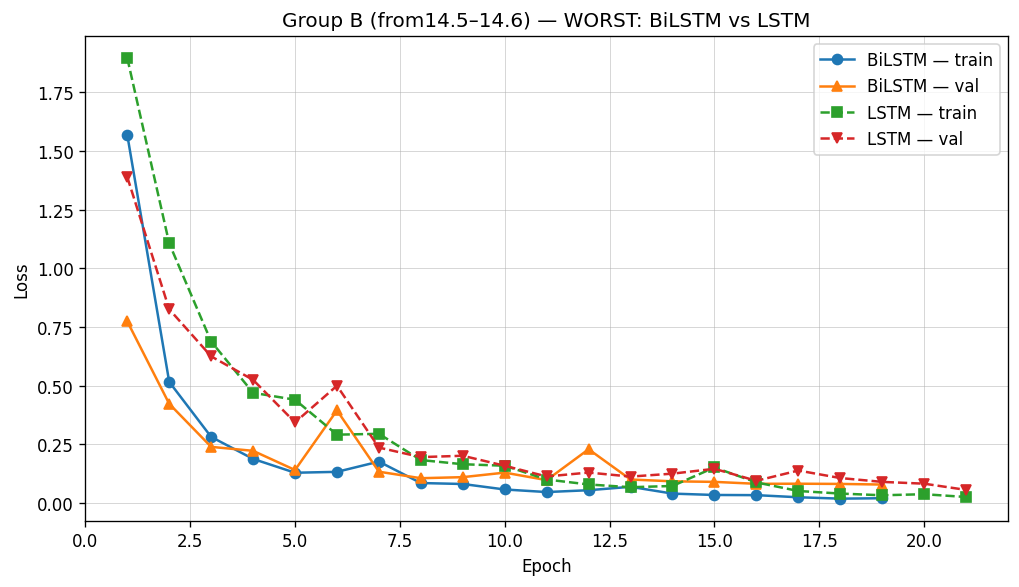


[BiLSTM vs LSTM — Validation comparison]
            group which  val_acc_LSTM  val_loss_LSTM  val_acc_BiLSTM  val_loss_BiLSTM  delta_acc (Bi−LSTM)  delta_loss (Bi−LSTM)
     A (from14.4)  BEST      0.979630       0.072350        0.994444         0.030998             0.014815             -0.041352
     A (from14.4) WORST      0.983333       0.070433        0.979630         0.062540            -0.003704             -0.007893
B (from14.5–14.6)  BEST      0.981481       0.054224        0.994444         0.030998             0.012963             -0.023227
B (from14.5–14.6) WORST      0.985185       0.055761        0.981481         0.078495            -0.003704              0.022734

[Saved] Comparison CSV → Step07_compare_bilstm_vs_lstm/validation_accuracy_comparison.csv

[Saved] Step07_bilstm_from14_4/Step 7 - From14.4 BEST (Train+Val).png
[Saved] Step07_bilstm_from14_4/Step 7 - From14.4 WORST (Train+Val).png
[Saved] Step07_bilstm_from14_6/Step 7 - From14.6 BEST (Train+Val).png
[Saved] St

In [6]:
# ==============================================================
# STEP 14.7 — Bidirectional LSTMs (BiLSTM) on Top-5 Configs
#   • Group A (from 14.4): pick TOP-5 by val loss, retrain as BiLSTM
#       - Keep: rnn_size, num_layers, lr, batch_size, epochs (no dropout/L2, no early stop)
#         NOTE: 14.4 already used ≤30 epochs in your setup; we keep the original per-row epoch count
#               so IDs match the 14.4 leaderboard (consistency for overlays/comparisons).
#   • Group B (from 14.5–14.6 combined): pick TOP-5, retrain as BiLSTM
#       - Keep: rnn_size, num_layers, lr, batch_size, dropout, weight_decay, regime
#       - If regime == 'EARLY'      : early stopping (patience=3, min_delta=1e-4), up to 30 epochs
#       - If regime == 'FIXED_30E'  : exactly 30 epochs (no early stopping)
#
#   • Compare BiLSTM vs NON-BiLSTM with overlay diagrams and printed validation accuracies:
#         - Group A: overlay BEST and WORST BiLSTM vs their NON-BiLSTM counterparts from 14.4
#         - Group B: overlay BEST and WORST BiLSTM vs their NON-BiLSTM counterparts from 14.5–14.6
#   • Print concise tables with val_acc (and val_loss) deltas (BiLSTM − NON-BiLSTM).
#
#   Plots:
#     1) Group A best & worst (BiLSTM curves)
#     2) Group B best & worst (BiLSTM curves)
#     3) Combined: Best-vs-Best (A vs B), Worst-vs-Worst (A vs B),
#                  and Absolute BEST vs Absolute WORST across both groups
#     4) BiLSTM vs NON-BiLSTM overlays for BEST and WORST in each group
# ==============================================================

import os, json, math, glob, numpy as np, random, torch
import torch.nn as nn
from torch.utils.data import DataLoader
from pathlib import Path
from tqdm.auto import tqdm
import pandas as pd
import matplotlib.pyplot as plt

# --------------------------- Sanity checks ---------------------------
assert 'trainset' in globals() and 'valset' in globals(), \
    "Run the Step-14 Preparatory Cell first (must define trainset/valset)."

# Infer input feature dimension from your SeqDataset tensors
INPUT_DIM   = int(trainset.x.shape[-1])
NUM_CLASSES = 10

# Artifacts from previous steps
CKPT_DIR_14_4    = Path("Step14_checkpoints_train_only")
LEADERBOARD_14_4 = CKPT_DIR_14_4 / "leaderboard_with_val.json"
assert LEADERBOARD_14_4.is_file(), f"Missing Step 14.4 leaderboard: {LEADERBOARD_14_4}"

# === CHANGED: read 14.5–14.6 results from the 30-epoch directory and names ===
ROOT_14_6  = Path("Step14_reg_top30_compare_30ep")
LB_FIXED   = ROOT_14_6 / "leaderboard_FIXED_30E.json"
LB_EARLY   = ROOT_14_6 / "leaderboard_EARLY.json"
assert LB_FIXED.is_file() or LB_EARLY.is_file(), "Missing Step 14.5–14.6 leaderboards (30-epoch)."

# --------------------------- Selection knobs & outputs ---------------------------
TOP_K = 5  # pick the 5 best rows per source

OUT_14_4 = Path("Step07_bilstm_from14_4"); OUT_14_4.mkdir(parents=True, exist_ok=True)
OUT_14_6 = Path("Step07_bilstm_from14_6"); OUT_14_6.mkdir(parents=True, exist_ok=True)
COMBO_OUT = Path("Step07_bilstm_combined"); COMBO_OUT.mkdir(parents=True, exist_ok=True)
CMP_OUT   = Path("Step07_compare_bilstm_vs_lstm"); CMP_OUT.mkdir(parents=True, exist_ok=True)

LB_14_4_JSON = OUT_14_4 / "leaderboard_bilstm_from14_4.json"
LB_14_6_JSON = OUT_14_6 / "leaderboard_bilstm_from14_6.json"

PLOT_14_4_BEST  = OUT_14_4 / "Step 7 - From14.4 BEST (Train+Val).png"
PLOT_14_4_WORST = OUT_14_4 / "Step 7 - From14.4 WORST (Train+Val).png"
PLOT_14_6_BEST  = OUT_14_6 / "Step 7 - From14.6 BEST (Train+Val).png"
PLOT_14_6_WORST = OUT_14_6 / "Step 7 - From14.6 WORST (Train+Val).png"

PLOT_BESTS   = COMBO_OUT / "Step 7 - Combined BESTs (Train+Val).png"
PLOT_WORSTS  = COMBO_OUT / "Step 7 - Combined WORSTS (Train+Val).png"
PLOT_ABS_BvW = COMBO_OUT / "Step 7 - Combined ABS BEST vs ABS WORST (Train+Val).png"

# NEW: overlay comparisons (BiLSTM vs NON-BiLSTM) per group
CMP_PLOT_A_BEST  = CMP_OUT / "GroupA - BiLSTM vs LSTM (BEST).png"
CMP_PLOT_A_WORST = CMP_OUT / "GroupA - BiLSTM vs LSTM (WORST).png"
CMP_PLOT_B_BEST  = CMP_OUT / "GroupB - BiLSTM vs LSTM (BEST).png"
CMP_PLOT_B_WORST = CMP_OUT / "GroupB - BiLSTM vs LSTM (WORST).png"
CMP_SUMMARY_CSV  = CMP_OUT / "validation_accuracy_comparison.csv"

# --------------------------- Utilities ---------------------------
def make_loaders(bs: int):
    """Build TRAIN & VAL loaders for a given batch size."""
    train_loader = DataLoader(trainset, batch_size=bs, shuffle=True,  drop_last=False)
    val_loader   = DataLoader(valset,   batch_size=bs, shuffle=False, drop_last=False)
    return train_loader, val_loader

def lr_token(lr: float) -> str:
    """Filename-safe token for learning rate."""
    return f"{lr:.0e}".replace("+","")

def base_id_14_4(rnn_size: int, num_layers: int, batch_size: int, epochs: int, lr: float) -> str:
    """Stable id for 14.4-style rows (no dropout/L2)."""
    return f"r{rnn_size}_L{num_layers}_bs{batch_size}_e{epochs}_lr{lr_token(lr)}"

def base_id_14_6(rnn_size: int, num_layers: int, batch_size: int, lr: float,
                 dropout: float, weight_decay: float, regime: str) -> str:
    """Stable id for 14.6-style rows (with dropout/L2 and regime)."""
    return (f"{regime}_r{rnn_size}_L{num_layers}_bs{batch_size}_lr{lr_token(lr)}"
            f"_do{dropout:.2f}_wd{weight_decay:.0e}").replace("+","")

# Reproducibility (offset seed so BiLSTM runs are distinct but deterministic)
GLOBAL_SEED = 0
np.random.seed(GLOBAL_SEED); random.seed(GLOBAL_SEED); torch.manual_seed(GLOBAL_SEED)

def seed_for_bilstm_trial(*, rnn_size: int, num_layers: int, batch_size: int, lr: float,
                          epochs_cap: int, dropout: float = 0.0, weight_decay: float = 0.0) -> int:
    """Deterministic per-trial seed. +1009 offset marks BiLSTM experiments."""
    return (GLOBAL_SEED
            + 1009
            + rnn_size * 3
            + num_layers * 5
            + batch_size * 7
            + int(lr * 1e6) * 11
            + epochs_cap * 13
            + int(dropout * 1000) * 17
            + int(weight_decay * 1e6) * 19)

def plot_curves(history, title: str, out_path: Path):
    """Plot TRAIN & VAL loss curves in the same figure, save, and show."""
    plt.figure(figsize=(7.6, 4.6), dpi=120)
    plt.plot(range(1, len(history.get("train", []))+1), history.get("train", []), marker="o", label="train")
    plt.plot(range(1, len(history.get("val",   []))+1), history.get("val",   []), marker="^", label="val")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title(title)
    plt.grid(True, linewidth=0.5, alpha=0.6); plt.legend(); plt.tight_layout()
    out_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(out_path); plt.show()

def plot_overlay_two_models(hist_A, label_A, hist_B, label_B, title, outfile):
    """Overlay TRAIN/VAL curves for two models (A solid, B dashed)."""
    epochs_A = range(1, len(hist_A.get("train", [])) + 1)
    epochs_B = range(1, len(hist_B.get("train", [])) + 1)

    plt.figure(figsize=(8.4, 5.0), dpi=120)
    if len(hist_A.get("train", [])) > 0:
        plt.plot(epochs_A, hist_A["train"], marker="o", linestyle="-",  label=f"{label_A} — train")
    if len(hist_A.get("val", [])) > 0:
        plt.plot(epochs_A, hist_A["val"],   marker="^", linestyle="-",  label=f"{label_A} — val")
    if len(hist_B.get("train", [])) > 0:
        plt.plot(epochs_B, hist_B["train"], marker="s", linestyle="--", label=f"{label_B} — train")
    if len(hist_B.get("val", [])) > 0:
        plt.plot(epochs_B, hist_B["val"],   marker="v", linestyle="--", label=f"{label_B} — val")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title(title)
    plt.grid(True, linewidth=0.5, alpha=0.6); plt.legend(); plt.tight_layout()
    outfile.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(outfile); plt.show()

# --------------------------- Models & loops ---------------------------
class BiLSTMClassifier(nn.Module):
    """
    Bidirectional LSTM classifier:
      • LSTM stack (bidirectional=True)
      • Intra-stack dropout active only if num_layers > 1 (PyTorch semantics)
      • Post-LSTM dropout before classifier (always applied)
      • Time pooling: concat(last forward, first backward)
    """
    def __init__(self, input_dim: int, hidden: int, num_layers: int,
                 num_classes: int, dropout_p: float):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=(dropout_p if num_layers > 1 else 0.0),
        )
        out_dim = hidden * 2
        self.post_dropout = nn.Dropout(dropout_p)
        self.fc = nn.Linear(out_dim, num_classes)

    @staticmethod
    def _last_valid(outputs: torch.Tensor, lengths: torch.Tensor) -> torch.Tensor:
        idx = (lengths - 1).view(-1, 1, 1).expand(outputs.size(0), 1, outputs.size(2))
        return outputs.gather(1, idx).squeeze(1)

    @staticmethod
    def _first(outputs: torch.Tensor) -> torch.Tensor:
        return outputs[:, 0, :]

    def forward(self, x, lengths):
        y, _ = self.lstm(x)          # (N, L, 2H)
        H = y.size(-1) // 2
        fw = y[:, :, :H]
        bw = y[:, :, H:]
        last_fw  = self._last_valid(fw, lengths)
        first_bw = self._first(bw)
        pooled = torch.cat([last_fw, first_bw], dim=-1)
        return self.fc(self.post_dropout(pooled))

def train_epoch(model: nn.Module, loader, opt, crit) -> float:
    """One training epoch over TRAIN: returns average loss."""
    model.train()
    tot, n = 0.0, 0
    for xb, yb, lb in loader:
        opt.zero_grad(set_to_none=True)
        logits = model(xb, lb)
        loss   = crit(logits, yb)
        loss.backward()
        opt.step()
        tot += loss.item() * yb.size(0)
        n   += yb.size(0)
    return float(tot / max(1, n))

@torch.no_grad()
def eval_epoch(model: nn.Module, loader, crit):
    """One validation epoch: returns (avg loss, accuracy)."""
    model.eval()
    tot, n, correct = 0.0, 0, 0
    for xb, yb, lb in loader:
        logits = model(xb, lb)
        loss   = crit(logits, yb)
        tot += loss.item() * yb.size(0)
        n   += yb.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == yb).sum().item()
    return float(tot / max(1, n)), float(correct / max(1, n))

class EarlyStopping:
    """Stop if val_loss fails to improve by MIN_DELTA for PATIENCE epochs."""
    def __init__(self, patience: int, min_delta: float = 0.0):
        self.patience   = patience
        self.min_delta  = min_delta
        self.best       = math.inf
        self.bad_epochs = 0
    def step(self, current: float) -> bool:
        improved = (self.best - current) > self.min_delta
        if improved:
            self.best = current
            self.bad_epochs = 0
            return False
        self.bad_epochs += 1
        return self.bad_epochs >= self.patience

# --------------------------- Load ALL rows from Step 14.4 (for fallbacks) ---------------------------
rows_14_4_all = json.loads(LEADERBOARD_14_4.read_text())
df_14_4 = (pd.DataFrame(rows_14_4_all)
           .sort_values(["val_loss", "final_train_loss"], ascending=[True, True])
           .reset_index(drop=True))

# Build quick-access maps for per-epoch VAL fallbacks (when old 14.1–14.3 checkpoints lack val history)
VALCURVE_BY_CKPT  = {}
VALACC_BY_CKPT    = {}
for r in rows_14_4_all:
    ck = str(r.get("checkpoint", ""))
    if ck:
        if isinstance(r.get("val_curve", None), list):
            VALCURVE_BY_CKPT[ck] = r["val_curve"]
        if isinstance(r.get("val_acc_curve", None), list):
            VALACC_BY_CKPT[ck] = r["val_acc_curve"]

# Keep the TOP-K slice for Group A training
top_14_4 = df_14_4.head(min(TOP_K, len(df_14_4))).copy()
print(f"[Step 7] Selected {len(top_14_4)} best configs from Step 14.4.")

# --------------------------- Load TOP-5 combined from Steps 14.5–14.6 (30-epoch) ---------------------------
def _safe_load(p: Path):
    return json.loads(p.read_text()) if p.is_file() else []

rows_14_6 = _safe_load(LB_FIXED) + _safe_load(LB_EARLY)
assert len(rows_14_6) > 0, "No rows found from Steps 14.5–14.6 combined (30-epoch)."
df_14_6 = (pd.DataFrame(rows_14_6)
           .sort_values(["best_val_loss", "best_val_acc"], ascending=[True, False])
           .reset_index(drop=True))
top_14_6 = df_14_6.head(min(TOP_K, len(df_14_6))).copy()
print(f"[Step 7] Selected {len(top_14_6)} best configs from Steps 14.5–14.6 combined.")

# ==============================================================
# Part A — Retrain top-14.4 configs as BiLSTM (no dropout/L2, no early stop)
#   (Keep original per-row epoch count to maintain ID compatibility with 14.4)
# ==============================================================

all_rows_14_4 = []
for i, row in top_14_4.iterrows():
    # Base hyperparameters (keep as-is)
    rnn_size   = int(row["rnn_size"])
    num_layers = int(row["num_layers"])
    batch_size = int(row["batch_size"])
    epochs_cap = int(row["epochs"])          # keep original (all ≤ 30)
    lr         = float(row["lr"])
    base_id    = base_id_14_4(rnn_size, num_layers, batch_size, epochs_cap, lr)

    # Seed for reproducibility
    seed = seed_for_bilstm_trial(rnn_size=rnn_size, num_layers=num_layers,
                                 batch_size=batch_size, lr=lr, epochs_cap=epochs_cap)
    np.random.seed(seed); random.seed(seed); torch.manual_seed(seed)

    # Data, model, optimizer, criterion
    train_loader, val_loader = make_loaders(batch_size)
    model = BiLSTMClassifier(INPUT_DIM, rnn_size, num_layers, NUM_CLASSES, dropout_p=0.0)
    optim = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.0)
    crit  = nn.CrossEntropyLoss()

    # Book-keeping
    history  = {"train": [], "val": [], "val_acc": []}
    best_obj = None
    ckpt_dir = OUT_14_4 / base_id
    ckpt_dir.mkdir(parents=True, exist_ok=True)
    ckpt_path = ckpt_dir / f"best_BiLSTM_{base_id}.pt"

    # Train for the original epochs count (≤30; no early stopping)
    pbar = tqdm(range(1, epochs_cap + 1), desc=f"[BiLSTM from14.4] {base_id}")
    for ep in pbar:
        tr = train_epoch(model, train_loader, optim, crit)
        vl, va = eval_epoch(model, val_loader, crit)
        history["train"].append(tr); history["val"].append(vl); history["val_acc"].append(va)
        pbar.set_postfix_str(f"train={tr:.4f} val={vl:.4f} acc={va:.4f}")

        # Keep best by validation loss
        if (best_obj is None) or (vl < best_obj["best_val_loss"] - 0.0):
            best_obj = {
                "model_state": model.state_dict(),
                "meta": {"input_dim": INPUT_DIM, "num_classes": NUM_CLASSES,
                         "rnn_size": rnn_size, "num_layers": num_layers,
                         "batch_size": batch_size, "epochs_cap": epochs_cap,
                         "lr": lr, "dropout": 0.0, "weight_decay": 0.0,
                         "bidirectional": True, "source": "from14.4"},
                "history": {k: v[:] for k, v in history.items()},
                "best_val_loss": vl, "best_val_acc": va, "best_epoch": ep,
                "seed": seed, "base_id": base_id,
            }

    # Save best checkpoint and add to leaderboard
    assert best_obj is not None
    torch.save(best_obj, ckpt_path)
    all_rows_14_4.append({
        "base_id": base_id, "rnn_size": rnn_size, "num_layers": num_layers,
        "batch_size": batch_size, "epochs_cap": epochs_cap, "lr": lr,
        "dropout": 0.0, "weight_decay": 0.0,
        "best_val_loss": float(best_obj["best_val_loss"]),
        "best_val_acc": float(best_obj["best_val_acc"]),
        "best_epoch": int(best_obj["best_epoch"]),
        "checkpoint": str(ckpt_path),
    })

# Build leaderboard + plots for Part A
df_bi_14_4 = pd.DataFrame(all_rows_14_4).sort_values(
    ["best_val_loss", "best_val_acc"], ascending=[True, False]
).reset_index(drop=True)
with open(LB_14_4_JSON, "w") as f: json.dump(df_bi_14_4.to_dict(orient="records"), f, indent=2)

# Overall best & worst plots (Group A, BiLSTM only)
best_row_A = df_bi_14_4.iloc[0]; worst_row_A = df_bi_14_4.iloc[-1]
best_blob_A = torch.load(Path(best_row_A["checkpoint"]), map_location="cpu")
worst_blob_A = torch.load(Path(worst_row_A["checkpoint"]), map_location="cpu")
plot_curves(best_blob_A["history"],
            f"Step 7 — From14.4 BEST (BiLSTM): {best_row_A['base_id']}\n"
            f"val_loss={best_row_A['best_val_loss']:.4f}, val_acc={best_row_A['best_val_acc']:.4f}, "
            f"best_epoch={best_row_A['best_epoch']}/{best_row_A['epochs_cap']}",
            PLOT_14_4_BEST)
plot_curves(worst_blob_A["history"],
            f"Step 7 — From14.4 WORST (BiLSTM): {worst_row_A['base_id']}\n"
            f"val_loss={worst_row_A['best_val_loss']:.4f}, val_acc={worst_row_A['best_val_acc']:.4f}, "
            f"best_epoch={worst_row_A['best_epoch']}/{worst_row_A['epochs_cap']}",
            PLOT_14_4_WORST)

print("\n[Step 7] From 14.4 — BEST (BiLSTM):");  print(best_row_A.to_dict())
print("\n[Step 7] From 14.4 — WORST (BiLSTM):"); print(worst_row_A.to_dict())

# ==============================================================
# Part B — Retrain top-14.5–14.6 (combined) as BiLSTM (regime-aware)
#   CHANGED: cap all runs to 30 epochs; FIXED label is 'FIXED_30E'
# ==============================================================

PATIENCE  = 3
MIN_DELTA = 1e-4
EPOCHS_MAX = 30

all_rows_14_6 = []
for i, row in top_14_6.iterrows():
    rnn_size    = int(row["rnn_size"])
    num_layers  = int(row["num_layers"])
    batch_size  = int(row["batch_size"])
    lr          = float(row["lr"])
    dropout     = float(row.get("dropout", 0.0))
    weight_decay= float(row.get("weight_decay", 0.0))
    # Default regime to FIXED_30E if missing (30-epoch artifacts)
    regime      = str(row.get("regime", "FIXED_30E")).replace("FIXED_50E", "FIXED_30E")
    base_id     = base_id_14_6(rnn_size, num_layers, batch_size, lr, dropout, weight_decay, regime)

    # Seed (distinct but deterministic)
    seed = seed_for_bilstm_trial(rnn_size=rnn_size, num_layers=num_layers,
                                 batch_size=batch_size, lr=lr, epochs_cap=EPOCHS_MAX,
                                 dropout=dropout, weight_decay=weight_decay)
    np.random.seed(seed); random.seed(seed); torch.manual_seed(seed)

    # Data, model, optimizer, criterion
    train_loader, val_loader = make_loaders(batch_size)
    model = BiLSTMClassifier(INPUT_DIM, rnn_size, num_layers, NUM_CLASSES, dropout_p=dropout)
    optim = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    crit  = nn.CrossEntropyLoss()

    stopper  = EarlyStopping(PATIENCE, MIN_DELTA) if regime == "EARLY" else None
    history  = {"train": [], "val": [], "val_acc": []}
    best_obj = None

    ckpt_dir  = OUT_14_6 / base_id
    ckpt_dir.mkdir(parents=True, exist_ok=True)
    ckpt_path = ckpt_dir / f"best_BiLSTM_{base_id}.pt"

    # Train: regime-aware (both bounded by 30 epochs)
    pbar = tqdm(range(1, EPOCHS_MAX + 1), desc=f"[BiLSTM from14.6] {base_id}")
    for ep in pbar:
        tr = train_epoch(model, train_loader, optim, crit)
        vl, va = eval_epoch(model, val_loader, crit)
        history["train"].append(tr); history["val"].append(vl); history["val_acc"].append(va)
        pbar.set_postfix_str(f"train={tr:.4f} val={vl:.4f} acc={va:.4f}")

        # Keep best by validation loss
        if (best_obj is None) or (vl < best_obj["best_val_loss"] - 0.0):
            best_obj = {
                "model_state": model.state_dict(),
                "meta": {"input_dim": INPUT_DIM, "num_classes": NUM_CLASSES,
                         "rnn_size": rnn_size, "num_layers": num_layers,
                         "batch_size": batch_size, "epochs_cap": EPOCHS_MAX,
                         "lr": lr, "dropout": dropout, "weight_decay": weight_decay,
                         "bidirectional": True, "source": "from14.6", "regime": regime},
                "history": {k: v[:] for k, v in history.items()},
                "best_val_loss": vl, "best_val_acc": va, "best_epoch": ep,
                "seed": seed, "base_id": base_id,
            }

        # Early stopping if this row came from EARLY regime (≤30 epochs)
        if (regime == "EARLY") and stopper.step(vl):
            tqdm.write(f"[BiLSTM from14.6] EARLY stop at epoch {ep}/{EPOCHS_MAX}")
            break

    # Save best checkpoint and add to leaderboard
    assert best_obj is not None
    torch.save(best_obj, ckpt_path)
    all_rows_14_6.append({
        "base_id": base_id, "regime": regime,
        "rnn_size": rnn_size, "num_layers": num_layers, "batch_size": batch_size, "lr": lr,
        "dropout": dropout, "weight_decay": weight_decay,
        "best_val_loss": float(best_obj["best_val_loss"]),
        "best_val_acc": float(best_obj["best_val_acc"]),
        "best_epoch": int(best_obj["best_epoch"]),
        "epochs_cap": EPOCHS_MAX,
        "checkpoint": str(ckpt_path),
    })

# Build leaderboard + plots for Part B
df_bi_14_6 = pd.DataFrame(all_rows_14_6).sort_values(
    ["best_val_loss", "best_val_acc"], ascending=[True, False]
).reset_index(drop=True)
with open(LB_14_6_JSON, "w") as f: json.dump(df_bi_14_6.to_dict(orient="records"), f, indent=2)

# Overall best & worst plots (Group B, BiLSTM only)
best_row_B  = df_bi_14_6.iloc[0];  worst_row_B = df_bi_14_6.iloc[-1]
best_blob_B = torch.load(Path(best_row_B["checkpoint"]), map_location="cpu")
worst_blob_B= torch.load(Path(worst_row_B["checkpoint"]), map_location="cpu")
plot_curves(best_blob_B["history"],
            f"Step 7 — From14.6 BEST (BiLSTM): {best_row_B['base_id']} ({best_row_B['regime']})\n"
            f"val_loss={best_row_B['best_val_loss']:.4f}, val_acc={best_row_B['best_val_acc']:.4f}, "
            f"best_epoch={best_row_B['best_epoch']}/{best_row_B['epochs_cap']}",
            PLOT_14_6_BEST)
plot_curves(worst_blob_B["history"],
            f"Step 7 — From14.6 WORST (BiLSTM): {worst_row_B['base_id']} ({worst_row_B['regime']})\n"
            f"val_loss={worst_row_B['best_val_loss']:.4f}, val_acc={worst_row_B['best_val_acc']:.4f}, "
            f"best_epoch={worst_row_B['best_epoch']}/{worst_row_B['epochs_cap']}",
            PLOT_14_6_WORST)

print("\n[Step 7] From 14.6 — BEST (BiLSTM):");  print(best_row_B.to_dict())
print("\n[Step 7] From 14.6 — WORST (BiLSTM):"); print(worst_row_B.to_dict())

# ==============================================================
# Combined diagrams — (1) Best-vs-Best, (2) Worst-vs-Worst, (3) Abs BEST vs Abs WORST
# ==============================================================

def _label(row, tag: str):
    """Compact label with loss/acc and best epoch."""
    if tag == "from14.4":
        prefix = "from14.4"
    else:
        prefix = f"from14.6 ({row.get('regime','')})"
    return f"{prefix} — loss={row['best_val_loss']:.4f} acc={row['best_val_acc']:.4f} best@{int(row['best_epoch'])}"

# 1) Best-vs-Best (A vs B)
plot_overlay_two_models(
    hist_A=best_blob_A["history"],
    label_A=_label(best_row_A, "from14.4"),
    hist_B=best_blob_B["history"],
    label_B=_label(best_row_B, "from14.6"),
    title="Step 7 — Combined BESTs (from14.4 vs from14.6, BiLSTM)",
    outfile=PLOT_BESTS,
)

# 2) Worst-vs-Worst (A vs B)
plot_overlay_two_models(
    hist_A=worst_blob_A["history"],
    label_A=_label(worst_row_A, "from14.4"),
    hist_B=worst_blob_B["history"],
    label_B=_label(worst_row_B, "from14.6"),
    title="Step 7 — Combined WORSTS (from14.4 vs from14.6, BiLSTM)",
    outfile=PLOT_WORSTS,
)

# 3) Absolute BEST vs Absolute WORST across both groups
both_df = pd.concat([df_bi_14_4, df_bi_14_6], ignore_index=True)
abs_best = both_df.sort_values(["best_val_loss", "best_val_acc"], ascending=[True, False]).iloc[0]
abs_wrst = both_df.sort_values(["best_val_loss", "best_val_acc"], ascending=[False, True]).iloc[0]
abs_best_blob = torch.load(Path(abs_best["checkpoint"]), map_location="cpu")
abs_wrst_blob = torch.load(Path(abs_wrst["checkpoint"]), map_location="cpu")

plot_overlay_two_models(
    hist_A=abs_best_blob["history"],
    label_A=_label(abs_best, "from14.6" if "regime" in abs_best else "from14.4"),
    hist_B=abs_wrst_blob["history"],
    label_B=_label(abs_wrst, "from14.6" if "regime" in abs_wrst else "from14.4"),
    title="Step 7 — ABSOLUTE BEST vs ABSOLUTE WORST (both groups, BiLSTM)",
    outfile=PLOT_ABS_BvW,
)

print("\n[Combined] ABSOLUTE BEST (BiLSTM):");  print(abs_best.to_dict())
print("\n[Combined] ABSOLUTE WORST (BiLSTM):"); print(abs_wrst.to_dict())

# ==============================================================
# BiLSTM vs NON-BiLSTM comparisons (overlays + printed accuracies)
# ==============================================================

def _try_load_pt(path: Path):
    """Safely load a torch .pt file if it exists; else return None."""
    try:
        if path and Path(path).is_file():
            return torch.load(Path(path), map_location="cpu")
    except Exception as e:
        tqdm.write(f"[WARN] Failed to load checkpoint: {path} ({e})")
    return None

def _match_non_bilstm_from_14_4(bilstm_row: pd.Series, top14_4_df: pd.DataFrame):
    """
    Find the NON-BiLSTM counterpart (from step 14.4) for a given BiLSTM row.
    Returns (blob, row_dict_or_None) where row_dict is from the 14.4 leaderboard.
    """
    # base_id: r{rnn}_L{layers}_bs{bs}_e{epochs}_lr{lrtok}
    tokens = str(bilstm_row["base_id"]).split("_")
    rnn = int(tokens[0][1:])
    L   = int(tokens[1][1:])
    bs  = int(tokens[2][2:])
    e   = int(tokens[3][1:]) if tokens[3].startswith("e") else None

    cand = top14_4_df[
        (top14_4_df["rnn_size"]==rnn) &
        (top14_4_df["num_layers"]==L) &
        (top14_4_df["batch_size"]==bs)
    ]
    if e is not None and "epochs" in top14_4_df.columns:
        cand = cand[cand["epochs"]==e]
    if cand.empty:
        return None, None
    base_row = cand.iloc[0].to_dict()

    ck = base_row.get("checkpoint", None)
    blob = _try_load_pt(Path(ck)) if ck else None
    if blob is not None:
        return blob, base_row

    # Fallback: scan .pt files and match meta
    pt_files = glob.glob(str(CKPT_DIR_14_4 / "**/*.pt"), recursive=True)
    for p in pt_files:
        B = _try_load_pt(Path(p))
        if B is None:
            continue
        meta = B.get("meta", {})
        if (meta.get("bidirectional", False) is False and
            int(meta.get("rnn_size", -1)) == rnn and
            int(meta.get("num_layers", -1)) == L and
            int(meta.get("batch_size", -1)) == bs and
            float(meta.get("lr", -1.0)) == float(base_row["lr"])):
            return B, base_row

    return None, base_row  # row found but blob missing

def _non_bilstm_from_14_6_row(bilstm_row: pd.Series, top14_6_df: pd.DataFrame):
    """
    Find the NON-BiLSTM counterpart for a 14.6 BiLSTM row by base_id.
    The 14.6 leaderboards include 'checkpoint' paths → direct load.
    """
    base_id = str(bilstm_row["base_id"])
    regime = base_id.split("_")[0]
    matches = top14_6_df[
        (top14_6_df["regime"]==bilstm_row.get("regime", regime)) &
        (top14_6_df["rnn_size"]==bilstm_row["rnn_size"]) &
        (top14_6_df["num_layers"]==bilstm_row["num_layers"]) &
        (top14_6_df["batch_size"]==bilstm_row["batch_size"]) &
        (top14_6_df["lr"]==bilstm_row["lr"]) &
        (top14_6_df["dropout"]==bilstm_row.get("dropout", 0.0)) &
        (top14_6_df["weight_decay"]==bilstm_row.get("weight_decay", 0.0))
    ]
    if matches.empty:
        return None, None
    row = matches.iloc[0].to_dict()
    blob = _try_load_pt(Path(row.get("checkpoint", "")))
    return blob, row

def _overlay_bilstm_vs_lstm(bilstm_blob, lstm_blob, title, outfile, lstm_ckpt_path=None):
    """
    Overlay curves of BiLSTM (solid) vs NON-BiLSTM (dashed), with robust fallbacks
    for old 14.1–14.3 checkpoints that lack per-epoch VAL in their history.
    """
    if (bilstm_blob is None) or (lstm_blob is None):
        tqdm.write(f"[WARN] Skipping overlay (missing blob) for: {title}")
        return

    H_bi = bilstm_blob.get("history", {})
    H_ls = lstm_blob.get("history", {})

    bi_train = H_bi.get("train", [])
    bi_val   = H_bi.get("val",   [])

    # LSTM side: prefer checkpoint history; else fallback to Step 14.4 leaderboard curves
    ls_train = H_ls.get("train", lstm_blob.get("train_losses", lstm_blob.get("losses", [])))
    ls_val   = H_ls.get("val", None)
    if (ls_val is None or len(ls_val) == 0) and lstm_ckpt_path:
        vcurve = VALCURVE_BY_CKPT.get(str(lstm_ckpt_path), None)
        if isinstance(vcurve, list) and len(vcurve) > 0:
            ls_val = vcurve

    # Last fallback: draw a horizontal line at "best" val if we have no per-epoch curve
    ls_val_best = None
    if (ls_val is None or len(ls_val) == 0):
        if "best_val_loss" in lstm_blob:
            ls_val_best = float(lstm_blob["best_val_loss"])

    # --- Plot ---
    plt.figure(figsize=(8.6, 5.0), dpi=120)
    if len(bi_train) > 0: plt.plot(range(1, len(bi_train)+1), bi_train, marker="o", linestyle="-",  label="BiLSTM — train")
    if len(bi_val)   > 0: plt.plot(range(1, len(bi_val)+1),   bi_val,   marker="^", linestyle="-",  label="BiLSTM — val")

    if len(ls_train) > 0: plt.plot(range(1, len(ls_train)+1), ls_train, marker="s", linestyle="--", label="LSTM — train")
    if ls_val is not None and len(ls_val) > 0:
        plt.plot(range(1, len(ls_val)+1),   ls_val,   marker="v", linestyle="--", label="LSTM — val")
    elif ls_val_best is not None:
        xmax = max(len(bi_train), len(bi_val), len(ls_train), 1)
        plt.hlines(ls_val_best, xmin=1, xmax=max(1, xmax), linestyles="--", label=f"LSTM — val (best={ls_val_best:.4f})")

    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title(title)
    plt.grid(True, linewidth=0.5, alpha=0.6); plt.legend(); plt.tight_layout()
    outfile.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(outfile); plt.show()

# ---------- Accuracy/Loss extraction with fallbacks ----------
def _acc_loss_from(blob, row_from_14_4: dict | None = None):
    """
    Extract best (val_acc, val_loss) pair.
    Priority:
      1) blob['best_val_acc'], blob['best_val_loss'] if present
      2) min over blob['history']['val'] (and aligned val_acc at argmin) if present
      3) for 14.4 rows: min over row_from_14_4['val_curve'] and aligned row_from_14_4['val_acc_curve'] if present
      4) else (None, None)
    """
    if blob is not None:
        if ("best_val_acc" in blob) and ("best_val_loss" in blob):
            return float(blob["best_val_acc"]), float(blob["best_val_loss"])
        H = blob.get("history", {})
        if isinstance(H.get("val", None), list) and len(H["val"]) > 0:
            v = np.array(H["val"], dtype=float)
            idx = int(np.argmin(v))
            acc = None
            if isinstance(H.get("val_acc", None), list) and len(H["val_acc"]) == len(H["val"]):
                acc = float(H["val_acc"][idx])
            return acc, float(v[idx])

    if row_from_14_4 is not None:
        vcurve = row_from_14_4.get("val_curve", None)
        if isinstance(vcurve, list) and len(vcurve) > 0:
            v = np.array(vcurve, dtype=float)
            idx = int(np.argmin(v))
            acc_curve = row_from_14_4.get("val_acc_curve", None)
            acc = None
            if isinstance(acc_curve, list) and len(acc_curve) == len(vcurve):
                acc = float(acc_curve[idx])
            return acc, float(v[idx])

    return None, None

# ---------- Build NON-BiLSTM vs BiLSTM comparisons and print accuracy deltas ----------

cmp_rows = []  # accumulate summary rows for a CSV/print at the end

# Group A: match BEST and WORST BiLSTM back to 14.4 NON-BiLSTM counterparts
best_row_A = df_bi_14_4.iloc[0]; worst_row_A = df_bi_14_4.iloc[-1]
best_lstm_A, best_base_A   = _match_non_bilstm_from_14_4(best_row_A, df_14_4)
worst_lstm_A, worst_base_A = _match_non_bilstm_from_14_4(worst_row_A, df_14_4)

_overlay_bilstm_vs_lstm(best_blob_A, best_lstm_A,
                        "Group A (from14.4) — BEST: BiLSTM vs LSTM",
                        CMP_PLOT_A_BEST,
                        lstm_ckpt_path=(best_base_A.get("checkpoint") if best_base_A else None))
_overlay_bilstm_vs_lstm(worst_blob_A, worst_lstm_A,
                        "Group A (from14.4) — WORST: BiLSTM vs LSTM",
                        CMP_PLOT_A_WORST,
                        lstm_ckpt_path=(worst_base_A.get("checkpoint") if worst_base_A else None))

# Collect accuracy/loss summaries for prints — Group A
bi_acc, bi_loss = _acc_loss_from(best_blob_A)
ls_acc, ls_loss = _acc_loss_from(best_lstm_A, best_base_A)
cmp_rows.append({
    "group": "A (from14.4)", "which": "BEST",
    "val_acc_LSTM": ls_acc, "val_loss_LSTM": ls_loss,
    "val_acc_BiLSTM": bi_acc, "val_loss_BiLSTM": bi_loss,
    "delta_acc (Bi−LSTM)": (None if (bi_acc is None or ls_acc is None) else float(bi_acc - ls_acc)),
    "delta_loss (Bi−LSTM)": (None if (bi_loss is None or ls_loss is None) else float(bi_loss - ls_loss)),
})

bi_acc, bi_loss = _acc_loss_from(worst_blob_A)
ls_acc, ls_loss = _acc_loss_from(worst_lstm_A, worst_base_A)
cmp_rows.append({
    "group": "A (from14.4)", "which": "WORST",
    "val_acc_LSTM": ls_acc, "val_loss_LSTM": ls_loss,
    "val_acc_BiLSTM": bi_acc, "val_loss_BiLSTM": bi_loss,
    "delta_acc (Bi−LSTM)": (None if (bi_acc is None or ls_acc is None) else float(bi_acc - ls_acc)),
    "delta_loss (Bi−LSTM)": (None if (bi_loss is None or ls_loss is None) else float(bi_loss - ls_loss)),
})

# Group B: match BEST and WORST BiLSTM back to 14.6 NON-BiLSTM counterparts (30-epoch artifacts)
best_row_B  = df_bi_14_6.iloc[0];  worst_row_B = df_bi_14_6.iloc[-1]
best_lstm_B, best_base_B   = _non_bilstm_from_14_6_row(best_row_B, top_14_6)
worst_lstm_B, worst_base_B = _non_bilstm_from_14_6_row(worst_row_B, top_14_6)

_overlay_bilstm_vs_lstm(best_blob_B, best_lstm_B,
                        "Group B (from14.5–14.6) — BEST: BiLSTM vs LSTM",
                        CMP_PLOT_B_BEST)
_overlay_bilstm_vs_lstm(worst_blob_B, worst_lstm_B,
                        "Group B (from14.5–14.6) — WORST: BiLSTM vs LSTM",
                        CMP_PLOT_B_WORST)

# Collect accuracy/loss summaries for prints — Group B
bi_acc, bi_loss = _acc_loss_from(best_blob_B)
ls_acc, ls_loss = _acc_loss_from(best_lstm_B)
cmp_rows.append({
    "group": "B (from14.5–14.6)", "which": "BEST",
    "val_acc_LSTM": ls_acc, "val_loss_LSTM": ls_loss,
    "val_acc_BiLSTM": bi_acc, "val_loss_BiLSTM": bi_loss,
    "delta_acc (Bi−LSTM)": (None if (bi_acc is None or ls_acc is None) else float(bi_acc - ls_acc)),
    "delta_loss (Bi−LSTM)": (None if (bi_loss is None or ls_loss is None) else float(bi_loss - ls_loss)),
})

bi_acc, bi_loss = _acc_loss_from(worst_blob_B)
ls_acc, ls_loss = _acc_loss_from(worst_lstm_B)
cmp_rows.append({
    "group": "B (from14.5–14.6)", "which": "WORST",
    "val_acc_LSTM": ls_acc, "val_loss_LSTM": ls_loss,
    "val_acc_BiLSTM": bi_acc, "val_loss_BiLSTM": bi_loss,
    "delta_acc (Bi−LSTM)": (None if (bi_acc is None or ls_acc is None) else float(bi_acc - ls_acc)),
    "delta_loss (Bi−LSTM)": (None if (bi_loss is None or ls_loss is None) else float(bi_loss - ls_loss)),
})

# Save/print the comparison summary
cmp_df = pd.DataFrame(cmp_rows)
cmp_df.to_csv(CMP_SUMMARY_CSV, index=False)
print("\n[BiLSTM vs LSTM — Validation comparison]")
print(cmp_df.to_string(index=False))
print(f"\n[Saved] Comparison CSV → {CMP_SUMMARY_CSV}")

# Final reminders of saved figures
print(f"\n[Saved] {PLOT_14_4_BEST}")
print(f"[Saved] {PLOT_14_4_WORST}")
print(f"[Saved] {PLOT_14_6_BEST}")
print(f"[Saved] {PLOT_14_6_WORST}")
print(f"[Saved] {PLOT_BESTS}")
print(f"[Saved] {PLOT_WORSTS}")
print(f"[Saved] {PLOT_ABS_BvW}")
print(f"[Saved] {CMP_PLOT_A_BEST}")
print(f"[Saved] {CMP_PLOT_A_WORST}")
print(f"[Saved] {CMP_PLOT_B_BEST}")
print(f"[Saved] {CMP_PLOT_B_WORST}")


### **FINAL STEP — Absolute Best Model (up to Step 14.7) — Deliverables**

#### **Goal**
Select the **single best model by validation** among all candidates produced up to **Step 14.7**, then generate the **final quantitative results** and **figures**:
- Validation/Test **accuracy** and **loss**.
- **Confusion matrices** on **VAL** and **TEST**.
- **Training vs Validation** loss plot for the winner.

#### **Winner Selection**
1. Load all rows from the above leaderboards into a single candidate list (tagging the **source**).
2. For each row, extract:
   - **Loss** key:  
     - 14.4: `val_loss` (best across epochs, from snapshots/JSON)  
     - 14.5–14.6 & 14.7: `best_val_loss`
   - **Accuracy** key:  
     - 14.4: `val_acc` at the best-VAL epoch  
     - 14.5–14.6 & 14.7: `best_val_acc`
3. **Sort** by `(val_loss ASC, val_acc DESC)` and pick the **top row**.

> If the winner is from **14.4** and its checkpoint lacks a per-epoch VAL curve in `history`, the code **back-fills** `val_curve` and `val_acc_curve` from `leaderboard_with_val.json` so the training-vs-validation plot is still produced.

#### **Model Re-instantiation**
- A unified classifier (`GenericLSTMClassifier`) that supports **unidirectional** and **bidirectional** LSTMs is rebuilt from the winner’s **`meta`** (or **`cfg`** for 14.1–14.3-style checkpoints):
  - `input_dim`, `rnn_size`, `num_layers`, `num_classes`, `dropout`, `bidirectional`.
- The saved `model_state` is loaded for evaluation.

#### **Evaluation Protocol**
Using the **Step-14 Preparatory Cell** data loaders (`train_loader`, `val_loader`, `test_loader`):
- Compute **VAL loss/accuracy** and **TEST loss/accuracy** (cross-entropy, argmax).
- Produce:
  1. **Confusion Matrix — Validation (Best Overall)**  
  2. **Confusion Matrix — Test (Best Overall)**  
  3. **Training vs Validation Loss — Best Overall (selected by VAL)**

If the per-epoch **VAL** curve is unavailable, the plot includes a **horizontal line** at the stored **best VAL loss**.

#### **Saved Outputs**
All final artifacts are stored under `Final_Deliverables/`:
- `Training_vs_Validation_Loss (Best Overall).png`
- `Confusion_Matrix_Validation (Best Overall).png`
- `Confusion_Matrix_Test (Best Overall).png`

The console prints:
- Winner’s **source**, **checkpoint path**, **VAL loss/acc**.
- **Validation** and **Test** metrics for the best model.

#### **What this final step answers**
- Among all explored configurations (uni-LSTM, **regularized**, and **BiLSTM**), which **single model** yields the **lowest validation loss** (with accuracy tie-break)?
- How does it perform on **held-out TEST**?
- Do its **learning curves** indicate healthy training/validation dynamics?


[Best Model Selected]
  source     : step7_from14.4_Bi
  checkpoint : Step07_bilstm_from14_4/r64_L3_bs16_e30_lr1e-03/best_BiLSTM_r64_L3_bs16_e30_lr1e-03.pt
  val_loss   : 0.030998
  val_acc    : 0.994444
  meta       : {'input_dim': 6, 'num_classes': 10, 'rnn_size': 64, 'num_layers': 3, 'batch_size': 16, 'epochs_cap': 30, 'lr': 0.001, 'dropout': 0.0, 'weight_decay': 0.0, 'bidirectional': True, 'source': 'from14.4'}

[Validation Results — Best Overall]
  VAL loss: 0.032040 | VAL accuracy: 99.0741%

[Test Results — Best Overall]
  TEST loss: 0.045889 | TEST accuracy: 98.6667%


<Figure size 768x720 with 0 Axes>

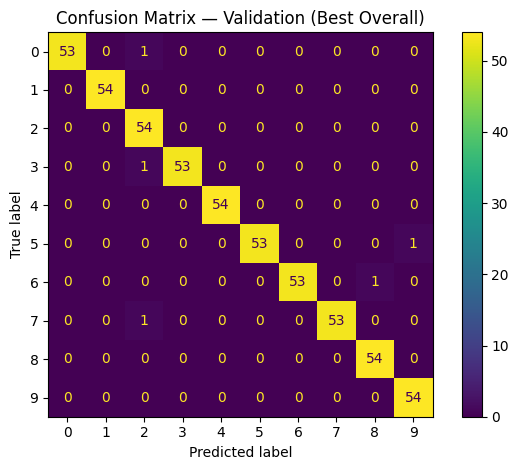

<Figure size 768x720 with 0 Axes>

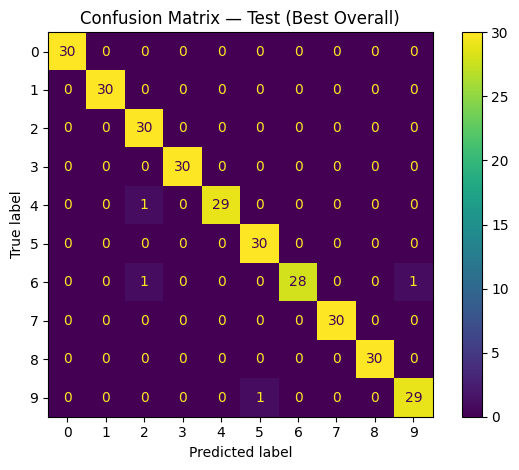

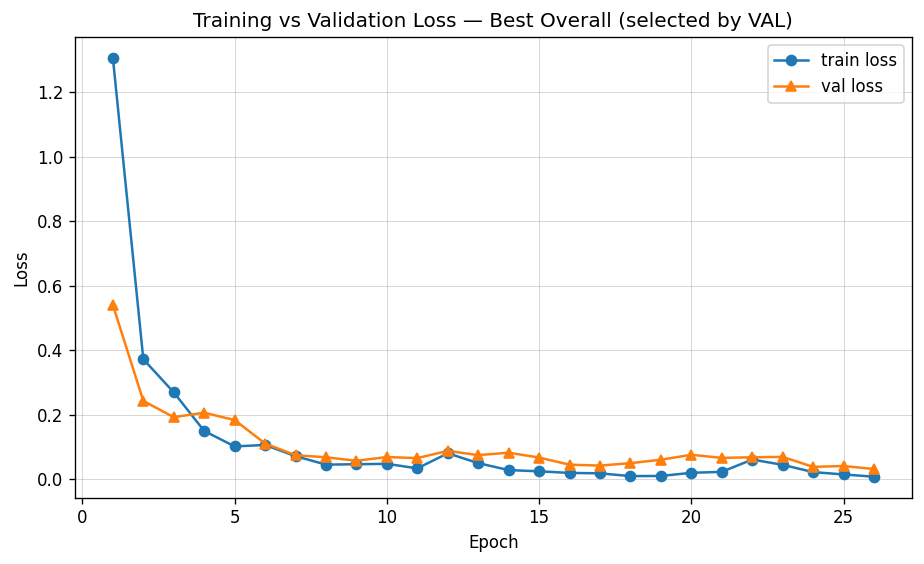

In [7]:
# ==============================================================
# FINAL STEP — Pick the ABSOLUTE BEST model (by validation) up to Step 14.7
# and produce the required deliverables:
#   • Validation & Test accuracy (success rate)
#   • Confusion matrix (on TEST set)
#   • Training-vs-Validation loss curves (same figure)
# ==============================================================

import json, math, numpy as np, torch
import torch.nn as nn
from pathlib import Path
from typing import Dict, Any, Tuple, List
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# --------------------------- Sanity checks ---------------------------
assert 'train_loader' in globals() and 'val_loader' in globals() and 'test_loader' in globals(), \
    "Run the Step-14 Preparatory Cell first (must define train/val/test loaders)."

# --------------------------- File locations (30-epoch artifacts) ---------------------------
P14_4 = Path("Step14_checkpoints_train_only/leaderboard_with_val.json")

# 14.5–14.6: use the 30-epoch directories & filenames
P146_ROOT = Path("Step14_reg_top30_compare_30ep")
P146_FIX  = P146_ROOT / "leaderboard_FIXED_30E.json"
P146_EAR  = P146_ROOT / "leaderboard_EARLY.json"

# Step 7 (BiLSTM) leaderboards
P7_A = Path("Step07_bilstm_from14_4/leaderboard_bilstm_from14_4.json")
P7_B = Path("Step07_bilstm_from14_6/leaderboard_bilstm_from14_6.json")

OUT_DIR = Path("Final_Deliverables")
OUT_DIR.mkdir(parents=True, exist_ok=True)
PLOT_CURVES = OUT_DIR / "Training_vs_Validation_Loss (Best Overall).png"
PLOT_CM_VAL = OUT_DIR / "Confusion_Matrix_Validation (Best Overall).png"
PLOT_CM_TST = OUT_DIR / "Confusion_Matrix_Test (Best Overall).png"

# --------------------------- Model re-instantiation ---------------------------
class GenericLSTMClassifier(nn.Module):
    def __init__(self, input_dim: int, hidden: int, num_layers: int,
                 num_classes: int, dropout_p: float, bidirectional: bool):
        super().__init__()
        self.bidirectional = bidirectional
        self.num_layers = num_layers
        self.dropout_p = dropout_p
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=(dropout_p if num_layers > 1 else 0.0),
        )
        out_dim = hidden * (2 if bidirectional else 1)
        self.post_dropout = nn.Dropout(dropout_p)
        self.fc = nn.Linear(out_dim, num_classes)

    @staticmethod
    def _last_valid(outputs: torch.Tensor, lengths: torch.Tensor) -> torch.Tensor:
        idx = (lengths - 1).view(-1, 1, 1).expand(outputs.size(0), 1, outputs.size(2))
        return outputs.gather(1, idx).squeeze(1)

    @staticmethod
    def _first(outputs: torch.Tensor) -> torch.Tensor:
        return outputs[:, 0, :]

    def forward(self, x, lengths):
        y, _ = self.lstm(x)
        if not self.bidirectional:
            pooled = self._last_valid(y, lengths)
        else:
            H = y.size(-1) // 2
            fw, bw = y[:, :, :H], y[:, :, H:]
            pooled = torch.cat([self._last_valid(fw, lengths), self._first(bw)], dim=-1)
        return self.fc(self.post_dropout(pooled))

def build_model_from_meta(meta: Dict[str, Any]) -> nn.Module:
    model = GenericLSTMClassifier(
        input_dim=int(meta.get("input_dim")),
        hidden=int(meta.get("rnn_size")),
        num_layers=int(meta.get("num_layers", 1)),
        num_classes=int(meta.get("num_classes", 10)),
        dropout_p=float(meta.get("dropout", 0.0)),
        bidirectional=bool(meta.get("bidirectional", False)),
    )
    return model

# --------------------------- Utilities ---------------------------
def _load_json_rows(p: Path, key_loss="best_val_loss", key_acc="best_val_acc", source="") -> list:
    if not p.is_file():
        return []
    rows = json.loads(p.read_text())
    norm = []
    for r in rows:
        loss = float(r.get(key_loss, r.get("val_loss", math.inf)))
        acc  = float(r.get(key_acc,  r.get("val_acc",  -math.inf)))
        ckpt = r.get("checkpoint") or r.get("ckpt_path") or r.get("ckpt") or r.get("path")
        if ckpt is None:
            continue
        norm.append({"source": source, "val_loss": loss, "val_acc": acc, "checkpoint": ckpt})
    return norm

def _make_ckpt_to_valcurve_map_14_4(p: Path) -> Dict[str, Dict[str, List[float]]]:
    """
    For step 14.4 results, build a map: ckpt_path -> {"val_curve": [...], "val_acc_curve": [...]}
    so we can draw per-epoch VAL even if the checkpoint blob lacks it.
    """
    m = {}
    if not p.is_file():
        return m
    rows = json.loads(p.read_text())
    for r in rows:
        ck = r.get("checkpoint")
        if ck:
            m[str(ck)] = {
                "val_curve": r.get("val_curve", []),
                "val_acc_curve": r.get("val_acc_curve", []),
            }
    return m

def select_best_across_sources() -> Dict[str, Any]:
    candidates = []
    candidates += _load_json_rows(P14_4,   key_loss="val_loss",      key_acc="val_acc",      source="step14.4_uni")
    candidates += _load_json_rows(P146_FIX,key_loss="best_val_loss", key_acc="best_val_acc", source="step14.6_FIXED_30E")
    candidates += _load_json_rows(P146_EAR,key_loss="best_val_loss", key_acc="best_val_acc", source="step14.6_EARLY")
    candidates += _load_json_rows(P7_A,    key_loss="best_val_loss", key_acc="best_val_acc", source="step7_from14.4_Bi")
    candidates += _load_json_rows(P7_B,    key_loss="best_val_loss", key_acc="best_val_acc", source="step7_from14.6_Bi")
    assert len(candidates) > 0, "No candidates found. Make sure prior steps ran and saved leaderboards."
    return sorted(candidates, key=lambda r: (r["val_loss"], -r["val_acc"]))[0]

@torch.no_grad()
def evaluate_split(model: nn.Module, loader, crit: nn.Module) -> Tuple[float, float, np.ndarray, np.ndarray]:
    model.eval()
    tot, n, correct = 0.0, 0, 0
    y_true, y_pred = [], []
    for xb, yb, lb in loader:
        logits = model(xb, lb)
        loss   = crit(logits, yb)
        tot += loss.item() * yb.size(0); n += yb.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        y_true.append(yb.cpu().numpy()); y_pred.append(preds.cpu().numpy())
    y_true = np.concatenate(y_true, axis=0); y_pred = np.concatenate(y_pred, axis=0)
    return float(tot / max(1, n)), float(correct / max(1, n)), y_true, y_pred

def plot_train_val_curves(history: Dict[str, list], title: str, outfile: Path):
    train_curve = history.get("train", [])
    val_curve   = history.get("val",   None)
    plt.figure(figsize=(7.8, 4.8), dpi=120)
    if len(train_curve) > 0:
        plt.plot(range(1, len(train_curve)+1), train_curve, marker="o", label="train loss")
    if isinstance(val_curve, (list, tuple)) and len(val_curve) > 0:
        plt.plot(range(1, len(val_curve)+1), val_curve, marker="^", label="val loss")
    else:
        best_val = history.get("best_val_loss", None)
        if best_val is not None:
            plt.axhline(float(best_val), linestyle="--", label=f"val loss (best={best_val:.4f})")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title(title)
    plt.grid(True, linewidth=0.5, alpha=0.6); plt.legend(); plt.tight_layout()
    plt.savefig(outfile); plt.show()

def plot_confusion(y_true: np.ndarray, y_pred: np.ndarray, title: str, outfile: Path, num_classes: int):
    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(num_classes)))
    plt.figure(figsize=(6.4, 6.0), dpi=120)
    disp.plot(values_format="d", cmap=None)
    plt.title(title); plt.tight_layout(); plt.savefig(outfile); plt.show()

# --------------------------- 1) Pick ABSOLUTE BEST by validation ---------------------------
best_row = select_best_across_sources()
best_ckpt_path = Path(best_row["checkpoint"])
assert best_ckpt_path.is_file(), f"Missing checkpoint for best model: {best_ckpt_path}"

# Load the blob and normalize metadata/history regardless of step
blob = torch.load(best_ckpt_path, map_location="cpu")

# (a) Use meta if present; else fallback to cfg (14.1–14.3 checkpoints)
meta = blob.get("meta") or blob.get("cfg", {})
# minimal safety checks
required_keys = ["input_dim", "rnn_size"]
for k in required_keys:
    assert k in meta, f"Checkpoint meta missing '{k}': {best_ckpt_path}"

# (b) Build history
history = blob.get("history", {})
if not isinstance(history, dict):
    history = {}

# Fill train curve if missing (14.1–14.3 style)
if len(history.get("train", [])) == 0:
    tr = blob.get("train_losses", blob.get("losses", []))
    if isinstance(tr, list) and len(tr) > 0:
        history["train"] = tr[:]

# If VAL per-epoch missing in blob and the winner is from 14.4,
# pull val_curve from the 14.4 leaderboard (matched by checkpoint path)
if len(history.get("val", [])) == 0 and best_row["source"].startswith("step14.4"):
    ckpt2val = _make_ckpt_to_valcurve_map_14_4(P14_4)
    vc_pack = ckpt2val.get(str(best_ckpt_path))
    if vc_pack and isinstance(vc_pack.get("val_curve", None), list):
        history["val"] = vc_pack["val_curve"][:]

# Keep best val as fallback line if available
if "best_val_loss" in blob and "best_val_loss" not in history:
    history["best_val_loss"] = blob["best_val_loss"]

print("[Best Model Selected]")
print(f"  source     : {best_row['source']}")
print(f"  checkpoint : {best_ckpt_path}")
print(f"  val_loss   : {best_row['val_loss']:.6f}")
print(f"  val_acc    : {best_row['val_acc']:.6f}")
print(f"  meta       : {meta}")

# --------------------------- 2) Rebuild model & load weights ---------------------------
model = build_model_from_meta(meta)
model.load_state_dict(blob["model_state"])
criterion = nn.CrossEntropyLoss()

# --------------------------- 3) Evaluate on VAL and TEST ---------------------------
val_loss, val_acc, yv_true, yv_pred = evaluate_split(model, val_loader, criterion)
tst_loss, tst_acc, yt_true, yt_pred = evaluate_split(model, test_loader, criterion)

print("\n[Validation Results — Best Overall]")
print(f"  VAL loss: {val_loss:.6f} | VAL accuracy: {val_acc:.4%}")

print("\n[Test Results — Best Overall]")
print(f"  TEST loss: {tst_loss:.6f} | TEST accuracy: {tst_acc:.4%}")

# --------------------------- 4) Confusion matrices (VAL and TEST) ---------------------------
num_classes = int(meta.get("num_classes", 10))
plot_confusion(yv_true, yv_pred, title="Confusion Matrix — Validation (Best Overall)", outfile=PLOT_CM_VAL, num_classes=num_classes)
plot_confusion(yt_true, yt_pred, title="Confusion Matrix — Test (Best Overall)",       outfile=PLOT_CM_TST, num_classes=num_classes)

# --------------------------- 5) Training vs Validation loss curves ---------------------------
plot_train_val_curves(history, title="Training vs Validation Loss — Best Overall (selected by VAL)", outfile=PLOT_CURVES)


---

### **AI Usage Declaration**

The **core content and solution** submitted for this project is the product of our team's **independent intellectual effort**.

**AI-based tools were used strictly for supplementary support** by team members, including:

- **Formatting and organizing** markdown cells for improved clarity,
- **Troubleshooting** specific coding issues,
- **Writing code snippets** based on our team's logic and instructions, and
- **Translating content** from Greek to English for documentation and clarity.

At no point was AI used to generate or influence the **core logic**, **design choices**, or **solutions** required for this project.